CMPE 258 Final Project Python 2.7 Version
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 05/06/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [2]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import time


# state control
state = 1
np.random.seed(state)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
%matplotlib inline
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/'
DATA_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/data/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/model/'
LOG_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/log/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/result/'

In [3]:
X_train = np.load(DATA_PATH + 'X_train_aug_flip_scale.npy')
y_train = np.load(DATA_PATH + 'y_train_aug_flip_scale.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((300, 512, 512, 1), (300, 512, 512, 1), (30, 512, 512, 1))

In [4]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((270, 512, 512, 1), (30, 512, 512, 1), (270, 512, 512, 1), (30, 512, 512, 1))

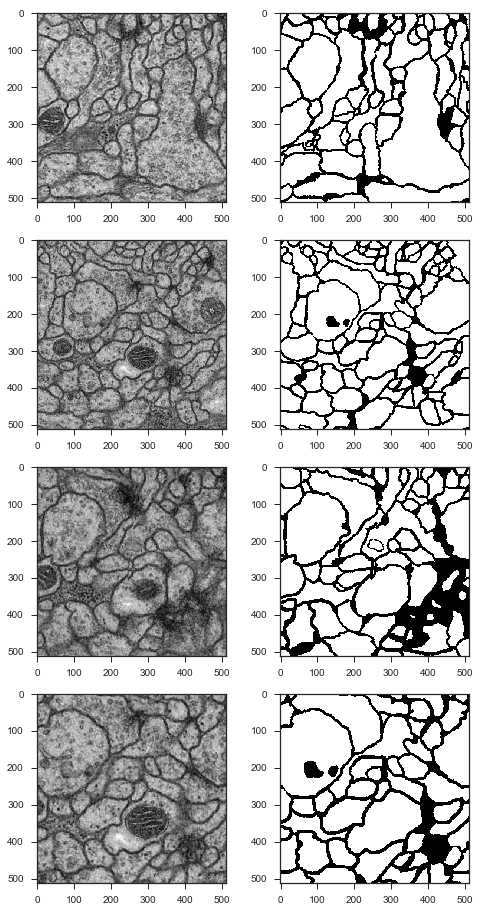

In [5]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8, 16))
for row in range(4):
    ax[row, 0].imshow(X_train[row].reshape(512, 512), cmap='gray')
    ax[row, 1].imshow(y_train[row].reshape(512, 512), cmap='binary')
    
plt.show()

In [7]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from U_Net import u_net_fuse_v3
from Loss_Functions import dice_coef, dice_coef_loss, jaccard_coef, pixel_error

In [9]:
model_unet_fuse_v3 = u_net_fuse_v3(input_shape=(512, 512, 1))
model_unet_fuse_v3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 512, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 512, 512, 32) 832         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 512, 512, 32) 128         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation

In [11]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.8, patience=5, verbose=1, 
                             min_lr=1e-4)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, 
                               save_best_only=True, monitor='val_ofuse_pixel_error')
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v3', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_fuse_v3.compile(loss={'o1': dice_coef_loss,
                                'o2': dice_coef_loss,
                                'o3': dice_coef_loss,
                                'o4': dice_coef_loss,
                                'o5': dice_coef_loss,
                                'ofuse': dice_coef_loss,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error]},
                          optimizer=optimizer)

results = model_unet_fuse_v3.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=80, callbacks=callback_list, verbose=2)

Train on 270 samples, validate on 30 samples


Epoch 1/80


 - 19s - loss: 3.6457 - o1_loss: 0.6188 - o2_loss: 0.5930 - o3_loss: 0.5925 - o4_loss: 0.6049 - o5_loss: 0.5452 - ofuse_loss: 0.6913 - ofuse_dice_coef: 0.3087 - ofuse_jaccard_coef: 0.1828 - ofuse_pixel_error: 0.4811 - val_loss: 3.4713 - val_o1_loss: 0.6239 - val_o2_loss: 0.5752 - val_o3_loss: 0.5158 - val_o4_loss: 0.5675 - val_o5_loss: 0.4841 - val_ofuse_loss: 0.7047 - val_ofuse_dice_coef: 0.2953 - val_ofuse_jaccard_coef: 0.1735 - val_ofuse_pixel_error: 0.5023



Epoch 00001: val_ofuse_pixel_error improved from inf to 0.50226, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/80


 - 19s - loss: 2.7377 - o1_loss: 0.5458 - o2_loss: 0.4592 - o3_loss: 0.4047 - o4_loss: 0.4493 - o5_loss: 0.3868 - ofuse_loss: 0.4919 - ofuse_dice_coef: 0.5081 - ofuse_jaccard_coef: 0.3432 - ofuse_pixel_error: 0.2904 - val_loss: 2.7366 - val_o1_loss: 0.5683 - val_o2_loss: 0.4633 - val_o3_loss: 0.4140 - val_o4_loss: 0.4271 - val_o5_loss: 0.4025 - val_ofuse_loss: 0.4614 - val_ofuse_dice_coef: 0.5386 - val_ofuse_jaccard_coef: 0.3689 - val_ofuse_pixel_error: 0.2751



Epoch 00002: val_ofuse_pixel_error improved from 0.50226 to 0.27512, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/80


 - 20s - loss: 2.1322 - o1_loss: 0.5003 - o2_loss: 0.4032 - o3_loss: 0.3206 - o4_loss: 0.3065 - o5_loss: 0.2737 - ofuse_loss: 0.3279 - ofuse_dice_coef: 0.6721 - ofuse_jaccard_coef: 0.5069 - ofuse_pixel_error: 0.1685 - val_loss: 2.1438 - val_o1_loss: 0.4934 - val_o2_loss: 0.3882 - val_o3_loss: 0.3185 - val_o4_loss: 0.3089 - val_o5_loss: 0.2961 - val_ofuse_loss: 0.3388 - val_ofuse_dice_coef: 0.6612 - val_ofuse_jaccard_coef: 0.4914 - val_ofuse_pixel_error: 0.1549



Epoch 00003: val_ofuse_pixel_error improved from 0.27512 to 0.15487, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 4/80


 - 19s - loss: 1.8378 - o1_loss: 0.4727 - o2_loss: 0.3594 - o3_loss: 0.2756 - o4_loss: 0.2451 - o5_loss: 0.2256 - ofuse_loss: 0.2595 - ofuse_dice_coef: 0.7405 - ofuse_jaccard_coef: 0.5869 - ofuse_pixel_error: 0.1274 - val_loss: 1.8763 - val_o1_loss: 0.4814 - val_o2_loss: 0.3575 - val_o3_loss: 0.2838 - val_o4_loss: 0.2553 - val_o5_loss: 0.2279 - val_ofuse_loss: 0.2703 - val_ofuse_dice_coef: 0.7297 - val_ofuse_jaccard_coef: 0.5726 - val_ofuse_pixel_error: 0.1330



Epoch 00004: val_ofuse_pixel_error improved from 0.15487 to 0.13298, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 5/80


 - 18s - loss: 1.7429 - o1_loss: 0.4657 - o2_loss: 0.3415 - o3_loss: 0.2503 - o4_loss: 0.2316 - o5_loss: 0.2120 - ofuse_loss: 0.2417 - ofuse_dice_coef: 0.7583 - ofuse_jaccard_coef: 0.6095 - ofuse_pixel_error: 0.1186 - val_loss: 2.0996 - val_o1_loss: 0.5182 - val_o2_loss: 0.3831 - val_o3_loss: 0.2973 - val_o4_loss: 0.3171 - val_o5_loss: 0.2789 - val_ofuse_loss: 0.3049 - val_ofuse_dice_coef: 0.6951 - val_ofuse_jaccard_coef: 0.5312 - val_ofuse_pixel_error: 0.1799



Epoch 00005: val_ofuse_pixel_error did not improve
Epoch 6/80


 - 20s - loss: 1.6500 - o1_loss: 0.4562 - o2_loss: 0.3250 - o3_loss: 0.2282 - o4_loss: 0.2175 - o5_loss: 0.1983 - ofuse_loss: 0.2248 - ofuse_dice_coef: 0.7752 - ofuse_jaccard_coef: 0.6316 - ofuse_pixel_error: 0.1096 - val_loss: 1.6637 - val_o1_loss: 0.4550 - val_o2_loss: 0.3165 - val_o3_loss: 0.2233 - val_o4_loss: 0.2317 - val_o5_loss: 0.2111 - val_ofuse_loss: 0.2261 - val_ofuse_dice_coef: 0.7739 - val_ofuse_jaccard_coef: 0.6293 - val_ofuse_pixel_error: 0.1107



Epoch 00006: val_ofuse_pixel_error improved from 0.13298 to 0.11068, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 7/80


 - 19s - loss: 1.5866 - o1_loss: 0.4505 - o2_loss: 0.3152 - o3_loss: 0.2142 - o4_loss: 0.2066 - o5_loss: 0.1884 - ofuse_loss: 0.2117 - ofuse_dice_coef: 0.7883 - ofuse_jaccard_coef: 0.6495 - ofuse_pixel_error: 0.1026 - val_loss: 1.5826 - val_o1_loss: 0.4555 - val_o2_loss: 0.3078 - val_o3_loss: 0.2135 - val_o4_loss: 0.2076 - val_o5_loss: 0.1891 - val_ofuse_loss: 0.2091 - val_ofuse_dice_coef: 0.7909 - val_ofuse_jaccard_coef: 0.6518 - val_ofuse_pixel_error: 0.1009



Epoch 00007: val_ofuse_pixel_error improved from 0.11068 to 0.10091, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 8/80


 - 19s - loss: 1.5380 - o1_loss: 0.4459 - o2_loss: 0.3070 - o3_loss: 0.2051 - o4_loss: 0.1974 - o5_loss: 0.1813 - ofuse_loss: 0.2014 - ofuse_dice_coef: 0.7986 - ofuse_jaccard_coef: 0.6639 - ofuse_pixel_error: 0.0972 - val_loss: 1.5870 - val_o1_loss: 0.4629 - val_o2_loss: 0.3188 - val_o3_loss: 0.2093 - val_o4_loss: 0.2011 - val_o5_loss: 0.1890 - val_ofuse_loss: 0.2059 - val_ofuse_dice_coef: 0.7941 - val_ofuse_jaccard_coef: 0.6568 - val_ofuse_pixel_error: 0.0961



Epoch 00008: val_ofuse_pixel_error improved from 0.10091 to 0.09613, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 9/80


 - 18s - loss: 1.5215 - o1_loss: 0.4446 - o2_loss: 0.3053 - o3_loss: 0.2022 - o4_loss: 0.1932 - o5_loss: 0.1803 - ofuse_loss: 0.1960 - ofuse_dice_coef: 0.8040 - ofuse_jaccard_coef: 0.6709 - ofuse_pixel_error: 0.0945 - val_loss: 1.5005 - val_o1_loss: 0.4411 - val_o2_loss: 0.2964 - val_o3_loss: 0.1971 - val_o4_loss: 0.1936 - val_o5_loss: 0.1805 - val_ofuse_loss: 0.1918 - val_ofuse_dice_coef: 0.8082 - val_ofuse_jaccard_coef: 0.6764 - val_ofuse_pixel_error: 0.0935



Epoch 00009: val_ofuse_pixel_error improved from 0.09613 to 0.09351, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 10/80


 - 18s - loss: 1.4737 - o1_loss: 0.4389 - o2_loss: 0.2974 - o3_loss: 0.1948 - o4_loss: 0.1833 - o5_loss: 0.1735 - ofuse_loss: 0.1858 - ofuse_dice_coef: 0.8142 - ofuse_jaccard_coef: 0.6855 - ofuse_pixel_error: 0.0889 - val_loss: 1.5304 - val_o1_loss: 0.4393 - val_o2_loss: 0.2991 - val_o3_loss: 0.2081 - val_o4_loss: 0.1955 - val_o5_loss: 0.1885 - val_ofuse_loss: 0.1999 - val_ofuse_dice_coef: 0.8001 - val_ofuse_jaccard_coef: 0.6647 - val_ofuse_pixel_error: 0.0889



Epoch 00010: val_ofuse_pixel_error improved from 0.09351 to 0.08888, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 11/80


 - 18s - loss: 1.4482 - o1_loss: 0.4376 - o2_loss: 0.2945 - o3_loss: 0.1905 - o4_loss: 0.1767 - o5_loss: 0.1696 - ofuse_loss: 0.1791 - ofuse_dice_coef: 0.8209 - ofuse_jaccard_coef: 0.6948 - ofuse_pixel_error: 0.0853 - val_loss: 1.4979 - val_o1_loss: 0.4367 - val_o2_loss: 0.2980 - val_o3_loss: 0.2045 - val_o4_loss: 0.1864 - val_o5_loss: 0.1829 - val_ofuse_loss: 0.1894 - val_ofuse_dice_coef: 0.8106 - val_ofuse_jaccard_coef: 0.6799 - val_ofuse_pixel_error: 0.0831



Epoch 00011: val_ofuse_pixel_error improved from 0.08888 to 0.08309, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 12/80


 - 18s - loss: 1.4190 - o1_loss: 0.4338 - o2_loss: 0.2898 - o3_loss: 0.1864 - o4_loss: 0.1707 - o5_loss: 0.1654 - ofuse_loss: 0.1728 - ofuse_dice_coef: 0.8272 - ofuse_jaccard_coef: 0.7042 - ofuse_pixel_error: 0.0821 - val_loss: 1.4517 - val_o1_loss: 0.4359 - val_o2_loss: 0.2887 - val_o3_loss: 0.1929 - val_o4_loss: 0.1779 - val_o5_loss: 0.1752 - val_ofuse_loss: 0.1811 - val_ofuse_dice_coef: 0.8189 - val_ofuse_jaccard_coef: 0.6914 - val_ofuse_pixel_error: 0.0833



Epoch 00012: val_ofuse_pixel_error did not improve
Epoch 13/80


 - 18s - loss: 1.3962 - o1_loss: 0.4318 - o2_loss: 0.2863 - o3_loss: 0.1828 - o4_loss: 0.1658 - o5_loss: 0.1619 - ofuse_loss: 0.1676 - ofuse_dice_coef: 0.8324 - ofuse_jaccard_coef: 0.7121 - ofuse_pixel_error: 0.0795 - val_loss: 1.4956 - val_o1_loss: 0.4375 - val_o2_loss: 0.2947 - val_o3_loss: 0.2017 - val_o4_loss: 0.1868 - val_o5_loss: 0.1840 - val_ofuse_loss: 0.1907 - val_ofuse_dice_coef: 0.8093 - val_ofuse_jaccard_coef: 0.6776 - val_ofuse_pixel_error: 0.0893



Epoch 00013: val_ofuse_pixel_error did not improve
Epoch 14/80


 - 17s - loss: 1.3861 - o1_loss: 0.4299 - o2_loss: 0.2849 - o3_loss: 0.1816 - o4_loss: 0.1637 - o5_loss: 0.1605 - ofuse_loss: 0.1655 - ofuse_dice_coef: 0.8345 - ofuse_jaccard_coef: 0.7147 - ofuse_pixel_error: 0.0785 - val_loss: 1.4177 - val_o1_loss: 0.4308 - val_o2_loss: 0.2850 - val_o3_loss: 0.1883 - val_o4_loss: 0.1709 - val_o5_loss: 0.1692 - val_ofuse_loss: 0.1736 - val_ofuse_dice_coef: 0.8264 - val_ofuse_jaccard_coef: 0.7021 - val_ofuse_pixel_error: 0.0800



Epoch 00014: val_ofuse_pixel_error improved from 0.08309 to 0.08005, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 15/80


 - 18s - loss: 1.3607 - o1_loss: 0.4277 - o2_loss: 0.2806 - o3_loss: 0.1771 - o4_loss: 0.1588 - o5_loss: 0.1560 - ofuse_loss: 0.1604 - ofuse_dice_coef: 0.8396 - ofuse_jaccard_coef: 0.7224 - ofuse_pixel_error: 0.0759 - val_loss: 1.4251 - val_o1_loss: 0.4284 - val_o2_loss: 0.2882 - val_o3_loss: 0.1892 - val_o4_loss: 0.1724 - val_o5_loss: 0.1709 - val_ofuse_loss: 0.1761 - val_ofuse_dice_coef: 0.8239 - val_ofuse_jaccard_coef: 0.6984 - val_ofuse_pixel_error: 0.0808



Epoch 00015: val_ofuse_pixel_error did not improve
Epoch 16/80


 - 17s - loss: 1.3494 - o1_loss: 0.4260 - o2_loss: 0.2785 - o3_loss: 0.1755 - o4_loss: 0.1568 - o5_loss: 0.1545 - ofuse_loss: 0.1581 - ofuse_dice_coef: 0.8419 - ofuse_jaccard_coef: 0.7257 - ofuse_pixel_error: 0.0748 - val_loss: 1.3936 - val_o1_loss: 0.4306 - val_o2_loss: 0.2826 - val_o3_loss: 0.1837 - val_o4_loss: 0.1651 - val_o5_loss: 0.1632 - val_ofuse_loss: 0.1683 - val_ofuse_dice_coef: 0.8317 - val_ofuse_jaccard_coef: 0.7102 - val_ofuse_pixel_error: 0.0760



Epoch 00016: val_ofuse_pixel_error improved from 0.08005 to 0.07600, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 17/80


 - 17s - loss: 1.3354 - o1_loss: 0.4247 - o2_loss: 0.2763 - o3_loss: 0.1728 - o4_loss: 0.1541 - o5_loss: 0.1520 - ofuse_loss: 0.1554 - ofuse_dice_coef: 0.8446 - ofuse_jaccard_coef: 0.7299 - ofuse_pixel_error: 0.0736 - val_loss: 1.4460 - val_o1_loss: 0.4308 - val_o2_loss: 0.2880 - val_o3_loss: 0.1964 - val_o4_loss: 0.1800 - val_o5_loss: 0.1715 - val_ofuse_loss: 0.1795 - val_ofuse_dice_coef: 0.8205 - val_ofuse_jaccard_coef: 0.6941 - val_ofuse_pixel_error: 0.0760



Epoch 00017: val_ofuse_pixel_error did not improve
Epoch 18/80


 - 17s - loss: 1.3259 - o1_loss: 0.4234 - o2_loss: 0.2743 - o3_loss: 0.1716 - o4_loss: 0.1524 - o5_loss: 0.1506 - ofuse_loss: 0.1536 - ofuse_dice_coef: 0.8464 - ofuse_jaccard_coef: 0.7325 - ofuse_pixel_error: 0.0727 - val_loss: 1.3908 - val_o1_loss: 0.4267 - val_o2_loss: 0.2818 - val_o3_loss: 0.1827 - val_o4_loss: 0.1671 - val_o5_loss: 0.1645 - val_ofuse_loss: 0.1679 - val_ofuse_dice_coef: 0.8321 - val_ofuse_jaccard_coef: 0.7109 - val_ofuse_pixel_error: 0.0740



Epoch 00018: val_ofuse_pixel_error improved from 0.07600 to 0.07401, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 19/80


 - 17s - loss: 1.3057 - o1_loss: 0.4209 - o2_loss: 0.2710 - o3_loss: 0.1681 - o4_loss: 0.1488 - o5_loss: 0.1469 - ofuse_loss: 0.1500 - ofuse_dice_coef: 0.8500 - ofuse_jaccard_coef: 0.7381 - ofuse_pixel_error: 0.0710 - val_loss: 1.3619 - val_o1_loss: 0.4253 - val_o2_loss: 0.2765 - val_o3_loss: 0.1796 - val_o4_loss: 0.1600 - val_o5_loss: 0.1588 - val_ofuse_loss: 0.1616 - val_ofuse_dice_coef: 0.8384 - val_ofuse_jaccard_coef: 0.7199 - val_ofuse_pixel_error: 0.0741



Epoch 00019: val_ofuse_pixel_error did not improve
Epoch 20/80


 - 17s - loss: 1.2966 - o1_loss: 0.4200 - o2_loss: 0.2697 - o3_loss: 0.1664 - o4_loss: 0.1472 - o5_loss: 0.1453 - ofuse_loss: 0.1480 - ofuse_dice_coef: 0.8520 - ofuse_jaccard_coef: 0.7410 - ofuse_pixel_error: 0.0698 - val_loss: 1.3648 - val_o1_loss: 0.4211 - val_o2_loss: 0.2745 - val_o3_loss: 0.1799 - val_o4_loss: 0.1626 - val_o5_loss: 0.1624 - val_ofuse_loss: 0.1644 - val_ofuse_dice_coef: 0.8356 - val_ofuse_jaccard_coef: 0.7159 - val_ofuse_pixel_error: 0.0771



Epoch 00020: val_ofuse_pixel_error did not improve
Epoch 21/80


 - 17s - loss: 1.2920 - o1_loss: 0.4189 - o2_loss: 0.2688 - o3_loss: 0.1657 - o4_loss: 0.1466 - o5_loss: 0.1448 - ofuse_loss: 0.1472 - ofuse_dice_coef: 0.8528 - ofuse_jaccard_coef: 0.7422 - ofuse_pixel_error: 0.0694 - val_loss: 1.3524 - val_o1_loss: 0.4218 - val_o2_loss: 0.2728 - val_o3_loss: 0.1758 - val_o4_loss: 0.1629 - val_o5_loss: 0.1580 - val_ofuse_loss: 0.1611 - val_ofuse_dice_coef: 0.8389 - val_ofuse_jaccard_coef: 0.7208 - val_ofuse_pixel_error: 0.0710



Epoch 00021: val_ofuse_pixel_error improved from 0.07401 to 0.07104, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 22/80


 - 17s - loss: 1.2694 - o1_loss: 0.4174 - o2_loss: 0.2656 - o3_loss: 0.1615 - o4_loss: 0.1420 - o5_loss: 0.1402 - ofuse_loss: 0.1427 - ofuse_dice_coef: 0.8573 - ofuse_jaccard_coef: 0.7490 - ofuse_pixel_error: 0.0673 - val_loss: 1.3645 - val_o1_loss: 0.4228 - val_o2_loss: 0.2720 - val_o3_loss: 0.1812 - val_o4_loss: 0.1647 - val_o5_loss: 0.1606 - val_ofuse_loss: 0.1632 - val_ofuse_dice_coef: 0.8368 - val_ofuse_jaccard_coef: 0.7170 - val_ofuse_pixel_error: 0.0721



Epoch 00022: val_ofuse_pixel_error did not improve
Epoch 23/80


 - 17s - loss: 1.2621 - o1_loss: 0.4161 - o2_loss: 0.2643 - o3_loss: 0.1604 - o4_loss: 0.1408 - o5_loss: 0.1391 - ofuse_loss: 0.1414 - ofuse_dice_coef: 0.8586 - ofuse_jaccard_coef: 0.7510 - ofuse_pixel_error: 0.0666 - val_loss: 1.3489 - val_o1_loss: 0.4216 - val_o2_loss: 0.2731 - val_o3_loss: 0.1780 - val_o4_loss: 0.1581 - val_o5_loss: 0.1575 - val_ofuse_loss: 0.1605 - val_ofuse_dice_coef: 0.8395 - val_ofuse_jaccard_coef: 0.7218 - val_ofuse_pixel_error: 0.0759



Epoch 00023: val_ofuse_pixel_error did not improve
Epoch 24/80


 - 17s - loss: 1.2601 - o1_loss: 0.4151 - o2_loss: 0.2637 - o3_loss: 0.1603 - o4_loss: 0.1407 - o5_loss: 0.1389 - ofuse_loss: 0.1413 - ofuse_dice_coef: 0.8587 - ofuse_jaccard_coef: 0.7513 - ofuse_pixel_error: 0.0667 - val_loss: 1.3628 - val_o1_loss: 0.4260 - val_o2_loss: 0.2714 - val_o3_loss: 0.1774 - val_o4_loss: 0.1606 - val_o5_loss: 0.1642 - val_ofuse_loss: 0.1632 - val_ofuse_dice_coef: 0.8368 - val_ofuse_jaccard_coef: 0.7175 - val_ofuse_pixel_error: 0.0783



Epoch 00024: val_ofuse_pixel_error did not improve
Epoch 25/80


 - 17s - loss: 1.2456 - o1_loss: 0.4140 - o2_loss: 0.2614 - o3_loss: 0.1575 - o4_loss: 0.1379 - o5_loss: 0.1364 - ofuse_loss: 0.1384 - ofuse_dice_coef: 0.8616 - ofuse_jaccard_coef: 0.7558 - ofuse_pixel_error: 0.0652 - val_loss: 1.3856 - val_o1_loss: 0.4190 - val_o2_loss: 0.2735 - val_o3_loss: 0.1882 - val_o4_loss: 0.1692 - val_o5_loss: 0.1672 - val_ofuse_loss: 0.1684 - val_ofuse_dice_coef: 0.8316 - val_ofuse_jaccard_coef: 0.7100 - val_ofuse_pixel_error: 0.0734



Epoch 00025: val_ofuse_pixel_error did not improve
Epoch 26/80


 - 17s - loss: 1.2236 - o1_loss: 0.4127 - o2_loss: 0.2588 - o3_loss: 0.1532 - o4_loss: 0.1334 - o5_loss: 0.1318 - ofuse_loss: 0.1338 - ofuse_dice_coef: 0.8662 - ofuse_jaccard_coef: 0.7631 - ofuse_pixel_error: 0.0629 - val_loss: 1.3156 - val_o1_loss: 0.4187 - val_o2_loss: 0.2672 - val_o3_loss: 0.1713 - val_o4_loss: 0.1531 - val_o5_loss: 0.1515 - val_ofuse_loss: 0.1539 - val_ofuse_dice_coef: 0.8461 - val_ofuse_jaccard_coef: 0.7317 - val_ofuse_pixel_error: 0.0708



Epoch 00026: val_ofuse_pixel_error improved from 0.07104 to 0.07080, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 27/80


 - 17s - loss: 1.2171 - o1_loss: 0.4115 - o2_loss: 0.2577 - o3_loss: 0.1524 - o4_loss: 0.1321 - o5_loss: 0.1306 - ofuse_loss: 0.1327 - ofuse_dice_coef: 0.8673 - ofuse_jaccard_coef: 0.7647 - ofuse_pixel_error: 0.0623 - val_loss: 1.3201 - val_o1_loss: 0.4177 - val_o2_loss: 0.2672 - val_o3_loss: 0.1716 - val_o4_loss: 0.1538 - val_o5_loss: 0.1536 - val_ofuse_loss: 0.1562 - val_ofuse_dice_coef: 0.8438 - val_ofuse_jaccard_coef: 0.7276 - val_ofuse_pixel_error: 0.0732



Epoch 00027: val_ofuse_pixel_error did not improve
Epoch 28/80


 - 17s - loss: 1.2068 - o1_loss: 0.4104 - o2_loss: 0.2563 - o3_loss: 0.1504 - o4_loss: 0.1303 - o5_loss: 0.1288 - ofuse_loss: 0.1306 - ofuse_dice_coef: 0.8694 - ofuse_jaccard_coef: 0.7679 - ofuse_pixel_error: 0.0614 - val_loss: 1.3233 - val_o1_loss: 0.4183 - val_o2_loss: 0.2692 - val_o3_loss: 0.1734 - val_o4_loss: 0.1537 - val_o5_loss: 0.1534 - val_ofuse_loss: 0.1552 - val_ofuse_dice_coef: 0.8448 - val_ofuse_jaccard_coef: 0.7292 - val_ofuse_pixel_error: 0.0719



Epoch 00028: val_ofuse_pixel_error did not improve
Epoch 29/80


 - 17s - loss: 1.1953 - o1_loss: 0.4095 - o2_loss: 0.2545 - o3_loss: 0.1483 - o4_loss: 0.1281 - o5_loss: 0.1266 - ofuse_loss: 0.1284 - ofuse_dice_coef: 0.8716 - ofuse_jaccard_coef: 0.7713 - ofuse_pixel_error: 0.0604 - val_loss: 1.3368 - val_o1_loss: 0.4163 - val_o2_loss: 0.2675 - val_o3_loss: 0.1773 - val_o4_loss: 0.1599 - val_o5_loss: 0.1585 - val_ofuse_loss: 0.1573 - val_ofuse_dice_coef: 0.8427 - val_ofuse_jaccard_coef: 0.7268 - val_ofuse_pixel_error: 0.0688



Epoch 00029: val_ofuse_pixel_error improved from 0.07080 to 0.06883, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 30/80


 - 17s - loss: 1.1791 - o1_loss: 0.4082 - o2_loss: 0.2528 - o3_loss: 0.1453 - o4_loss: 0.1247 - o5_loss: 0.1232 - ofuse_loss: 0.1249 - ofuse_dice_coef: 0.8751 - ofuse_jaccard_coef: 0.7768 - ofuse_pixel_error: 0.0586 - val_loss: 1.3001 - val_o1_loss: 0.4173 - val_o2_loss: 0.2637 - val_o3_loss: 0.1680 - val_o4_loss: 0.1517 - val_o5_loss: 0.1487 - val_ofuse_loss: 0.1506 - val_ofuse_dice_coef: 0.8494 - val_ofuse_jaccard_coef: 0.7364 - val_ofuse_pixel_error: 0.0678



Epoch 00030: val_ofuse_pixel_error improved from 0.06883 to 0.06780, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 31/80


 - 17s - loss: 1.1688 - o1_loss: 0.4072 - o2_loss: 0.2512 - o3_loss: 0.1434 - o4_loss: 0.1227 - o5_loss: 0.1214 - ofuse_loss: 0.1228 - ofuse_dice_coef: 0.8772 - ofuse_jaccard_coef: 0.7801 - ofuse_pixel_error: 0.0576 - val_loss: 1.3013 - val_o1_loss: 0.4153 - val_o2_loss: 0.2642 - val_o3_loss: 0.1687 - val_o4_loss: 0.1515 - val_o5_loss: 0.1500 - val_ofuse_loss: 0.1515 - val_ofuse_dice_coef: 0.8485 - val_ofuse_jaccard_coef: 0.7349 - val_ofuse_pixel_error: 0.0694



Epoch 00031: val_ofuse_pixel_error did not improve
Epoch 32/80


 - 17s - loss: 1.1571 - o1_loss: 0.4065 - o2_loss: 0.2497 - o3_loss: 0.1412 - o4_loss: 0.1203 - o5_loss: 0.1189 - ofuse_loss: 0.1205 - ofuse_dice_coef: 0.8795 - ofuse_jaccard_coef: 0.7840 - ofuse_pixel_error: 0.0564 - val_loss: 1.2841 - val_o1_loss: 0.4146 - val_o2_loss: 0.2618 - val_o3_loss: 0.1647 - val_o4_loss: 0.1473 - val_o5_loss: 0.1469 - val_ofuse_loss: 0.1486 - val_ofuse_dice_coef: 0.8514 - val_ofuse_jaccard_coef: 0.7393 - val_ofuse_pixel_error: 0.0698



Epoch 00032: val_ofuse_pixel_error did not improve
Epoch 33/80


 - 17s - loss: 1.1459 - o1_loss: 0.4058 - o2_loss: 0.2481 - o3_loss: 0.1392 - o4_loss: 0.1179 - o5_loss: 0.1166 - ofuse_loss: 0.1182 - ofuse_dice_coef: 0.8818 - ofuse_jaccard_coef: 0.7877 - ofuse_pixel_error: 0.0553 - val_loss: 1.2982 - val_o1_loss: 0.4162 - val_o2_loss: 0.2618 - val_o3_loss: 0.1667 - val_o4_loss: 0.1515 - val_o5_loss: 0.1510 - val_ofuse_loss: 0.1510 - val_ofuse_dice_coef: 0.8490 - val_ofuse_jaccard_coef: 0.7359 - val_ofuse_pixel_error: 0.0708



Epoch 00033: val_ofuse_pixel_error did not improve
Epoch 34/80


 - 17s - loss: 1.1364 - o1_loss: 0.4048 - o2_loss: 0.2470 - o3_loss: 0.1375 - o4_loss: 0.1161 - o5_loss: 0.1148 - ofuse_loss: 0.1163 - ofuse_dice_coef: 0.8837 - ofuse_jaccard_coef: 0.7908 - ofuse_pixel_error: 0.0544 - val_loss: 1.2871 - val_o1_loss: 0.4144 - val_o2_loss: 0.2620 - val_o3_loss: 0.1654 - val_o4_loss: 0.1484 - val_o5_loss: 0.1474 - val_ofuse_loss: 0.1495 - val_ofuse_dice_coef: 0.8505 - val_ofuse_jaccard_coef: 0.7378 - val_ofuse_pixel_error: 0.0701



Epoch 00034: val_ofuse_pixel_error did not improve
Epoch 35/80


 - 17s - loss: 1.1262 - o1_loss: 0.4037 - o2_loss: 0.2459 - o3_loss: 0.1356 - o4_loss: 0.1141 - o5_loss: 0.1128 - ofuse_loss: 0.1142 - ofuse_dice_coef: 0.8858 - ofuse_jaccard_coef: 0.7941 - ofuse_pixel_error: 0.0534 - val_loss: 1.2894 - val_o1_loss: 0.4138 - val_o2_loss: 0.2637 - val_o3_loss: 0.1657 - val_o4_loss: 0.1496 - val_o5_loss: 0.1472 - val_ofuse_loss: 0.1492 - val_ofuse_dice_coef: 0.8508 - val_ofuse_jaccard_coef: 0.7387 - val_ofuse_pixel_error: 0.0673



Epoch 00035: val_ofuse_pixel_error improved from 0.06780 to 0.06730, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 36/80


 - 17s - loss: 1.1168 - o1_loss: 0.4030 - o2_loss: 0.2448 - o3_loss: 0.1340 - o4_loss: 0.1120 - o5_loss: 0.1109 - ofuse_loss: 0.1121 - ofuse_dice_coef: 0.8879 - ofuse_jaccard_coef: 0.7975 - ofuse_pixel_error: 0.0524 - val_loss: 1.3118 - val_o1_loss: 0.4154 - val_o2_loss: 0.2669 - val_o3_loss: 0.1726 - val_o4_loss: 0.1542 - val_o5_loss: 0.1500 - val_ofuse_loss: 0.1528 - val_ofuse_dice_coef: 0.8472 - val_ofuse_jaccard_coef: 0.7331 - val_ofuse_pixel_error: 0.0678



Epoch 00036: val_ofuse_pixel_error did not improve
Epoch 37/80


 - 18s - loss: 1.1056 - o1_loss: 0.4023 - o2_loss: 0.2435 - o3_loss: 0.1319 - o4_loss: 0.1098 - o5_loss: 0.1084 - ofuse_loss: 0.1097 - ofuse_dice_coef: 0.8903 - ofuse_jaccard_coef: 0.8013 - ofuse_pixel_error: 0.0511 - val_loss: 1.2888 - val_o1_loss: 0.4130 - val_o2_loss: 0.2607 - val_o3_loss: 0.1659 - val_o4_loss: 0.1511 - val_o5_loss: 0.1485 - val_ofuse_loss: 0.1495 - val_ofuse_dice_coef: 0.8505 - val_ofuse_jaccard_coef: 0.7378 - val_ofuse_pixel_error: 0.0674



Epoch 00037: val_ofuse_pixel_error did not improve
Epoch 38/80


 - 17s - loss: 1.1009 - o1_loss: 0.4021 - o2_loss: 0.2427 - o3_loss: 0.1310 - o4_loss: 0.1088 - o5_loss: 0.1076 - ofuse_loss: 0.1088 - ofuse_dice_coef: 0.8912 - ofuse_jaccard_coef: 0.8030 - ofuse_pixel_error: 0.0508 - val_loss: 1.2966 - val_o1_loss: 0.4143 - val_o2_loss: 0.2613 - val_o3_loss: 0.1701 - val_o4_loss: 0.1512 - val_o5_loss: 0.1494 - val_ofuse_loss: 0.1503 - val_ofuse_dice_coef: 0.8497 - val_ofuse_jaccard_coef: 0.7367 - val_ofuse_pixel_error: 0.0677



Epoch 00038: val_ofuse_pixel_error did not improve
Epoch 39/80


 - 18s - loss: 1.0982 - o1_loss: 0.4018 - o2_loss: 0.2426 - o3_loss: 0.1305 - o4_loss: 0.1081 - o5_loss: 0.1071 - ofuse_loss: 0.1080 - ofuse_dice_coef: 0.8920 - ofuse_jaccard_coef: 0.8041 - ofuse_pixel_error: 0.0503 - val_loss: 1.2853 - val_o1_loss: 0.4140 - val_o2_loss: 0.2633 - val_o3_loss: 0.1660 - val_o4_loss: 0.1476 - val_o5_loss: 0.1461 - val_ofuse_loss: 0.1483 - val_ofuse_dice_coef: 0.8517 - val_ofuse_jaccard_coef: 0.7397 - val_ofuse_pixel_error: 0.0678



Epoch 00039: val_ofuse_pixel_error did not improve
Epoch 40/80


 - 17s - loss: 1.0793 - o1_loss: 0.4006 - o2_loss: 0.2406 - o3_loss: 0.1272 - o4_loss: 0.1040 - o5_loss: 0.1028 - ofuse_loss: 0.1041 - ofuse_dice_coef: 0.8959 - ofuse_jaccard_coef: 0.8106 - ofuse_pixel_error: 0.0485 - val_loss: 1.2873 - val_o1_loss: 0.4119 - val_o2_loss: 0.2594 - val_o3_loss: 0.1669 - val_o4_loss: 0.1509 - val_o5_loss: 0.1486 - val_ofuse_loss: 0.1496 - val_ofuse_dice_coef: 0.8504 - val_ofuse_jaccard_coef: 0.7379 - val_ofuse_pixel_error: 0.0673



Epoch 00040: val_ofuse_pixel_error did not improve
Epoch 41/80


 - 17s - loss: 1.0659 - o1_loss: 0.3993 - o2_loss: 0.2388 - o3_loss: 0.1247 - o4_loss: 0.1015 - o5_loss: 0.1002 - ofuse_loss: 0.1014 - ofuse_dice_coef: 0.8986 - ofuse_jaccard_coef: 0.8150 - ofuse_pixel_error: 0.0471 - val_loss: 1.2942 - val_o1_loss: 0.4127 - val_o2_loss: 0.2613 - val_o3_loss: 0.1673 - val_o4_loss: 0.1514 - val_o5_loss: 0.1501 - val_ofuse_loss: 0.1514 - val_ofuse_dice_coef: 0.8486 - val_ofuse_jaccard_coef: 0.7352 - val_ofuse_pixel_error: 0.0697



Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.000800000037998.

Epoch 00041: val_ofuse_pixel_error did not improve
Epoch 42/80


 - 17s - loss: 1.0524 - o1_loss: 0.3982 - o2_loss: 0.2371 - o3_loss: 0.1224 - o4_loss: 0.0986 - o5_loss: 0.0975 - ofuse_loss: 0.0986 - ofuse_dice_coef: 0.9014 - ofuse_jaccard_coef: 0.8197 - ofuse_pixel_error: 0.0459 - val_loss: 1.2941 - val_o1_loss: 0.4122 - val_o2_loss: 0.2628 - val_o3_loss: 0.1687 - val_o4_loss: 0.1511 - val_o5_loss: 0.1489 - val_ofuse_loss: 0.1504 - val_ofuse_dice_coef: 0.8496 - val_ofuse_jaccard_coef: 0.7366 - val_ofuse_pixel_error: 0.0678



Epoch 00042: val_ofuse_pixel_error did not improve
Epoch 43/80


 - 18s - loss: 1.0429 - o1_loss: 0.3979 - o2_loss: 0.2361 - o3_loss: 0.1206 - o4_loss: 0.0966 - o5_loss: 0.0953 - ofuse_loss: 0.0964 - ofuse_dice_coef: 0.9036 - ofuse_jaccard_coef: 0.8234 - ofuse_pixel_error: 0.0446 - val_loss: 1.2901 - val_o1_loss: 0.4123 - val_o2_loss: 0.2600 - val_o3_loss: 0.1673 - val_o4_loss: 0.1514 - val_o5_loss: 0.1495 - val_ofuse_loss: 0.1496 - val_ofuse_dice_coef: 0.8504 - val_ofuse_jaccard_coef: 0.7379 - val_ofuse_pixel_error: 0.0665



Epoch 00043: val_ofuse_pixel_error improved from 0.06730 to 0.06655, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 44/80


 - 17s - loss: 1.0362 - o1_loss: 0.3972 - o2_loss: 0.2355 - o3_loss: 0.1195 - o4_loss: 0.0951 - o5_loss: 0.0939 - ofuse_loss: 0.0950 - ofuse_dice_coef: 0.9050 - ofuse_jaccard_coef: 0.8258 - ofuse_pixel_error: 0.0441 - val_loss: 1.2972 - val_o1_loss: 0.4129 - val_o2_loss: 0.2611 - val_o3_loss: 0.1689 - val_o4_loss: 0.1526 - val_o5_loss: 0.1512 - val_ofuse_loss: 0.1505 - val_ofuse_dice_coef: 0.8495 - val_ofuse_jaccard_coef: 0.7364 - val_ofuse_pixel_error: 0.0671



Epoch 00044: val_ofuse_pixel_error did not improve
Epoch 45/80


 - 17s - loss: 1.0268 - o1_loss: 0.3961 - o2_loss: 0.2343 - o3_loss: 0.1178 - o4_loss: 0.0934 - o5_loss: 0.0921 - ofuse_loss: 0.0932 - ofuse_dice_coef: 0.9068 - ofuse_jaccard_coef: 0.8288 - ofuse_pixel_error: 0.0432 - val_loss: 1.2804 - val_o1_loss: 0.4119 - val_o2_loss: 0.2601 - val_o3_loss: 0.1654 - val_o4_loss: 0.1486 - val_o5_loss: 0.1464 - val_ofuse_loss: 0.1480 - val_ofuse_dice_coef: 0.8520 - val_ofuse_jaccard_coef: 0.7403 - val_ofuse_pixel_error: 0.0669



Epoch 00045: val_ofuse_pixel_error did not improve
Epoch 46/80


 - 17s - loss: 1.0238 - o1_loss: 0.3959 - o2_loss: 0.2341 - o3_loss: 0.1173 - o4_loss: 0.0926 - o5_loss: 0.0916 - ofuse_loss: 0.0923 - ofuse_dice_coef: 0.9077 - ofuse_jaccard_coef: 0.8301 - ofuse_pixel_error: 0.0428 - val_loss: 1.2756 - val_o1_loss: 0.4121 - val_o2_loss: 0.2594 - val_o3_loss: 0.1638 - val_o4_loss: 0.1479 - val_o5_loss: 0.1457 - val_ofuse_loss: 0.1469 - val_ofuse_dice_coef: 0.8531 - val_ofuse_jaccard_coef: 0.7418 - val_ofuse_pixel_error: 0.0667



Epoch 00046: val_ofuse_pixel_error did not improve
Epoch 47/80


 - 17s - loss: 1.0137 - o1_loss: 0.3953 - o2_loss: 0.2328 - o3_loss: 0.1156 - o4_loss: 0.0904 - o5_loss: 0.0893 - ofuse_loss: 0.0903 - ofuse_dice_coef: 0.9097 - ofuse_jaccard_coef: 0.8335 - ofuse_pixel_error: 0.0418 - val_loss: 1.3298 - val_o1_loss: 0.4150 - val_o2_loss: 0.2640 - val_o3_loss: 0.1752 - val_o4_loss: 0.1605 - val_o5_loss: 0.1573 - val_ofuse_loss: 0.1578 - val_ofuse_dice_coef: 0.8422 - val_ofuse_jaccard_coef: 0.7257 - val_ofuse_pixel_error: 0.0679



Epoch 00047: val_ofuse_pixel_error did not improve
Epoch 48/80


 - 17s - loss: 1.0093 - o1_loss: 0.3949 - o2_loss: 0.2322 - o3_loss: 0.1148 - o4_loss: 0.0896 - o5_loss: 0.0884 - ofuse_loss: 0.0893 - ofuse_dice_coef: 0.9107 - ofuse_jaccard_coef: 0.8353 - ofuse_pixel_error: 0.0413 - val_loss: 1.2742 - val_o1_loss: 0.4104 - val_o2_loss: 0.2585 - val_o3_loss: 0.1647 - val_o4_loss: 0.1479 - val_o5_loss: 0.1458 - val_ofuse_loss: 0.1470 - val_ofuse_dice_coef: 0.8530 - val_ofuse_jaccard_coef: 0.7417 - val_ofuse_pixel_error: 0.0672



Epoch 00048: val_ofuse_pixel_error did not improve
Epoch 49/80


 - 18s - loss: 1.0012 - o1_loss: 0.3944 - o2_loss: 0.2312 - o3_loss: 0.1134 - o4_loss: 0.0879 - o5_loss: 0.0867 - ofuse_loss: 0.0877 - ofuse_dice_coef: 0.9123 - ofuse_jaccard_coef: 0.8381 - ofuse_pixel_error: 0.0406 - val_loss: 1.2809 - val_o1_loss: 0.4113 - val_o2_loss: 0.2595 - val_o3_loss: 0.1653 - val_o4_loss: 0.1487 - val_o5_loss: 0.1475 - val_ofuse_loss: 0.1487 - val_ofuse_dice_coef: 0.8513 - val_ofuse_jaccard_coef: 0.7392 - val_ofuse_pixel_error: 0.0690



Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.000640000030398.

Epoch 00049: val_ofuse_pixel_error did not improve
Epoch 50/80


 - 17s - loss: 0.9912 - o1_loss: 0.3937 - o2_loss: 0.2305 - o3_loss: 0.1117 - o4_loss: 0.0856 - o5_loss: 0.0844 - ofuse_loss: 0.0853 - ofuse_dice_coef: 0.9147 - ofuse_jaccard_coef: 0.8420 - ofuse_pixel_error: 0.0394 - val_loss: 1.2741 - val_o1_loss: 0.4096 - val_o2_loss: 0.2573 - val_o3_loss: 0.1647 - val_o4_loss: 0.1484 - val_o5_loss: 0.1468 - val_ofuse_loss: 0.1473 - val_ofuse_dice_coef: 0.8527 - val_ofuse_jaccard_coef: 0.7414 - val_ofuse_pixel_error: 0.0665



Epoch 00050: val_ofuse_pixel_error did not improve
Epoch 51/80


 - 17s - loss: 0.9857 - o1_loss: 0.3934 - o2_loss: 0.2297 - o3_loss: 0.1107 - o4_loss: 0.0844 - o5_loss: 0.0833 - ofuse_loss: 0.0841 - ofuse_dice_coef: 0.9159 - ofuse_jaccard_coef: 0.8440 - ofuse_pixel_error: 0.0389 - val_loss: 1.2799 - val_o1_loss: 0.4097 - val_o2_loss: 0.2579 - val_o3_loss: 0.1662 - val_o4_loss: 0.1495 - val_o5_loss: 0.1481 - val_ofuse_loss: 0.1485 - val_ofuse_dice_coef: 0.8515 - val_ofuse_jaccard_coef: 0.7393 - val_ofuse_pixel_error: 0.0669



Epoch 00051: val_ofuse_pixel_error did not improve
Epoch 52/80


 - 17s - loss: 0.9839 - o1_loss: 0.3928 - o2_loss: 0.2292 - o3_loss: 0.1104 - o4_loss: 0.0843 - o5_loss: 0.0832 - ofuse_loss: 0.0840 - ofuse_dice_coef: 0.9160 - ofuse_jaccard_coef: 0.8443 - ofuse_pixel_error: 0.0387 - val_loss: 1.2827 - val_o1_loss: 0.4114 - val_o2_loss: 0.2601 - val_o3_loss: 0.1664 - val_o4_loss: 0.1487 - val_o5_loss: 0.1473 - val_ofuse_loss: 0.1487 - val_ofuse_dice_coef: 0.8513 - val_ofuse_jaccard_coef: 0.7391 - val_ofuse_pixel_error: 0.0683



Epoch 00052: val_ofuse_pixel_error did not improve
Epoch 53/80


 - 17s - loss: 0.9764 - o1_loss: 0.3923 - o2_loss: 0.2286 - o3_loss: 0.1091 - o4_loss: 0.0827 - o5_loss: 0.0814 - ofuse_loss: 0.0823 - ofuse_dice_coef: 0.9177 - ofuse_jaccard_coef: 0.8472 - ofuse_pixel_error: 0.0380 - val_loss: 1.2806 - val_o1_loss: 0.4103 - val_o2_loss: 0.2592 - val_o3_loss: 0.1657 - val_o4_loss: 0.1491 - val_o5_loss: 0.1476 - val_ofuse_loss: 0.1486 - val_ofuse_dice_coef: 0.8514 - val_ofuse_jaccard_coef: 0.7393 - val_ofuse_pixel_error: 0.0675



Epoch 00053: val_ofuse_pixel_error did not improve
Epoch 54/80


 - 17s - loss: 0.9740 - o1_loss: 0.3924 - o2_loss: 0.2282 - o3_loss: 0.1087 - o4_loss: 0.0821 - o5_loss: 0.0809 - ofuse_loss: 0.0817 - ofuse_dice_coef: 0.9183 - ofuse_jaccard_coef: 0.8483 - ofuse_pixel_error: 0.0377 - val_loss: 1.2819 - val_o1_loss: 0.4094 - val_o2_loss: 0.2581 - val_o3_loss: 0.1660 - val_o4_loss: 0.1502 - val_o5_loss: 0.1487 - val_ofuse_loss: 0.1495 - val_ofuse_dice_coef: 0.8505 - val_ofuse_jaccard_coef: 0.7378 - val_ofuse_pixel_error: 0.0688



Epoch 00054: ReduceLROnPlateau reducing learning rate to 0.000512000033632.

Epoch 00054: val_ofuse_pixel_error did not improve
Epoch 55/80


 - 17s - loss: 0.9657 - o1_loss: 0.3916 - o2_loss: 0.2273 - o3_loss: 0.1074 - o4_loss: 0.0803 - o5_loss: 0.0792 - ofuse_loss: 0.0799 - ofuse_dice_coef: 0.9201 - ofuse_jaccard_coef: 0.8513 - ofuse_pixel_error: 0.0368 - val_loss: 1.2742 - val_o1_loss: 0.4098 - val_o2_loss: 0.2579 - val_o3_loss: 0.1641 - val_o4_loss: 0.1484 - val_o5_loss: 0.1465 - val_ofuse_loss: 0.1474 - val_ofuse_dice_coef: 0.8526 - val_ofuse_jaccard_coef: 0.7411 - val_ofuse_pixel_error: 0.0666



Epoch 00055: val_ofuse_pixel_error did not improve
Epoch 56/80


 - 17s - loss: 0.9580 - o1_loss: 0.3914 - o2_loss: 0.2265 - o3_loss: 0.1060 - o4_loss: 0.0786 - o5_loss: 0.0773 - ofuse_loss: 0.0782 - ofuse_dice_coef: 0.9218 - ofuse_jaccard_coef: 0.8543 - ofuse_pixel_error: 0.0360 - val_loss: 1.2938 - val_o1_loss: 0.4093 - val_o2_loss: 0.2570 - val_o3_loss: 0.1687 - val_o4_loss: 0.1544 - val_o5_loss: 0.1522 - val_ofuse_loss: 0.1522 - val_ofuse_dice_coef: 0.8478 - val_ofuse_jaccard_coef: 0.7341 - val_ofuse_pixel_error: 0.0669



Epoch 00056: val_ofuse_pixel_error did not improve
Epoch 57/80


 - 17s - loss: 0.9552 - o1_loss: 0.3908 - o2_loss: 0.2260 - o3_loss: 0.1057 - o4_loss: 0.0781 - o5_loss: 0.0768 - ofuse_loss: 0.0777 - ofuse_dice_coef: 0.9223 - ofuse_jaccard_coef: 0.8553 - ofuse_pixel_error: 0.0357 - val_loss: 1.2871 - val_o1_loss: 0.4097 - val_o2_loss: 0.2590 - val_o3_loss: 0.1678 - val_o4_loss: 0.1514 - val_o5_loss: 0.1490 - val_ofuse_loss: 0.1502 - val_ofuse_dice_coef: 0.8498 - val_ofuse_jaccard_coef: 0.7369 - val_ofuse_pixel_error: 0.0669



Epoch 00057: val_ofuse_pixel_error did not improve
Epoch 58/80


 - 17s - loss: 0.9497 - o1_loss: 0.3901 - o2_loss: 0.2253 - o3_loss: 0.1047 - o4_loss: 0.0771 - o5_loss: 0.0758 - ofuse_loss: 0.0766 - ofuse_dice_coef: 0.9234 - ofuse_jaccard_coef: 0.8570 - ofuse_pixel_error: 0.0352 - val_loss: 1.2728 - val_o1_loss: 0.4099 - val_o2_loss: 0.2580 - val_o3_loss: 0.1640 - val_o4_loss: 0.1475 - val_o5_loss: 0.1463 - val_ofuse_loss: 0.1471 - val_ofuse_dice_coef: 0.8529 - val_ofuse_jaccard_coef: 0.7415 - val_ofuse_pixel_error: 0.0679



Epoch 00058: val_ofuse_pixel_error did not improve
Epoch 59/80


 - 17s - loss: 0.9448 - o1_loss: 0.3901 - o2_loss: 0.2250 - o3_loss: 0.1037 - o4_loss: 0.0759 - o5_loss: 0.0746 - ofuse_loss: 0.0755 - ofuse_dice_coef: 0.9245 - ofuse_jaccard_coef: 0.8590 - ofuse_pixel_error: 0.0347 - val_loss: 1.2873 - val_o1_loss: 0.4098 - val_o2_loss: 0.2574 - val_o3_loss: 0.1661 - val_o4_loss: 0.1516 - val_o5_loss: 0.1509 - val_ofuse_loss: 0.1514 - val_ofuse_dice_coef: 0.8486 - val_ofuse_jaccard_coef: 0.7351 - val_ofuse_pixel_error: 0.0716



Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.000409600045532.

Epoch 00059: val_ofuse_pixel_error did not improve
Epoch 60/80


 - 17s - loss: 0.9393 - o1_loss: 0.3897 - o2_loss: 0.2244 - o3_loss: 0.1029 - o4_loss: 0.0747 - o5_loss: 0.0734 - ofuse_loss: 0.0743 - ofuse_dice_coef: 0.9257 - ofuse_jaccard_coef: 0.8610 - ofuse_pixel_error: 0.0342 - val_loss: 1.3049 - val_o1_loss: 0.4125 - val_o2_loss: 0.2589 - val_o3_loss: 0.1706 - val_o4_loss: 0.1555 - val_o5_loss: 0.1534 - val_ofuse_loss: 0.1540 - val_ofuse_dice_coef: 0.8460 - val_ofuse_jaccard_coef: 0.7312 - val_ofuse_pixel_error: 0.0679



Epoch 00060: val_ofuse_pixel_error did not improve
Epoch 61/80


 - 17s - loss: 0.9348 - o1_loss: 0.3893 - o2_loss: 0.2238 - o3_loss: 0.1024 - o4_loss: 0.0737 - o5_loss: 0.0724 - ofuse_loss: 0.0732 - ofuse_dice_coef: 0.9268 - ofuse_jaccard_coef: 0.8629 - ofuse_pixel_error: 0.0336 - val_loss: 1.2773 - val_o1_loss: 0.4092 - val_o2_loss: 0.2574 - val_o3_loss: 0.1650 - val_o4_loss: 0.1491 - val_o5_loss: 0.1478 - val_ofuse_loss: 0.1487 - val_ofuse_dice_coef: 0.8513 - val_ofuse_jaccard_coef: 0.7390 - val_ofuse_pixel_error: 0.0687



Epoch 00061: val_ofuse_pixel_error did not improve
Epoch 62/80


 - 17s - loss: 0.9320 - o1_loss: 0.3891 - o2_loss: 0.2237 - o3_loss: 0.1017 - o4_loss: 0.0731 - o5_loss: 0.0718 - ofuse_loss: 0.0726 - ofuse_dice_coef: 0.9274 - ofuse_jaccard_coef: 0.8639 - ofuse_pixel_error: 0.0334 - val_loss: 1.2791 - val_o1_loss: 0.4092 - val_o2_loss: 0.2575 - val_o3_loss: 0.1662 - val_o4_loss: 0.1496 - val_o5_loss: 0.1477 - val_ofuse_loss: 0.1489 - val_ofuse_dice_coef: 0.8511 - val_ofuse_jaccard_coef: 0.7388 - val_ofuse_pixel_error: 0.0677



Epoch 00062: val_ofuse_pixel_error did not improve
Epoch 63/80


 - 17s - loss: 0.9294 - o1_loss: 0.3889 - o2_loss: 0.2232 - o3_loss: 0.1015 - o4_loss: 0.0726 - o5_loss: 0.0712 - ofuse_loss: 0.0720 - ofuse_dice_coef: 0.9280 - ofuse_jaccard_coef: 0.8650 - ofuse_pixel_error: 0.0330 - val_loss: 1.2833 - val_o1_loss: 0.4092 - val_o2_loss: 0.2570 - val_o3_loss: 0.1661 - val_o4_loss: 0.1512 - val_o5_loss: 0.1496 - val_ofuse_loss: 0.1503 - val_ofuse_dice_coef: 0.8497 - val_ofuse_jaccard_coef: 0.7366 - val_ofuse_pixel_error: 0.0677



Epoch 00063: val_ofuse_pixel_error did not improve
Epoch 64/80


 - 17s - loss: 0.9273 - o1_loss: 0.3891 - o2_loss: 0.2228 - o3_loss: 0.1010 - o4_loss: 0.0721 - o5_loss: 0.0707 - ofuse_loss: 0.0715 - ofuse_dice_coef: 0.9285 - ofuse_jaccard_coef: 0.8658 - ofuse_pixel_error: 0.0328 - val_loss: 1.2904 - val_o1_loss: 0.4117 - val_o2_loss: 0.2594 - val_o3_loss: 0.1667 - val_o4_loss: 0.1516 - val_o5_loss: 0.1501 - val_ofuse_loss: 0.1509 - val_ofuse_dice_coef: 0.8491 - val_ofuse_jaccard_coef: 0.7359 - val_ofuse_pixel_error: 0.0680



Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.000327680027112.

Epoch 00064: val_ofuse_pixel_error did not improve
Epoch 65/80


 - 17s - loss: 0.9211 - o1_loss: 0.3880 - o2_loss: 0.2221 - o3_loss: 0.1000 - o4_loss: 0.0710 - o5_loss: 0.0696 - ofuse_loss: 0.0704 - ofuse_dice_coef: 0.9296 - ofuse_jaccard_coef: 0.8678 - ofuse_pixel_error: 0.0324 - val_loss: 1.2757 - val_o1_loss: 0.4088 - val_o2_loss: 0.2567 - val_o3_loss: 0.1641 - val_o4_loss: 0.1492 - val_o5_loss: 0.1482 - val_ofuse_loss: 0.1486 - val_ofuse_dice_coef: 0.8514 - val_ofuse_jaccard_coef: 0.7392 - val_ofuse_pixel_error: 0.0686



Epoch 00065: val_ofuse_pixel_error did not improve
Epoch 66/80


 - 17s - loss: 0.9197 - o1_loss: 0.3879 - o2_loss: 0.2217 - o3_loss: 0.0998 - o4_loss: 0.0707 - o5_loss: 0.0695 - ofuse_loss: 0.0701 - ofuse_dice_coef: 0.9299 - ofuse_jaccard_coef: 0.8683 - ofuse_pixel_error: 0.0322 - val_loss: 1.2845 - val_o1_loss: 0.4090 - val_o2_loss: 0.2576 - val_o3_loss: 0.1674 - val_o4_loss: 0.1510 - val_o5_loss: 0.1494 - val_ofuse_loss: 0.1501 - val_ofuse_dice_coef: 0.8499 - val_ofuse_jaccard_coef: 0.7368 - val_ofuse_pixel_error: 0.0677



Epoch 00066: val_ofuse_pixel_error did not improve
Epoch 67/80


 - 17s - loss: 0.9145 - o1_loss: 0.3874 - o2_loss: 0.2211 - o3_loss: 0.0991 - o4_loss: 0.0696 - o5_loss: 0.0682 - ofuse_loss: 0.0691 - ofuse_dice_coef: 0.9309 - ofuse_jaccard_coef: 0.8701 - ofuse_pixel_error: 0.0317 - val_loss: 1.2885 - val_o1_loss: 0.4092 - val_o2_loss: 0.2583 - val_o3_loss: 0.1668 - val_o4_loss: 0.1523 - val_o5_loss: 0.1506 - val_ofuse_loss: 0.1512 - val_ofuse_dice_coef: 0.8488 - val_ofuse_jaccard_coef: 0.7352 - val_ofuse_pixel_error: 0.0680



Epoch 00067: val_ofuse_pixel_error did not improve
Epoch 68/80


 - 17s - loss: 0.9133 - o1_loss: 0.3877 - o2_loss: 0.2212 - o3_loss: 0.0987 - o4_loss: 0.0692 - o5_loss: 0.0679 - ofuse_loss: 0.0686 - ofuse_dice_coef: 0.9314 - ofuse_jaccard_coef: 0.8711 - ofuse_pixel_error: 0.0315 - val_loss: 1.2781 - val_o1_loss: 0.4086 - val_o2_loss: 0.2579 - val_o3_loss: 0.1653 - val_o4_loss: 0.1494 - val_o5_loss: 0.1480 - val_ofuse_loss: 0.1488 - val_ofuse_dice_coef: 0.8512 - val_ofuse_jaccard_coef: 0.7388 - val_ofuse_pixel_error: 0.0674



Epoch 00068: val_ofuse_pixel_error did not improve
Epoch 69/80


 - 17s - loss: 0.9118 - o1_loss: 0.3875 - o2_loss: 0.2211 - o3_loss: 0.0986 - o4_loss: 0.0689 - o5_loss: 0.0675 - ofuse_loss: 0.0683 - ofuse_dice_coef: 0.9317 - ofuse_jaccard_coef: 0.8716 - ofuse_pixel_error: 0.0313 - val_loss: 1.2846 - val_o1_loss: 0.4090 - val_o2_loss: 0.2574 - val_o3_loss: 0.1665 - val_o4_loss: 0.1513 - val_o5_loss: 0.1500 - val_ofuse_loss: 0.1504 - val_ofuse_dice_coef: 0.8496 - val_ofuse_jaccard_coef: 0.7366 - val_ofuse_pixel_error: 0.0676



Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.00026214402169.

Epoch 00069: val_ofuse_pixel_error did not improve
Epoch 70/80


 - 17s - loss: 0.9075 - o1_loss: 0.3872 - o2_loss: 0.2206 - o3_loss: 0.0978 - o4_loss: 0.0680 - o5_loss: 0.0665 - ofuse_loss: 0.0673 - ofuse_dice_coef: 0.9327 - ofuse_jaccard_coef: 0.8734 - ofuse_pixel_error: 0.0309 - val_loss: 1.2831 - val_o1_loss: 0.4087 - val_o2_loss: 0.2578 - val_o3_loss: 0.1659 - val_o4_loss: 0.1510 - val_o5_loss: 0.1494 - val_ofuse_loss: 0.1502 - val_ofuse_dice_coef: 0.8498 - val_ofuse_jaccard_coef: 0.7367 - val_ofuse_pixel_error: 0.0678



Epoch 00070: val_ofuse_pixel_error did not improve
Epoch 71/80


 - 17s - loss: 0.9065 - o1_loss: 0.3875 - o2_loss: 0.2205 - o3_loss: 0.0978 - o4_loss: 0.0676 - o5_loss: 0.0661 - ofuse_loss: 0.0669 - ofuse_dice_coef: 0.9331 - ofuse_jaccard_coef: 0.8740 - ofuse_pixel_error: 0.0306 - val_loss: 1.3048 - val_o1_loss: 0.4093 - val_o2_loss: 0.2578 - val_o3_loss: 0.1706 - val_o4_loss: 0.1569 - val_o5_loss: 0.1550 - val_ofuse_loss: 0.1553 - val_ofuse_dice_coef: 0.8447 - val_ofuse_jaccard_coef: 0.7293 - val_ofuse_pixel_error: 0.0680



Epoch 00071: val_ofuse_pixel_error did not improve
Epoch 72/80


 - 17s - loss: 0.9030 - o1_loss: 0.3868 - o2_loss: 0.2200 - o3_loss: 0.0971 - o4_loss: 0.0670 - o5_loss: 0.0656 - ofuse_loss: 0.0664 - ofuse_dice_coef: 0.9336 - ofuse_jaccard_coef: 0.8750 - ofuse_pixel_error: 0.0304 - val_loss: 1.2807 - val_o1_loss: 0.4083 - val_o2_loss: 0.2573 - val_o3_loss: 0.1653 - val_o4_loss: 0.1506 - val_o5_loss: 0.1493 - val_ofuse_loss: 0.1499 - val_ofuse_dice_coef: 0.8501 - val_ofuse_jaccard_coef: 0.7372 - val_ofuse_pixel_error: 0.0680



Epoch 00072: val_ofuse_pixel_error did not improve
Epoch 73/80


 - 17s - loss: 0.9014 - o1_loss: 0.3863 - o2_loss: 0.2196 - o3_loss: 0.0970 - o4_loss: 0.0668 - o5_loss: 0.0654 - ofuse_loss: 0.0662 - ofuse_dice_coef: 0.9338 - ofuse_jaccard_coef: 0.8752 - ofuse_pixel_error: 0.0304 - val_loss: 1.2927 - val_o1_loss: 0.4085 - val_o2_loss: 0.2576 - val_o3_loss: 0.1673 - val_o4_loss: 0.1539 - val_o5_loss: 0.1527 - val_ofuse_loss: 0.1528 - val_ofuse_dice_coef: 0.8472 - val_ofuse_jaccard_coef: 0.7329 - val_ofuse_pixel_error: 0.0678



Epoch 00073: val_ofuse_pixel_error did not improve
Epoch 74/80


 - 17s - loss: 0.8989 - o1_loss: 0.3866 - o2_loss: 0.2195 - o3_loss: 0.0964 - o4_loss: 0.0662 - o5_loss: 0.0647 - ofuse_loss: 0.0655 - ofuse_dice_coef: 0.9345 - ofuse_jaccard_coef: 0.8765 - ofuse_pixel_error: 0.0300 - val_loss: 1.2883 - val_o1_loss: 0.4091 - val_o2_loss: 0.2586 - val_o3_loss: 0.1670 - val_o4_loss: 0.1520 - val_o5_loss: 0.1505 - val_ofuse_loss: 0.1512 - val_ofuse_dice_coef: 0.8488 - val_ofuse_jaccard_coef: 0.7354 - val_ofuse_pixel_error: 0.0677



Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.000209715217352.

Epoch 00074: val_ofuse_pixel_error did not improve
Epoch 75/80


 - 17s - loss: 0.8947 - o1_loss: 0.3859 - o2_loss: 0.2191 - o3_loss: 0.0959 - o4_loss: 0.0653 - o5_loss: 0.0638 - ofuse_loss: 0.0646 - ofuse_dice_coef: 0.9354 - ofuse_jaccard_coef: 0.8780 - ofuse_pixel_error: 0.0296 - val_loss: 1.2767 - val_o1_loss: 0.4084 - val_o2_loss: 0.2569 - val_o3_loss: 0.1646 - val_o4_loss: 0.1496 - val_o5_loss: 0.1483 - val_ofuse_loss: 0.1489 - val_ofuse_dice_coef: 0.8511 - val_ofuse_jaccard_coef: 0.7388 - val_ofuse_pixel_error: 0.0679



Epoch 00075: val_ofuse_pixel_error did not improve
Epoch 76/80


 - 17s - loss: 0.8925 - o1_loss: 0.3860 - o2_loss: 0.2187 - o3_loss: 0.0956 - o4_loss: 0.0648 - o5_loss: 0.0633 - ofuse_loss: 0.0641 - ofuse_dice_coef: 0.9359 - ofuse_jaccard_coef: 0.8790 - ofuse_pixel_error: 0.0294 - val_loss: 1.2824 - val_o1_loss: 0.4083 - val_o2_loss: 0.2574 - val_o3_loss: 0.1660 - val_o4_loss: 0.1510 - val_o5_loss: 0.1497 - val_ofuse_loss: 0.1501 - val_ofuse_dice_coef: 0.8499 - val_ofuse_jaccard_coef: 0.7370 - val_ofuse_pixel_error: 0.0675



Epoch 00076: val_ofuse_pixel_error did not improve
Epoch 77/80


 - 17s - loss: 0.8916 - o1_loss: 0.3859 - o2_loss: 0.2186 - o3_loss: 0.0955 - o4_loss: 0.0646 - o5_loss: 0.0631 - ofuse_loss: 0.0639 - ofuse_dice_coef: 0.9361 - ofuse_jaccard_coef: 0.8793 - ofuse_pixel_error: 0.0292 - val_loss: 1.2878 - val_o1_loss: 0.4094 - val_o2_loss: 0.2584 - val_o3_loss: 0.1670 - val_o4_loss: 0.1518 - val_o5_loss: 0.1502 - val_ofuse_loss: 0.1510 - val_ofuse_dice_coef: 0.8490 - val_ofuse_jaccard_coef: 0.7356 - val_ofuse_pixel_error: 0.0678



Epoch 00077: val_ofuse_pixel_error did not improve
Epoch 78/80


 - 17s - loss: 0.8927 - o1_loss: 0.3859 - o2_loss: 0.2187 - o3_loss: 0.0954 - o4_loss: 0.0649 - o5_loss: 0.0636 - ofuse_loss: 0.0642 - ofuse_dice_coef: 0.9358 - ofuse_jaccard_coef: 0.8789 - ofuse_pixel_error: 0.0294 - val_loss: 1.2834 - val_o1_loss: 0.4086 - val_o2_loss: 0.2570 - val_o3_loss: 0.1662 - val_o4_loss: 0.1514 - val_o5_loss: 0.1498 - val_ofuse_loss: 0.1504 - val_ofuse_dice_coef: 0.8496 - val_ofuse_jaccard_coef: 0.7365 - val_ofuse_pixel_error: 0.0680



Epoch 00078: val_ofuse_pixel_error did not improve
Epoch 79/80


 - 17s - loss: 0.8910 - o1_loss: 0.3858 - o2_loss: 0.2186 - o3_loss: 0.0953 - o4_loss: 0.0645 - o5_loss: 0.0630 - ofuse_loss: 0.0637 - ofuse_dice_coef: 0.9363 - ofuse_jaccard_coef: 0.8796 - ofuse_pixel_error: 0.0291 - val_loss: 1.2846 - val_o1_loss: 0.4087 - val_o2_loss: 0.2576 - val_o3_loss: 0.1665 - val_o4_loss: 0.1514 - val_o5_loss: 0.1499 - val_ofuse_loss: 0.1505 - val_ofuse_dice_coef: 0.8495 - val_ofuse_jaccard_coef: 0.7363 - val_ofuse_pixel_error: 0.0681



Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.000167772173882.

Epoch 00079: val_ofuse_pixel_error did not improve
Epoch 80/80


 - 17s - loss: 0.8882 - o1_loss: 0.3855 - o2_loss: 0.2181 - o3_loss: 0.0949 - o4_loss: 0.0640 - o5_loss: 0.0625 - ofuse_loss: 0.0632 - ofuse_dice_coef: 0.9368 - ofuse_jaccard_coef: 0.8804 - ofuse_pixel_error: 0.0290 - val_loss: 1.2892 - val_o1_loss: 0.4090 - val_o2_loss: 0.2580 - val_o3_loss: 0.1669 - val_o4_loss: 0.1524 - val_o5_loss: 0.1513 - val_ofuse_loss: 0.1515 - val_ofuse_dice_coef: 0.8485 - val_ofuse_jaccard_coef: 0.7349 - val_ofuse_pixel_error: 0.0679



Epoch 00080: val_ofuse_pixel_error did not improve


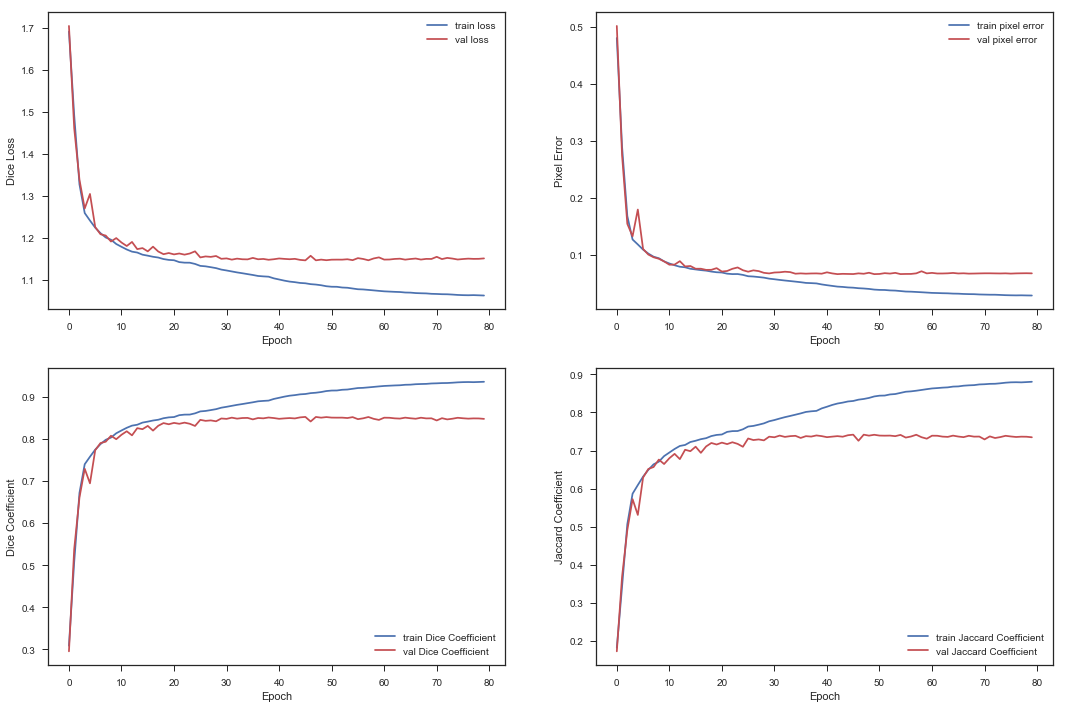

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].plot(results.epoch, [x + 1 for x in results.history['ofuse_loss']], 'b-', label='train loss')
ax[0, 0].plot(results.epoch, [x + 1 for x in results.history['val_ofuse_loss']], 'r-', label='val loss')
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Dice Loss')
ax[0, 1].plot(results.epoch, results.history['ofuse_pixel_error'], 'b-', label='train pixel error')
ax[0, 1].plot(results.epoch, results.history['val_ofuse_pixel_error'], 'r-', label='val pixel error')
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Pixel Error')
ax[1, 0].plot(results.epoch, results.history['ofuse_dice_coef'], 'b-', label='train Dice Coefficient')
ax[1, 0].plot(results.epoch, results.history['val_ofuse_dice_coef'], 'r-', label='val Dice Coefficient')
ax[1, 0].legend(loc='lower right')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Dice Coefficient')
ax[1, 1].plot(results.epoch, results.history['ofuse_jaccard_coef'], 'b-', label='train Jaccard Coefficient')
ax[1, 1].plot(results.epoch, results.history['val_ofuse_jaccard_coef'], 'r-', label='val Jaccard Coefficient')
ax[1, 1].legend(loc='lower right')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Jaccard Coefficient')
plt.show()

In [20]:
np.save(RESULT_PATH + 'history_Unet_fuse_v3.npy', results.history)

In [12]:
model_unet_fuse_v3.save_weights(WEIGHT_PATH + 'UNET_fuse_v3.2_weight.h5')
model_unet_fuse_v3.save(MODEL_PATH + 'UNET_fuse_v3.2_model.h5')
model_json = model_unet_fuse_v3.to_json()
with open(MODEL_PATH + 'UNET_fuse_v3.2_model.json', "w") as json_file:
    json_file.write(model_json)

In [13]:
model_unet_fuse_v3 = u_net_fuse_v3(input_shape=(512, 512, 1))
model_unet_fuse_v3.load_weights(WEIGHT_PATH + 'UNET_fuse_v3.2_weight.h5')

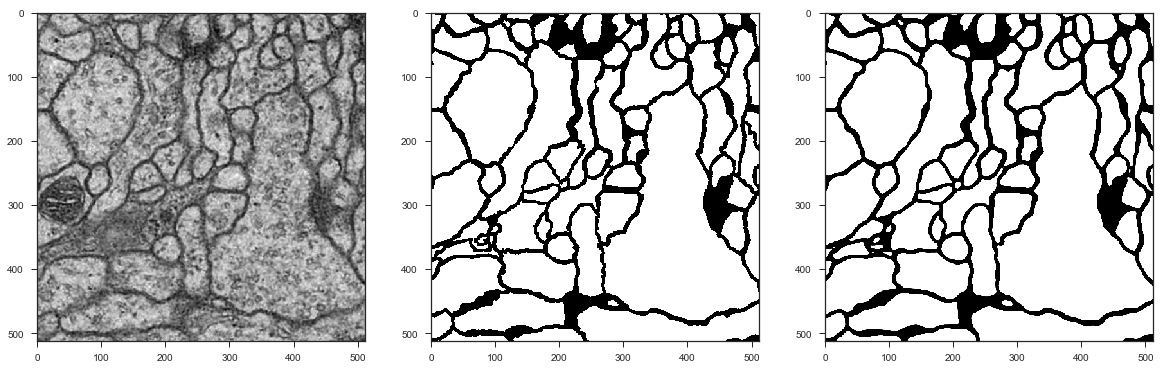

In [14]:
y_pred = model_unet_fuse_v3.predict(X_train[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(X_train[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_train[0].reshape((512, 512)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')

plt.show()

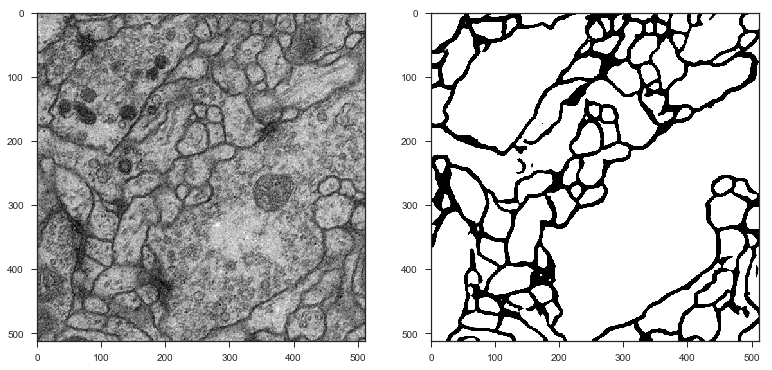

In [18]:
y_pred = model_unet_fuse_v3.predict(X_test[3].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test[3].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_pred, cmap='binary')
plt.show()

In [21]:
y_pred = model_unet_fuse_v3.predict(X_test, batch_size=5)
result_fuse = (1 - y_pred[-1]).astype(np.float32)
result_fuse.shape

(30, 512, 512, 1)

In [22]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v3.2_' + timestamp + '.tif', result_fuse, dtype=np.float32)
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v3.2_' + timestamp + '.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

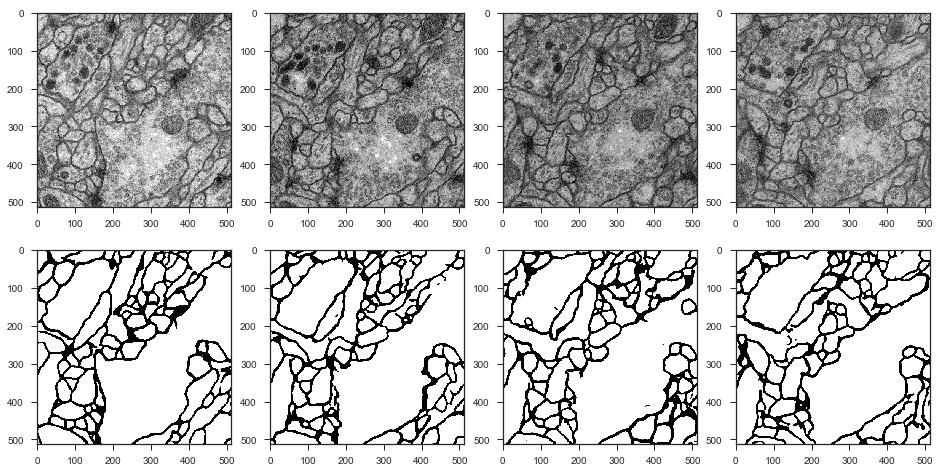

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='gray')

plt.show()

Use Dice Loss

In [61]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.8, patience=5, verbose=1, 
                             min_lr=1e-4)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, 
                               save_best_only=True, monitor='val_ofuse_pixel_error')
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v3', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_side_fuse.compile(loss={'o1': dice_coef_loss,
                                'o2': dice_coef_loss,
                                'o3': dice_coef_loss,
                                'o4': dice_coef_loss,
                                'o5': dice_coef_loss,
                                'ofuse': dice_coef_loss,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error]},
                          optimizer=optimizer)

results = model_unet_side_fuse.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=100, callbacks=callback_list, verbose=2)

Train on 189 samples, validate on 21 samples


Epoch 1/100


 - 13s - loss: -2.2783e+00 - o1_loss: -3.5778e-01 - o2_loss: -3.5884e-01 - o3_loss: -3.7016e-01 - o4_loss: -3.4754e-01 - o5_loss: -4.6749e-01 - ofuse_loss: -3.7644e-01 - ofuse_dice_coef: 0.3764 - ofuse_jaccard_coef: 0.2315 - ofuse_pixel_error: 0.4294 - val_loss: -2.1673e+00 - val_o1_loss: -2.5200e-01 - val_o2_loss: -3.4042e-01 - val_o3_loss: -3.9791e-01 - val_o4_loss: -3.9131e-01 - val_o5_loss: -3.9534e-01 - val_ofuse_loss: -3.9033e-01 - val_ofuse_dice_coef: 0.3903 - val_ofuse_jaccard_coef: 0.2416 - val_ofuse_pixel_error: 0.2631



Epoch 00001: val_ofuse_pixel_error improved from inf to 0.26310, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/100


 - 12s - loss: -3.0457e+00 - o1_loss: -4.4470e-01 - o2_loss: -4.6941e-01 - o3_loss: -5.0383e-01 - o4_loss: -4.8153e-01 - o5_loss: -6.1134e-01 - ofuse_loss: -5.3490e-01 - ofuse_dice_coef: 0.5349 - ofuse_jaccard_coef: 0.3647 - ofuse_pixel_error: 0.2793 - val_loss: -2.8271e+00 - val_o1_loss: -3.5468e-01 - val_o2_loss: -3.9092e-01 - val_o3_loss: -4.6652e-01 - val_o4_loss: -5.0681e-01 - val_o5_loss: -5.7405e-01 - val_ofuse_loss: -5.3413e-01 - val_ofuse_dice_coef: 0.5341 - val_ofuse_jaccard_coef: 0.3609 - val_ofuse_pixel_error: 0.1591



Epoch 00002: val_ofuse_pixel_error improved from 0.26310 to 0.15909, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/100


 - 12s - loss: -3.5980e+00 - o1_loss: -4.7911e-01 - o2_loss: -5.2910e-01 - o3_loss: -5.9476e-01 - o4_loss: -6.2503e-01 - o5_loss: -7.1124e-01 - ofuse_loss: -6.5876e-01 - ofuse_dice_coef: 0.6588 - ofuse_jaccard_coef: 0.4901 - ofuse_pixel_error: 0.1774 - val_loss: -3.5472e+00 - val_o1_loss: -4.7851e-01 - val_o2_loss: -5.4983e-01 - val_o3_loss: -5.6675e-01 - val_o4_loss: -6.3711e-01 - val_o5_loss: -6.6365e-01 - val_ofuse_loss: -6.5134e-01 - val_ofuse_dice_coef: 0.6513 - val_ofuse_jaccard_coef: 0.4802 - val_ofuse_pixel_error: 0.1248



Epoch 00003: val_ofuse_pixel_error improved from 0.15909 to 0.12479, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 4/100


 - 12s - loss: -3.9321e+00 - o1_loss: -5.0091e-01 - o2_loss: -5.7878e-01 - o3_loss: -6.4673e-01 - o4_loss: -7.1194e-01 - o5_loss: -7.6437e-01 - ofuse_loss: -7.2938e-01 - ofuse_dice_coef: 0.7294 - ofuse_jaccard_coef: 0.5730 - ofuse_pixel_error: 0.1294 - val_loss: -3.9780e+00 - val_o1_loss: -5.0791e-01 - val_o2_loss: -6.1006e-01 - val_o3_loss: -6.6002e-01 - val_o4_loss: -7.2075e-01 - val_o5_loss: -7.4351e-01 - val_ofuse_loss: -7.3572e-01 - val_ofuse_dice_coef: 0.7357 - val_ofuse_jaccard_coef: 0.5794 - val_ofuse_pixel_error: 0.1139



Epoch 00004: val_ofuse_pixel_error improved from 0.12479 to 0.11394, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 5/100


 - 12s - loss: -4.1126e+00 - o1_loss: -5.1146e-01 - o2_loss: -6.1412e-01 - o3_loss: -6.8199e-01 - o4_loss: -7.5024e-01 - o5_loss: -7.8765e-01 - ofuse_loss: -7.6713e-01 - ofuse_dice_coef: 0.7671 - ofuse_jaccard_coef: 0.6212 - ofuse_pixel_error: 0.1093 - val_loss: -4.1259e+00 - val_o1_loss: -5.0907e-01 - val_o2_loss: -6.3663e-01 - val_o3_loss: -6.9498e-01 - val_o4_loss: -7.5749e-01 - val_o5_loss: -7.6752e-01 - val_ofuse_loss: -7.6020e-01 - val_ofuse_dice_coef: 0.7602 - val_ofuse_jaccard_coef: 0.6101 - val_ofuse_pixel_error: 0.1016



Epoch 00005: val_ofuse_pixel_error improved from 0.11394 to 0.10155, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 6/100


 - 12s - loss: -4.2363e+00 - o1_loss: -5.1935e-01 - o2_loss: -6.3793e-01 - o3_loss: -7.1373e-01 - o4_loss: -7.7217e-01 - o5_loss: -8.0268e-01 - ofuse_loss: -7.9042e-01 - ofuse_dice_coef: 0.7904 - ofuse_jaccard_coef: 0.6525 - ofuse_pixel_error: 0.0981 - val_loss: -4.0604e+00 - val_o1_loss: -5.2412e-01 - val_o2_loss: -6.4753e-01 - val_o3_loss: -6.9014e-01 - val_o4_loss: -7.3120e-01 - val_o5_loss: -7.3609e-01 - val_ofuse_loss: -7.3130e-01 - val_ofuse_dice_coef: 0.7313 - val_ofuse_jaccard_coef: 0.5763 - val_ofuse_pixel_error: 0.1434



Epoch 00006: val_ofuse_pixel_error did not improve
Epoch 7/100


 - 12s - loss: -4.3065e+00 - o1_loss: -5.2367e-01 - o2_loss: -6.5146e-01 - o3_loss: -7.3556e-01 - o4_loss: -7.8437e-01 - o5_loss: -8.0962e-01 - ofuse_loss: -8.0181e-01 - ofuse_dice_coef: 0.8018 - ofuse_jaccard_coef: 0.6680 - ofuse_pixel_error: 0.0932 - val_loss: -4.2694e+00 - val_o1_loss: -5.2712e-01 - val_o2_loss: -6.5939e-01 - val_o3_loss: -7.4210e-01 - val_o4_loss: -7.7527e-01 - val_o5_loss: -7.8274e-01 - val_ofuse_loss: -7.8281e-01 - val_ofuse_dice_coef: 0.7828 - val_ofuse_jaccard_coef: 0.6416 - val_ofuse_pixel_error: 0.1069



Epoch 00007: val_ofuse_pixel_error did not improve
Epoch 8/100


 - 13s - loss: -4.3586e+00 - o1_loss: -5.2751e-01 - o2_loss: -6.5958e-01 - o3_loss: -7.5286e-01 - o4_loss: -7.9356e-01 - o5_loss: -8.1480e-01 - ofuse_loss: -8.1028e-01 - ofuse_dice_coef: 0.8103 - ofuse_jaccard_coef: 0.6799 - ofuse_pixel_error: 0.0889 - val_loss: -4.3901e+00 - val_o1_loss: -5.2871e-01 - val_o2_loss: -6.7326e-01 - val_o3_loss: -7.7010e-01 - val_o4_loss: -8.0029e-01 - val_o5_loss: -8.0899e-01 - val_ofuse_loss: -8.0877e-01 - val_ofuse_dice_coef: 0.8088 - val_ofuse_jaccard_coef: 0.6762 - val_ofuse_pixel_error: 0.0896



Epoch 00008: val_ofuse_pixel_error improved from 0.10155 to 0.08960, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 9/100


 - 12s - loss: -4.3897e+00 - o1_loss: -5.2985e-01 - o2_loss: -6.6488e-01 - o3_loss: -7.6372e-01 - o4_loss: -7.9919e-01 - o5_loss: -8.1751e-01 - ofuse_loss: -8.1457e-01 - ofuse_dice_coef: 0.8146 - ofuse_jaccard_coef: 0.6864 - ofuse_pixel_error: 0.0869 - val_loss: -4.4284e+00 - val_o1_loss: -5.3443e-01 - val_o2_loss: -6.7438e-01 - val_o3_loss: -7.7470e-01 - val_o4_loss: -8.0683e-01 - val_o5_loss: -8.1794e-01 - val_ofuse_loss: -8.2011e-01 - val_ofuse_dice_coef: 0.8201 - val_ofuse_jaccard_coef: 0.6920 - val_ofuse_pixel_error: 0.0788



Epoch 00009: val_ofuse_pixel_error improved from 0.08960 to 0.07882, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 10/100


 - 12s - loss: -4.4269e+00 - o1_loss: -5.3362e-01 - o2_loss: -6.7119e-01 - o3_loss: -7.7365e-01 - o4_loss: -8.0648e-01 - o5_loss: -8.2204e-01 - ofuse_loss: -8.1987e-01 - ofuse_dice_coef: 0.8199 - ofuse_jaccard_coef: 0.6937 - ofuse_pixel_error: 0.0844 - val_loss: -4.4390e+00 - val_o1_loss: -5.3563e-01 - val_o2_loss: -6.7392e-01 - val_o3_loss: -7.7981e-01 - val_o4_loss: -8.0915e-01 - val_o5_loss: -8.1944e-01 - val_ofuse_loss: -8.2110e-01 - val_ofuse_dice_coef: 0.8211 - val_ofuse_jaccard_coef: 0.6939 - val_ofuse_pixel_error: 0.0780



Epoch 00010: val_ofuse_pixel_error improved from 0.07882 to 0.07798, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 11/100


 - 12s - loss: -4.4661e+00 - o1_loss: -5.3774e-01 - o2_loss: -6.7798e-01 - o3_loss: -7.8323e-01 - o4_loss: -8.1393e-01 - o5_loss: -8.2733e-01 - ofuse_loss: -8.2593e-01 - ofuse_dice_coef: 0.8259 - ofuse_jaccard_coef: 0.7024 - ofuse_pixel_error: 0.0814 - val_loss: -4.4215e+00 - val_o1_loss: -5.1123e-01 - val_o2_loss: -6.7094e-01 - val_o3_loss: -7.8312e-01 - val_o4_loss: -8.1340e-01 - val_o5_loss: -8.2090e-01 - val_ofuse_loss: -8.2194e-01 - val_ofuse_dice_coef: 0.8219 - val_ofuse_jaccard_coef: 0.6952 - val_ofuse_pixel_error: 0.0790



Epoch 00011: val_ofuse_pixel_error did not improve
Epoch 12/100


 - 12s - loss: -4.4892e+00 - o1_loss: -5.4022e-01 - o2_loss: -6.8140e-01 - o3_loss: -7.8913e-01 - o4_loss: -8.1878e-01 - o5_loss: -8.3048e-01 - ofuse_loss: -8.2920e-01 - ofuse_dice_coef: 0.8292 - ofuse_jaccard_coef: 0.7072 - ofuse_pixel_error: 0.0799 - val_loss: -4.4144e+00 - val_o1_loss: -5.3496e-01 - val_o2_loss: -6.7851e-01 - val_o3_loss: -7.7704e-01 - val_o4_loss: -8.0181e-01 - val_o5_loss: -8.1058e-01 - val_ofuse_loss: -8.1154e-01 - val_ofuse_dice_coef: 0.8115 - val_ofuse_jaccard_coef: 0.6804 - val_ofuse_pixel_error: 0.0799



Epoch 00012: val_ofuse_pixel_error did not improve
Epoch 13/100


 - 12s - loss: -4.5081e+00 - o1_loss: -5.4214e-01 - o2_loss: -6.8459e-01 - o3_loss: -7.9433e-01 - o4_loss: -8.2249e-01 - o5_loss: -8.3263e-01 - ofuse_loss: -8.3193e-01 - ofuse_dice_coef: 0.8319 - ofuse_jaccard_coef: 0.7112 - ofuse_pixel_error: 0.0785 - val_loss: -4.4991e+00 - val_o1_loss: -5.4302e-01 - val_o2_loss: -6.9383e-01 - val_o3_loss: -7.9444e-01 - val_o4_loss: -8.1876e-01 - val_o5_loss: -8.2428e-01 - val_ofuse_loss: -8.2474e-01 - val_ofuse_dice_coef: 0.8247 - val_ofuse_jaccard_coef: 0.6992 - val_ofuse_pixel_error: 0.0822



Epoch 00013: val_ofuse_pixel_error did not improve
Epoch 14/100


 - 12s - loss: -4.5296e+00 - o1_loss: -5.4388e-01 - o2_loss: -6.8820e-01 - o3_loss: -7.9901e-01 - o4_loss: -8.2714e-01 - o5_loss: -8.3612e-01 - ofuse_loss: -8.3527e-01 - ofuse_dice_coef: 0.8353 - ofuse_jaccard_coef: 0.7158 - ofuse_pixel_error: 0.0769 - val_loss: -4.4983e+00 - val_o1_loss: -5.3773e-01 - val_o2_loss: -6.8613e-01 - val_o3_loss: -7.9706e-01 - val_o4_loss: -8.2122e-01 - val_o5_loss: -8.2835e-01 - val_ofuse_loss: -8.2780e-01 - val_ofuse_dice_coef: 0.8278 - val_ofuse_jaccard_coef: 0.7034 - val_ofuse_pixel_error: 0.0759



Epoch 00014: val_ofuse_pixel_error improved from 0.07798 to 0.07595, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 15/100


 - 12s - loss: -4.5438e+00 - o1_loss: -5.4539e-01 - o2_loss: -6.9058e-01 - o3_loss: -8.0286e-01 - o4_loss: -8.2990e-01 - o5_loss: -8.3770e-01 - ofuse_loss: -8.3741e-01 - ofuse_dice_coef: 0.8374 - ofuse_jaccard_coef: 0.7191 - ofuse_pixel_error: 0.0758 - val_loss: -4.5055e+00 - val_o1_loss: -5.3688e-01 - val_o2_loss: -6.8867e-01 - val_o3_loss: -7.9888e-01 - val_o4_loss: -8.2268e-01 - val_o5_loss: -8.2899e-01 - val_ofuse_loss: -8.2939e-01 - val_ofuse_dice_coef: 0.8294 - val_ofuse_jaccard_coef: 0.7063 - val_ofuse_pixel_error: 0.0745



Epoch 00015: val_ofuse_pixel_error improved from 0.07595 to 0.07450, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 16/100


 - 12s - loss: -4.5576e+00 - o1_loss: -5.4574e-01 - o2_loss: -6.9279e-01 - o3_loss: -8.0577e-01 - o4_loss: -8.3330e-01 - o5_loss: -8.4039e-01 - ofuse_loss: -8.3964e-01 - ofuse_dice_coef: 0.8396 - ofuse_jaccard_coef: 0.7227 - ofuse_pixel_error: 0.0748 - val_loss: -4.5520e+00 - val_o1_loss: -5.4770e-01 - val_o2_loss: -6.9711e-01 - val_o3_loss: -7.9966e-01 - val_o4_loss: -8.3225e-01 - val_o5_loss: -8.3827e-01 - val_ofuse_loss: -8.3697e-01 - val_ofuse_dice_coef: 0.8370 - val_ofuse_jaccard_coef: 0.7173 - val_ofuse_pixel_error: 0.0711



Epoch 00016: val_ofuse_pixel_error improved from 0.07450 to 0.07113, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 17/100


 - 12s - loss: -4.5682e+00 - o1_loss: -5.4736e-01 - o2_loss: -6.9529e-01 - o3_loss: -8.0756e-01 - o4_loss: -8.3551e-01 - o5_loss: -8.4144e-01 - ofuse_loss: -8.4101e-01 - ofuse_dice_coef: 0.8410 - ofuse_jaccard_coef: 0.7247 - ofuse_pixel_error: 0.0739 - val_loss: -4.5524e+00 - val_o1_loss: -5.4368e-01 - val_o2_loss: -7.0172e-01 - val_o3_loss: -8.0929e-01 - val_o4_loss: -8.2896e-01 - val_o5_loss: -8.3392e-01 - val_ofuse_loss: -8.3484e-01 - val_ofuse_dice_coef: 0.8348 - val_ofuse_jaccard_coef: 0.7141 - val_ofuse_pixel_error: 0.0722



Epoch 00017: val_ofuse_pixel_error did not improve
Epoch 18/100


 - 12s - loss: -4.5881e+00 - o1_loss: -5.4953e-01 - o2_loss: -6.9823e-01 - o3_loss: -8.1160e-01 - o4_loss: -8.3941e-01 - o5_loss: -8.4507e-01 - ofuse_loss: -8.4425e-01 - ofuse_dice_coef: 0.8442 - ofuse_jaccard_coef: 0.7293 - ofuse_pixel_error: 0.0724 - val_loss: -4.5813e+00 - val_o1_loss: -5.4526e-01 - val_o2_loss: -7.0590e-01 - val_o3_loss: -8.1308e-01 - val_o4_loss: -8.3704e-01 - val_o5_loss: -8.4026e-01 - val_ofuse_loss: -8.3979e-01 - val_ofuse_dice_coef: 0.8398 - val_ofuse_jaccard_coef: 0.7209 - val_ofuse_pixel_error: 0.0716



Epoch 00018: val_ofuse_pixel_error did not improve
Epoch 19/100


 - 12s - loss: -4.6115e+00 - o1_loss: -5.5241e-01 - o2_loss: -7.0220e-01 - o3_loss: -8.1605e-01 - o4_loss: -8.4392e-01 - o5_loss: -8.4870e-01 - ofuse_loss: -8.4821e-01 - ofuse_dice_coef: 0.8482 - ofuse_jaccard_coef: 0.7354 - ofuse_pixel_error: 0.0704 - val_loss: -4.5641e+00 - val_o1_loss: -5.5103e-01 - val_o2_loss: -7.0162e-01 - val_o3_loss: -8.0821e-01 - val_o4_loss: -8.3243e-01 - val_o5_loss: -8.3556e-01 - val_ofuse_loss: -8.3522e-01 - val_ofuse_dice_coef: 0.8352 - val_ofuse_jaccard_coef: 0.7139 - val_ofuse_pixel_error: 0.0725



Epoch 00019: val_ofuse_pixel_error did not improve
Epoch 20/100


 - 12s - loss: -4.6149e+00 - o1_loss: -5.5261e-01 - o2_loss: -7.0226e-01 - o3_loss: -8.1631e-01 - o4_loss: -8.4532e-01 - o5_loss: -8.4965e-01 - ofuse_loss: -8.4874e-01 - ofuse_dice_coef: 0.8487 - ofuse_jaccard_coef: 0.7361 - ofuse_pixel_error: 0.0703 - val_loss: -4.6012e+00 - val_o1_loss: -5.5416e-01 - val_o2_loss: -7.0710e-01 - val_o3_loss: -8.1394e-01 - val_o4_loss: -8.4021e-01 - val_o5_loss: -8.4345e-01 - val_ofuse_loss: -8.4232e-01 - val_ofuse_dice_coef: 0.8423 - val_ofuse_jaccard_coef: 0.7244 - val_ofuse_pixel_error: 0.0699



Epoch 00020: val_ofuse_pixel_error improved from 0.07113 to 0.06989, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 21/100


 - 11s - loss: -4.6229e+00 - o1_loss: -5.5317e-01 - o2_loss: -7.0317e-01 - o3_loss: -8.1874e-01 - o4_loss: -8.4691e-01 - o5_loss: -8.5079e-01 - ofuse_loss: -8.5014e-01 - ofuse_dice_coef: 0.8501 - ofuse_jaccard_coef: 0.7383 - ofuse_pixel_error: 0.0695 - val_loss: -4.6194e+00 - val_o1_loss: -5.5278e-01 - val_o2_loss: -7.0706e-01 - val_o3_loss: -8.2099e-01 - val_o4_loss: -8.4450e-01 - val_o5_loss: -8.4706e-01 - val_ofuse_loss: -8.4700e-01 - val_ofuse_dice_coef: 0.8470 - val_ofuse_jaccard_coef: 0.7319 - val_ofuse_pixel_error: 0.0695



Epoch 00021: val_ofuse_pixel_error improved from 0.06989 to 0.06948, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 22/100


 - 11s - loss: -4.6416e+00 - o1_loss: -5.5475e-01 - o2_loss: -7.0642e-01 - o3_loss: -8.2238e-01 - o4_loss: -8.5035e-01 - o5_loss: -8.5421e-01 - ofuse_loss: -8.5350e-01 - ofuse_dice_coef: 0.8535 - ofuse_jaccard_coef: 0.7434 - ofuse_pixel_error: 0.0678 - val_loss: -4.6275e+00 - val_o1_loss: -5.5520e-01 - val_o2_loss: -7.1188e-01 - val_o3_loss: -8.2060e-01 - val_o4_loss: -8.4510e-01 - val_o5_loss: -8.4812e-01 - val_ofuse_loss: -8.4661e-01 - val_ofuse_dice_coef: 0.8466 - val_ofuse_jaccard_coef: 0.7312 - val_ofuse_pixel_error: 0.0691



Epoch 00022: val_ofuse_pixel_error improved from 0.06948 to 0.06912, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 23/100


 - 11s - loss: -4.6589e+00 - o1_loss: -5.5667e-01 - o2_loss: -7.0922e-01 - o3_loss: -8.2525e-01 - o4_loss: -8.5367e-01 - o5_loss: -8.5757e-01 - ofuse_loss: -8.5655e-01 - ofuse_dice_coef: 0.8566 - ofuse_jaccard_coef: 0.7480 - ofuse_pixel_error: 0.0665 - val_loss: -4.6120e+00 - val_o1_loss: -5.5472e-01 - val_o2_loss: -7.1088e-01 - val_o3_loss: -8.1684e-01 - val_o4_loss: -8.4182e-01 - val_o5_loss: -8.4496e-01 - val_ofuse_loss: -8.4281e-01 - val_ofuse_dice_coef: 0.8428 - val_ofuse_jaccard_coef: 0.7253 - val_ofuse_pixel_error: 0.0703



Epoch 00023: val_ofuse_pixel_error did not improve
Epoch 24/100


 - 12s - loss: -4.6702e+00 - o1_loss: -5.5821e-01 - o2_loss: -7.1092e-01 - o3_loss: -8.2757e-01 - o4_loss: -8.5566e-01 - o5_loss: -8.5927e-01 - ofuse_loss: -8.5861e-01 - ofuse_dice_coef: 0.8586 - ofuse_jaccard_coef: 0.7513 - ofuse_pixel_error: 0.0654 - val_loss: -4.6283e+00 - val_o1_loss: -5.5360e-01 - val_o2_loss: -7.1403e-01 - val_o3_loss: -8.1706e-01 - val_o4_loss: -8.4610e-01 - val_o5_loss: -8.4996e-01 - val_ofuse_loss: -8.4756e-01 - val_ofuse_dice_coef: 0.8476 - val_ofuse_jaccard_coef: 0.7325 - val_ofuse_pixel_error: 0.0661



Epoch 00024: val_ofuse_pixel_error improved from 0.06912 to 0.06610, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 25/100


 - 12s - loss: -4.6857e+00 - o1_loss: -5.5914e-01 - o2_loss: -7.1344e-01 - o3_loss: -8.3035e-01 - o4_loss: -8.5884e-01 - o5_loss: -8.6251e-01 - ofuse_loss: -8.6145e-01 - ofuse_dice_coef: 0.8614 - ofuse_jaccard_coef: 0.7557 - ofuse_pixel_error: 0.0642 - val_loss: -4.6013e+00 - val_o1_loss: -5.4003e-01 - val_o2_loss: -7.0032e-01 - val_o3_loss: -8.2177e-01 - val_o4_loss: -8.4489e-01 - val_o5_loss: -8.4743e-01 - val_ofuse_loss: -8.4687e-01 - val_ofuse_dice_coef: 0.8469 - val_ofuse_jaccard_coef: 0.7316 - val_ofuse_pixel_error: 0.0665



Epoch 00025: val_ofuse_pixel_error did not improve
Epoch 26/100


 - 12s - loss: -4.6953e+00 - o1_loss: -5.5993e-01 - o2_loss: -7.1484e-01 - o3_loss: -8.3240e-01 - o4_loss: -8.6062e-01 - o5_loss: -8.6417e-01 - ofuse_loss: -8.6333e-01 - ofuse_dice_coef: 0.8633 - ofuse_jaccard_coef: 0.7585 - ofuse_pixel_error: 0.0631 - val_loss: -4.5880e+00 - val_o1_loss: -5.5407e-01 - val_o2_loss: -7.0805e-01 - val_o3_loss: -8.0901e-01 - val_o4_loss: -8.3741e-01 - val_o5_loss: -8.4077e-01 - val_ofuse_loss: -8.3864e-01 - val_ofuse_dice_coef: 0.8386 - val_ofuse_jaccard_coef: 0.7192 - val_ofuse_pixel_error: 0.0688



Epoch 00026: val_ofuse_pixel_error did not improve
Epoch 27/100


 - 11s - loss: -4.7024e+00 - o1_loss: -5.6093e-01 - o2_loss: -7.1548e-01 - o3_loss: -8.3376e-01 - o4_loss: -8.6204e-01 - o5_loss: -8.6552e-01 - ofuse_loss: -8.6469e-01 - ofuse_dice_coef: 0.8647 - ofuse_jaccard_coef: 0.7606 - ofuse_pixel_error: 0.0625 - val_loss: -4.6308e+00 - val_o1_loss: -5.5790e-01 - val_o2_loss: -7.1064e-01 - val_o3_loss: -8.2103e-01 - val_o4_loss: -8.4569e-01 - val_o5_loss: -8.4898e-01 - val_ofuse_loss: -8.4652e-01 - val_ofuse_dice_coef: 0.8465 - val_ofuse_jaccard_coef: 0.7308 - val_ofuse_pixel_error: 0.0694



Epoch 00027: val_ofuse_pixel_error did not improve
Epoch 28/100


 - 11s - loss: -4.7134e+00 - o1_loss: -5.6179e-01 - o2_loss: -7.1688e-01 - o3_loss: -8.3568e-01 - o4_loss: -8.6437e-01 - o5_loss: -8.6774e-01 - ofuse_loss: -8.6692e-01 - ofuse_dice_coef: 0.8669 - ofuse_jaccard_coef: 0.7639 - ofuse_pixel_error: 0.0614 - val_loss: -4.5729e+00 - val_o1_loss: -5.5072e-01 - val_o2_loss: -7.0769e-01 - val_o3_loss: -8.0187e-01 - val_o4_loss: -8.3687e-01 - val_o5_loss: -8.3925e-01 - val_ofuse_loss: -8.3654e-01 - val_ofuse_dice_coef: 0.8365 - val_ofuse_jaccard_coef: 0.7161 - val_ofuse_pixel_error: 0.0679



Epoch 00028: val_ofuse_pixel_error did not improve
Epoch 29/100


 - 11s - loss: -4.7062e+00 - o1_loss: -5.6210e-01 - o2_loss: -7.1664e-01 - o3_loss: -8.3413e-01 - o4_loss: -8.6256e-01 - o5_loss: -8.6567e-01 - ofuse_loss: -8.6506e-01 - ofuse_dice_coef: 0.8651 - ofuse_jaccard_coef: 0.7612 - ofuse_pixel_error: 0.0622 - val_loss: -4.6442e+00 - val_o1_loss: -5.5729e-01 - val_o2_loss: -7.1359e-01 - val_o3_loss: -8.2482e-01 - val_o4_loss: -8.4787e-01 - val_o5_loss: -8.5088e-01 - val_ofuse_loss: -8.4978e-01 - val_ofuse_dice_coef: 0.8498 - val_ofuse_jaccard_coef: 0.7363 - val_ofuse_pixel_error: 0.0666



Epoch 00029: val_ofuse_pixel_error did not improve
Epoch 30/100


 - 11s - loss: -4.7231e+00 - o1_loss: -5.6222e-01 - o2_loss: -7.1858e-01 - o3_loss: -8.3775e-01 - o4_loss: -8.6626e-01 - o5_loss: -8.6950e-01 - ofuse_loss: -8.6879e-01 - ofuse_dice_coef: 0.8688 - ofuse_jaccard_coef: 0.7670 - ofuse_pixel_error: 0.0604 - val_loss: -4.6490e+00 - val_o1_loss: -5.5955e-01 - val_o2_loss: -7.1862e-01 - val_o3_loss: -8.2603e-01 - val_o4_loss: -8.4715e-01 - val_o5_loss: -8.4926e-01 - val_ofuse_loss: -8.4840e-01 - val_ofuse_dice_coef: 0.8484 - val_ofuse_jaccard_coef: 0.7344 - val_ofuse_pixel_error: 0.0689



Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.000800000037998.

Epoch 00030: val_ofuse_pixel_error did not improve
Epoch 31/100


 - 11s - loss: -4.7544e+00 - o1_loss: -5.6523e-01 - o2_loss: -7.2276e-01 - o3_loss: -8.4363e-01 - o4_loss: -8.7238e-01 - o5_loss: -8.7548e-01 - ofuse_loss: -8.7490e-01 - ofuse_dice_coef: 0.8749 - ofuse_jaccard_coef: 0.7765 - ofuse_pixel_error: 0.0576 - val_loss: -4.6567e+00 - val_o1_loss: -5.6121e-01 - val_o2_loss: -7.1969e-01 - val_o3_loss: -8.2774e-01 - val_o4_loss: -8.4814e-01 - val_o5_loss: -8.4997e-01 - val_ofuse_loss: -8.4993e-01 - val_ofuse_dice_coef: 0.8499 - val_ofuse_jaccard_coef: 0.7370 - val_ofuse_pixel_error: 0.0673



Epoch 00031: val_ofuse_pixel_error did not improve
Epoch 32/100


 - 11s - loss: -4.7705e+00 - o1_loss: -5.6608e-01 - o2_loss: -7.2447e-01 - o3_loss: -8.4653e-01 - o4_loss: -8.7589e-01 - o5_loss: -8.7907e-01 - ofuse_loss: -8.7849e-01 - ofuse_dice_coef: 0.8785 - ofuse_jaccard_coef: 0.7822 - ofuse_pixel_error: 0.0558 - val_loss: -4.6703e+00 - val_o1_loss: -5.6127e-01 - val_o2_loss: -7.2078e-01 - val_o3_loss: -8.3055e-01 - val_o4_loss: -8.5130e-01 - val_o5_loss: -8.5373e-01 - val_ofuse_loss: -8.5268e-01 - val_ofuse_dice_coef: 0.8527 - val_ofuse_jaccard_coef: 0.7408 - val_ofuse_pixel_error: 0.0671



Epoch 00032: val_ofuse_pixel_error did not improve
Epoch 33/100


 - 11s - loss: -4.7813e+00 - o1_loss: -5.6707e-01 - o2_loss: -7.2578e-01 - o3_loss: -8.4859e-01 - o4_loss: -8.7807e-01 - o5_loss: -8.8120e-01 - ofuse_loss: -8.8064e-01 - ofuse_dice_coef: 0.8806 - ofuse_jaccard_coef: 0.7858 - ofuse_pixel_error: 0.0548 - val_loss: -4.6470e+00 - val_o1_loss: -5.5954e-01 - val_o2_loss: -7.1941e-01 - val_o3_loss: -8.2429e-01 - val_o4_loss: -8.4564e-01 - val_o5_loss: -8.4910e-01 - val_ofuse_loss: -8.4904e-01 - val_ofuse_dice_coef: 0.8490 - val_ofuse_jaccard_coef: 0.7350 - val_ofuse_pixel_error: 0.0651



Epoch 00033: val_ofuse_pixel_error improved from 0.06610 to 0.06507, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 34/100


 - 11s - loss: -4.7844e+00 - o1_loss: -5.6752e-01 - o2_loss: -7.2576e-01 - o3_loss: -8.4891e-01 - o4_loss: -8.7885e-01 - o5_loss: -8.8190e-01 - ofuse_loss: -8.8150e-01 - ofuse_dice_coef: 0.8815 - ofuse_jaccard_coef: 0.7872 - ofuse_pixel_error: 0.0543 - val_loss: -4.6696e+00 - val_o1_loss: -5.6184e-01 - val_o2_loss: -7.2032e-01 - val_o3_loss: -8.3029e-01 - val_o4_loss: -8.5111e-01 - val_o5_loss: -8.5358e-01 - val_ofuse_loss: -8.5250e-01 - val_ofuse_dice_coef: 0.8525 - val_ofuse_jaccard_coef: 0.7405 - val_ofuse_pixel_error: 0.0672



Epoch 00034: val_ofuse_pixel_error did not improve
Epoch 35/100


 - 11s - loss: -4.8013e+00 - o1_loss: -5.6811e-01 - o2_loss: -7.2779e-01 - o3_loss: -8.5225e-01 - o4_loss: -8.8244e-01 - o5_loss: -8.8560e-01 - ofuse_loss: -8.8507e-01 - ofuse_dice_coef: 0.8851 - ofuse_jaccard_coef: 0.7926 - ofuse_pixel_error: 0.0526 - val_loss: -4.6731e+00 - val_o1_loss: -5.6035e-01 - val_o2_loss: -7.2115e-01 - val_o3_loss: -8.3023e-01 - val_o4_loss: -8.5248e-01 - val_o5_loss: -8.5510e-01 - val_ofuse_loss: -8.5384e-01 - val_ofuse_dice_coef: 0.8538 - val_ofuse_jaccard_coef: 0.7423 - val_ofuse_pixel_error: 0.0654



Epoch 00035: val_ofuse_pixel_error did not improve
Epoch 36/100


 - 12s - loss: -4.8045e+00 - o1_loss: -5.6875e-01 - o2_loss: -7.2823e-01 - o3_loss: -8.5263e-01 - o4_loss: -8.8304e-01 - o5_loss: -8.8620e-01 - ofuse_loss: -8.8563e-01 - ofuse_dice_coef: 0.8856 - ofuse_jaccard_coef: 0.7938 - ofuse_pixel_error: 0.0523 - val_loss: -4.6698e+00 - val_o1_loss: -5.6122e-01 - val_o2_loss: -7.2004e-01 - val_o3_loss: -8.2984e-01 - val_o4_loss: -8.5143e-01 - val_o5_loss: -8.5376e-01 - val_ofuse_loss: -8.5355e-01 - val_ofuse_dice_coef: 0.8535 - val_ofuse_jaccard_coef: 0.7420 - val_ofuse_pixel_error: 0.0644



Epoch 00036: val_ofuse_pixel_error improved from 0.06507 to 0.06444, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 37/100


 - 11s - loss: -4.8114e+00 - o1_loss: -5.6879e-01 - o2_loss: -7.2847e-01 - o3_loss: -8.5389e-01 - o4_loss: -8.8487e-01 - o5_loss: -8.8796e-01 - ofuse_loss: -8.8746e-01 - ofuse_dice_coef: 0.8875 - ofuse_jaccard_coef: 0.7965 - ofuse_pixel_error: 0.0515 - val_loss: -4.6710e+00 - val_o1_loss: -5.6215e-01 - val_o2_loss: -7.1796e-01 - val_o3_loss: -8.2915e-01 - val_o4_loss: -8.5276e-01 - val_o5_loss: -8.5452e-01 - val_ofuse_loss: -8.5442e-01 - val_ofuse_dice_coef: 0.8544 - val_ofuse_jaccard_coef: 0.7431 - val_ofuse_pixel_error: 0.0638



Epoch 00037: val_ofuse_pixel_error improved from 0.06444 to 0.06380, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 38/100


 - 11s - loss: -4.8294e+00 - o1_loss: -5.6979e-01 - o2_loss: -7.3052e-01 - o3_loss: -8.5758e-01 - o4_loss: -8.8861e-01 - o5_loss: -8.9161e-01 - ofuse_loss: -8.9128e-01 - ofuse_dice_coef: 0.8913 - ofuse_jaccard_coef: 0.8028 - ofuse_pixel_error: 0.0496 - val_loss: -4.6833e+00 - val_o1_loss: -5.6324e-01 - val_o2_loss: -7.2237e-01 - val_o3_loss: -8.3182e-01 - val_o4_loss: -8.5378e-01 - val_o5_loss: -8.5636e-01 - val_ofuse_loss: -8.5576e-01 - val_ofuse_dice_coef: 0.8558 - val_ofuse_jaccard_coef: 0.7453 - val_ofuse_pixel_error: 0.0644



Epoch 00038: val_ofuse_pixel_error did not improve
Epoch 39/100


 - 11s - loss: -4.8413e+00 - o1_loss: -5.7093e-01 - o2_loss: -7.3168e-01 - o3_loss: -8.5947e-01 - o4_loss: -8.9123e-01 - o5_loss: -8.9418e-01 - ofuse_loss: -8.9382e-01 - ofuse_dice_coef: 0.8938 - ofuse_jaccard_coef: 0.8070 - ofuse_pixel_error: 0.0485 - val_loss: -4.6724e+00 - val_o1_loss: -5.6331e-01 - val_o2_loss: -7.2223e-01 - val_o3_loss: -8.2983e-01 - val_o4_loss: -8.5140e-01 - val_o5_loss: -8.5322e-01 - val_ofuse_loss: -8.5244e-01 - val_ofuse_dice_coef: 0.8524 - val_ofuse_jaccard_coef: 0.7401 - val_ofuse_pixel_error: 0.0661



Epoch 00039: val_ofuse_pixel_error did not improve
Epoch 40/100


 - 11s - loss: -4.8496e+00 - o1_loss: -5.7157e-01 - o2_loss: -7.3270e-01 - o3_loss: -8.6084e-01 - o4_loss: -8.9287e-01 - o5_loss: -8.9607e-01 - ofuse_loss: -8.9551e-01 - ofuse_dice_coef: 0.8955 - ofuse_jaccard_coef: 0.8099 - ofuse_pixel_error: 0.0477 - val_loss: -4.5827e+00 - val_o1_loss: -5.6177e-01 - val_o2_loss: -7.1804e-01 - val_o3_loss: -8.1584e-01 - val_o4_loss: -8.2610e-01 - val_o5_loss: -8.2895e-01 - val_ofuse_loss: -8.3203e-01 - val_ofuse_dice_coef: 0.8320 - val_ofuse_jaccard_coef: 0.7104 - val_ofuse_pixel_error: 0.0695



Epoch 00040: val_ofuse_pixel_error did not improve
Epoch 41/100


 - 11s - loss: -4.8569e+00 - o1_loss: -5.7228e-01 - o2_loss: -7.3396e-01 - o3_loss: -8.6216e-01 - o4_loss: -8.9423e-01 - o5_loss: -8.9724e-01 - ofuse_loss: -8.9699e-01 - ofuse_dice_coef: 0.8970 - ofuse_jaccard_coef: 0.8123 - ofuse_pixel_error: 0.0470 - val_loss: -4.6705e+00 - val_o1_loss: -5.6393e-01 - val_o2_loss: -7.2131e-01 - val_o3_loss: -8.3122e-01 - val_o4_loss: -8.5030e-01 - val_o5_loss: -8.5114e-01 - val_ofuse_loss: -8.5258e-01 - val_ofuse_dice_coef: 0.8526 - val_ofuse_jaccard_coef: 0.7404 - val_ofuse_pixel_error: 0.0653



Epoch 00041: val_ofuse_pixel_error did not improve
Epoch 42/100


 - 11s - loss: -4.8623e+00 - o1_loss: -5.7288e-01 - o2_loss: -7.3418e-01 - o3_loss: -8.6297e-01 - o4_loss: -8.9564e-01 - o5_loss: -8.9852e-01 - ofuse_loss: -8.9807e-01 - ofuse_dice_coef: 0.8981 - ofuse_jaccard_coef: 0.8140 - ofuse_pixel_error: 0.0465 - val_loss: -4.6683e+00 - val_o1_loss: -5.6323e-01 - val_o2_loss: -7.2062e-01 - val_o3_loss: -8.3164e-01 - val_o4_loss: -8.4894e-01 - val_o5_loss: -8.5161e-01 - val_ofuse_loss: -8.5223e-01 - val_ofuse_dice_coef: 0.8522 - val_ofuse_jaccard_coef: 0.7399 - val_ofuse_pixel_error: 0.0654



Epoch 00042: val_ofuse_pixel_error did not improve
Epoch 43/100


 - 11s - loss: -4.8680e+00 - o1_loss: -5.7240e-01 - o2_loss: -7.3469e-01 - o3_loss: -8.6417e-01 - o4_loss: -8.9715e-01 - o5_loss: -9.0002e-01 - ofuse_loss: -8.9957e-01 - ofuse_dice_coef: 0.8996 - ofuse_jaccard_coef: 0.8166 - ofuse_pixel_error: 0.0458 - val_loss: -4.6393e+00 - val_o1_loss: -5.6210e-01 - val_o2_loss: -7.2035e-01 - val_o3_loss: -8.2175e-01 - val_o4_loss: -8.4243e-01 - val_o5_loss: -8.4664e-01 - val_ofuse_loss: -8.4602e-01 - val_ofuse_dice_coef: 0.8460 - val_ofuse_jaccard_coef: 0.7307 - val_ofuse_pixel_error: 0.0657



Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.000640000030398.

Epoch 00043: val_ofuse_pixel_error did not improve
Epoch 44/100


 - 11s - loss: -4.8852e+00 - o1_loss: -5.7397e-01 - o2_loss: -7.3645e-01 - o3_loss: -8.6740e-01 - o4_loss: -9.0056e-01 - o5_loss: -9.0356e-01 - ofuse_loss: -9.0326e-01 - ofuse_dice_coef: 0.9033 - ofuse_jaccard_coef: 0.8226 - ofuse_pixel_error: 0.0440 - val_loss: -4.6603e+00 - val_o1_loss: -5.6100e-01 - val_o2_loss: -7.2231e-01 - val_o3_loss: -8.2931e-01 - val_o4_loss: -8.4737e-01 - val_o5_loss: -8.4966e-01 - val_ofuse_loss: -8.5061e-01 - val_ofuse_dice_coef: 0.8506 - val_ofuse_jaccard_coef: 0.7377 - val_ofuse_pixel_error: 0.0643



Epoch 00044: val_ofuse_pixel_error did not improve
Epoch 45/100


 - 11s - loss: -4.8906e+00 - o1_loss: -5.7479e-01 - o2_loss: -7.3712e-01 - o3_loss: -8.6824e-01 - o4_loss: -9.0169e-01 - o5_loss: -9.0446e-01 - ofuse_loss: -9.0434e-01 - ofuse_dice_coef: 0.9043 - ofuse_jaccard_coef: 0.8246 - ofuse_pixel_error: 0.0435 - val_loss: -4.6585e+00 - val_o1_loss: -5.6196e-01 - val_o2_loss: -7.2193e-01 - val_o3_loss: -8.2730e-01 - val_o4_loss: -8.4833e-01 - val_o5_loss: -8.4938e-01 - val_ofuse_loss: -8.4957e-01 - val_ofuse_dice_coef: 0.8496 - val_ofuse_jaccard_coef: 0.7362 - val_ofuse_pixel_error: 0.0658



Epoch 00045: val_ofuse_pixel_error did not improve
Epoch 46/100


 - 11s - loss: -4.9027e+00 - o1_loss: -5.7526e-01 - o2_loss: -7.3825e-01 - o3_loss: -8.7052e-01 - o4_loss: -9.0430e-01 - o5_loss: -9.0738e-01 - ofuse_loss: -9.0696e-01 - ofuse_dice_coef: 0.9070 - ofuse_jaccard_coef: 0.8289 - ofuse_pixel_error: 0.0424 - val_loss: -4.6397e+00 - val_o1_loss: -5.6340e-01 - val_o2_loss: -7.2211e-01 - val_o3_loss: -8.2261e-01 - val_o4_loss: -8.4154e-01 - val_o5_loss: -8.4469e-01 - val_ofuse_loss: -8.4533e-01 - val_ofuse_dice_coef: 0.8453 - val_ofuse_jaccard_coef: 0.7295 - val_ofuse_pixel_error: 0.0653



Epoch 00046: val_ofuse_pixel_error did not improve
Epoch 47/100


 - 11s - loss: -4.9129e+00 - o1_loss: -5.7596e-01 - o2_loss: -7.3944e-01 - o3_loss: -8.7211e-01 - o4_loss: -9.0646e-01 - o5_loss: -9.0960e-01 - ofuse_loss: -9.0936e-01 - ofuse_dice_coef: 0.9094 - ofuse_jaccard_coef: 0.8330 - ofuse_pixel_error: 0.0411 - val_loss: -4.6661e+00 - val_o1_loss: -5.6426e-01 - val_o2_loss: -7.2267e-01 - val_o3_loss: -8.3023e-01 - val_o4_loss: -8.4848e-01 - val_o5_loss: -8.5007e-01 - val_ofuse_loss: -8.5038e-01 - val_ofuse_dice_coef: 0.8504 - val_ofuse_jaccard_coef: 0.7372 - val_ofuse_pixel_error: 0.0674



Epoch 00047: val_ofuse_pixel_error did not improve
Epoch 48/100


 - 11s - loss: -4.9131e+00 - o1_loss: -5.7605e-01 - o2_loss: -7.3964e-01 - o3_loss: -8.7225e-01 - o4_loss: -9.0648e-01 - o5_loss: -9.0954e-01 - ofuse_loss: -9.0917e-01 - ofuse_dice_coef: 0.9092 - ofuse_jaccard_coef: 0.8326 - ofuse_pixel_error: 0.0413 - val_loss: -4.6609e+00 - val_o1_loss: -5.6216e-01 - val_o2_loss: -7.2116e-01 - val_o3_loss: -8.2783e-01 - val_o4_loss: -8.4931e-01 - val_o5_loss: -8.4997e-01 - val_ofuse_loss: -8.5046e-01 - val_ofuse_dice_coef: 0.8505 - val_ofuse_jaccard_coef: 0.7376 - val_ofuse_pixel_error: 0.0645



Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.000512000033632.

Epoch 00048: val_ofuse_pixel_error did not improve
Epoch 49/100


 - 11s - loss: -4.9269e+00 - o1_loss: -5.7682e-01 - o2_loss: -7.4066e-01 - o3_loss: -8.7464e-01 - o4_loss: -9.0968e-01 - o5_loss: -9.1260e-01 - ofuse_loss: -9.1249e-01 - ofuse_dice_coef: 0.9125 - ofuse_jaccard_coef: 0.8382 - ofuse_pixel_error: 0.0397 - val_loss: -4.6753e+00 - val_o1_loss: -5.6414e-01 - val_o2_loss: -7.2361e-01 - val_o3_loss: -8.3140e-01 - val_o4_loss: -8.5068e-01 - val_o5_loss: -8.5264e-01 - val_ofuse_loss: -8.5284e-01 - val_ofuse_dice_coef: 0.8528 - val_ofuse_jaccard_coef: 0.7412 - val_ofuse_pixel_error: 0.0654



Epoch 00049: val_ofuse_pixel_error did not improve
Epoch 50/100


 - 11s - loss: -4.9290e+00 - o1_loss: -5.7698e-01 - o2_loss: -7.4112e-01 - o3_loss: -8.7485e-01 - o4_loss: -9.1019e-01 - o5_loss: -9.1303e-01 - ofuse_loss: -9.1282e-01 - ofuse_dice_coef: 0.9128 - ofuse_jaccard_coef: 0.8386 - ofuse_pixel_error: 0.0396 - val_loss: -4.6548e+00 - val_o1_loss: -5.6427e-01 - val_o2_loss: -7.2256e-01 - val_o3_loss: -8.2436e-01 - val_o4_loss: -8.4664e-01 - val_o5_loss: -8.4867e-01 - val_ofuse_loss: -8.4835e-01 - val_ofuse_dice_coef: 0.8483 - val_ofuse_jaccard_coef: 0.7346 - val_ofuse_pixel_error: 0.0655



Epoch 00050: val_ofuse_pixel_error did not improve
Epoch 51/100


 - 11s - loss: -4.9386e+00 - o1_loss: -5.7766e-01 - o2_loss: -7.4176e-01 - o3_loss: -8.7647e-01 - o4_loss: -9.1224e-01 - o5_loss: -9.1540e-01 - ofuse_loss: -9.1509e-01 - ofuse_dice_coef: 0.9151 - ofuse_jaccard_coef: 0.8427 - ofuse_pixel_error: 0.0385 - val_loss: -4.6716e+00 - val_o1_loss: -5.6526e-01 - val_o2_loss: -7.2396e-01 - val_o3_loss: -8.3029e-01 - val_o4_loss: -8.4860e-01 - val_o5_loss: -8.5180e-01 - val_ofuse_loss: -8.5166e-01 - val_ofuse_dice_coef: 0.8517 - val_ofuse_jaccard_coef: 0.7394 - val_ofuse_pixel_error: 0.0642



Epoch 00051: val_ofuse_pixel_error did not improve
Epoch 52/100


 - 11s - loss: -4.9449e+00 - o1_loss: -5.7803e-01 - o2_loss: -7.4250e-01 - o3_loss: -8.7762e-01 - o4_loss: -9.1356e-01 - o5_loss: -9.1668e-01 - ofuse_loss: -9.1653e-01 - ofuse_dice_coef: 0.9165 - ofuse_jaccard_coef: 0.8452 - ofuse_pixel_error: 0.0378 - val_loss: -4.6708e+00 - val_o1_loss: -5.6551e-01 - val_o2_loss: -7.2435e-01 - val_o3_loss: -8.3084e-01 - val_o4_loss: -8.4881e-01 - val_o5_loss: -8.5059e-01 - val_ofuse_loss: -8.5074e-01 - val_ofuse_dice_coef: 0.8507 - val_ofuse_jaccard_coef: 0.7381 - val_ofuse_pixel_error: 0.0667



Epoch 00052: val_ofuse_pixel_error did not improve
Epoch 53/100


 - 11s - loss: -4.9427e+00 - o1_loss: -5.7817e-01 - o2_loss: -7.4235e-01 - o3_loss: -8.7720e-01 - o4_loss: -9.1305e-01 - o5_loss: -9.1605e-01 - ofuse_loss: -9.1583e-01 - ofuse_dice_coef: 0.9158 - ofuse_jaccard_coef: 0.8439 - ofuse_pixel_error: 0.0381 - val_loss: -4.6509e+00 - val_o1_loss: -5.6578e-01 - val_o2_loss: -7.2462e-01 - val_o3_loss: -8.2538e-01 - val_o4_loss: -8.4377e-01 - val_o5_loss: -8.4503e-01 - val_ofuse_loss: -8.4634e-01 - val_ofuse_dice_coef: 0.8463 - val_ofuse_jaccard_coef: 0.7315 - val_ofuse_pixel_error: 0.0652



Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.000409600045532.

Epoch 00053: val_ofuse_pixel_error did not improve
Epoch 54/100


 - 11s - loss: -4.9561e+00 - o1_loss: -5.7928e-01 - o2_loss: -7.4381e-01 - o3_loss: -8.7937e-01 - o4_loss: -9.1585e-01 - o5_loss: -9.1891e-01 - ofuse_loss: -9.1887e-01 - ofuse_dice_coef: 0.9189 - ofuse_jaccard_coef: 0.8490 - ofuse_pixel_error: 0.0367 - val_loss: -4.6724e+00 - val_o1_loss: -5.6644e-01 - val_o2_loss: -7.2398e-01 - val_o3_loss: -8.3077e-01 - val_o4_loss: -8.4923e-01 - val_o5_loss: -8.5092e-01 - val_ofuse_loss: -8.5109e-01 - val_ofuse_dice_coef: 0.8511 - val_ofuse_jaccard_coef: 0.7386 - val_ofuse_pixel_error: 0.0658



Epoch 00054: val_ofuse_pixel_error did not improve
Epoch 55/100


 - 11s - loss: -4.9591e+00 - o1_loss: -5.7942e-01 - o2_loss: -7.4426e-01 - o3_loss: -8.8001e-01 - o4_loss: -9.1646e-01 - o5_loss: -9.1949e-01 - ofuse_loss: -9.1942e-01 - ofuse_dice_coef: 0.9194 - ofuse_jaccard_coef: 0.8501 - ofuse_pixel_error: 0.0365 - val_loss: -4.6758e+00 - val_o1_loss: -5.6620e-01 - val_o2_loss: -7.2472e-01 - val_o3_loss: -8.3178e-01 - val_o4_loss: -8.4995e-01 - val_o5_loss: -8.5140e-01 - val_ofuse_loss: -8.5177e-01 - val_ofuse_dice_coef: 0.8518 - val_ofuse_jaccard_coef: 0.7397 - val_ofuse_pixel_error: 0.0653



Epoch 00055: val_ofuse_pixel_error did not improve
Epoch 56/100


 - 11s - loss: -4.9650e+00 - o1_loss: -5.7967e-01 - o2_loss: -7.4475e-01 - o3_loss: -8.8094e-01 - o4_loss: -9.1782e-01 - o5_loss: -9.2096e-01 - ofuse_loss: -9.2082e-01 - ofuse_dice_coef: 0.9208 - ofuse_jaccard_coef: 0.8523 - ofuse_pixel_error: 0.0358 - val_loss: -4.6790e+00 - val_o1_loss: -5.6577e-01 - val_o2_loss: -7.2522e-01 - val_o3_loss: -8.3159e-01 - val_o4_loss: -8.5114e-01 - val_o5_loss: -8.5252e-01 - val_ofuse_loss: -8.5272e-01 - val_ofuse_dice_coef: 0.8527 - val_ofuse_jaccard_coef: 0.7410 - val_ofuse_pixel_error: 0.0657



Epoch 00056: val_ofuse_pixel_error did not improve
Epoch 57/100


 - 11s - loss: -4.9643e+00 - o1_loss: -5.8011e-01 - o2_loss: -7.4478e-01 - o3_loss: -8.8068e-01 - o4_loss: -9.1758e-01 - o5_loss: -9.2068e-01 - ofuse_loss: -9.2052e-01 - ofuse_dice_coef: 0.9205 - ofuse_jaccard_coef: 0.8521 - ofuse_pixel_error: 0.0359 - val_loss: -4.6543e+00 - val_o1_loss: -5.6397e-01 - val_o2_loss: -7.2186e-01 - val_o3_loss: -8.2946e-01 - val_o4_loss: -8.4468e-01 - val_o5_loss: -8.4627e-01 - val_ofuse_loss: -8.4810e-01 - val_ofuse_dice_coef: 0.8481 - val_ofuse_jaccard_coef: 0.7341 - val_ofuse_pixel_error: 0.0650



Epoch 00057: val_ofuse_pixel_error did not improve
Epoch 58/100


 - 11s - loss: -4.9675e+00 - o1_loss: -5.8033e-01 - o2_loss: -7.4515e-01 - o3_loss: -8.8122e-01 - o4_loss: -9.1827e-01 - o5_loss: -9.2134e-01 - ofuse_loss: -9.2123e-01 - ofuse_dice_coef: 0.9212 - ofuse_jaccard_coef: 0.8531 - ofuse_pixel_error: 0.0356 - val_loss: -4.6569e+00 - val_o1_loss: -5.6507e-01 - val_o2_loss: -7.2269e-01 - val_o3_loss: -8.2802e-01 - val_o4_loss: -8.4577e-01 - val_o5_loss: -8.4755e-01 - val_ofuse_loss: -8.4780e-01 - val_ofuse_dice_coef: 0.8478 - val_ofuse_jaccard_coef: 0.7336 - val_ofuse_pixel_error: 0.0668



Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.000327680027112.

Epoch 00058: val_ofuse_pixel_error did not improve
Epoch 59/100


 - 11s - loss: -4.9745e+00 - o1_loss: -5.8080e-01 - o2_loss: -7.4586e-01 - o3_loss: -8.8258e-01 - o4_loss: -9.1972e-01 - o5_loss: -9.2282e-01 - ofuse_loss: -9.2273e-01 - ofuse_dice_coef: 0.9227 - ofuse_jaccard_coef: 0.8558 - ofuse_pixel_error: 0.0350 - val_loss: -4.6680e+00 - val_o1_loss: -5.6584e-01 - val_o2_loss: -7.2464e-01 - val_o3_loss: -8.3051e-01 - val_o4_loss: -8.4772e-01 - val_o5_loss: -8.4906e-01 - val_ofuse_loss: -8.5018e-01 - val_ofuse_dice_coef: 0.8502 - val_ofuse_jaccard_coef: 0.7373 - val_ofuse_pixel_error: 0.0652



Epoch 00059: val_ofuse_pixel_error did not improve
Epoch 60/100


 - 11s - loss: -4.9769e+00 - o1_loss: -5.8041e-01 - o2_loss: -7.4594e-01 - o3_loss: -8.8289e-01 - o4_loss: -9.2059e-01 - o5_loss: -9.2358e-01 - ofuse_loss: -9.2353e-01 - ofuse_dice_coef: 0.9235 - ofuse_jaccard_coef: 0.8574 - ofuse_pixel_error: 0.0345 - val_loss: -4.6560e+00 - val_o1_loss: -5.6532e-01 - val_o2_loss: -7.2501e-01 - val_o3_loss: -8.2810e-01 - val_o4_loss: -8.4447e-01 - val_o5_loss: -8.4596e-01 - val_ofuse_loss: -8.4709e-01 - val_ofuse_dice_coef: 0.8471 - val_ofuse_jaccard_coef: 0.7328 - val_ofuse_pixel_error: 0.0655



Epoch 00060: val_ofuse_pixel_error did not improve
Epoch 61/100


 - 11s - loss: -4.9837e+00 - o1_loss: -5.8110e-01 - o2_loss: -7.4671e-01 - o3_loss: -8.8388e-01 - o4_loss: -9.2196e-01 - o5_loss: -9.2510e-01 - ofuse_loss: -9.2493e-01 - ofuse_dice_coef: 0.9249 - ofuse_jaccard_coef: 0.8596 - ofuse_pixel_error: 0.0339 - val_loss: -4.6509e+00 - val_o1_loss: -5.6599e-01 - val_o2_loss: -7.2410e-01 - val_o3_loss: -8.2664e-01 - val_o4_loss: -8.4264e-01 - val_o5_loss: -8.4539e-01 - val_ofuse_loss: -8.4610e-01 - val_ofuse_dice_coef: 0.8461 - val_ofuse_jaccard_coef: 0.7313 - val_ofuse_pixel_error: 0.0656



Epoch 00061: val_ofuse_pixel_error did not improve
Epoch 62/100


 - 11s - loss: -4.9837e+00 - o1_loss: -5.8131e-01 - o2_loss: -7.4700e-01 - o3_loss: -8.8386e-01 - o4_loss: -9.2180e-01 - o5_loss: -9.2490e-01 - ofuse_loss: -9.2481e-01 - ofuse_dice_coef: 0.9248 - ofuse_jaccard_coef: 0.8595 - ofuse_pixel_error: 0.0340 - val_loss: -4.6439e+00 - val_o1_loss: -5.6610e-01 - val_o2_loss: -7.2356e-01 - val_o3_loss: -8.2585e-01 - val_o4_loss: -8.4135e-01 - val_o5_loss: -8.4298e-01 - val_ofuse_loss: -8.4407e-01 - val_ofuse_dice_coef: 0.8441 - val_ofuse_jaccard_coef: 0.7283 - val_ofuse_pixel_error: 0.0667



Epoch 00062: val_ofuse_pixel_error did not improve
Epoch 63/100


 - 11s - loss: -4.9813e+00 - o1_loss: -5.8145e-01 - o2_loss: -7.4676e-01 - o3_loss: -8.8348e-01 - o4_loss: -9.2127e-01 - o5_loss: -9.2413e-01 - ofuse_loss: -9.2421e-01 - ofuse_dice_coef: 0.9242 - ofuse_jaccard_coef: 0.8584 - ofuse_pixel_error: 0.0342 - val_loss: -4.6744e+00 - val_o1_loss: -5.6668e-01 - val_o2_loss: -7.2571e-01 - val_o3_loss: -8.3146e-01 - val_o4_loss: -8.4903e-01 - val_o5_loss: -8.5047e-01 - val_ofuse_loss: -8.5105e-01 - val_ofuse_dice_coef: 0.8510 - val_ofuse_jaccard_coef: 0.7388 - val_ofuse_pixel_error: 0.0660



Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.00026214402169.

Epoch 00063: val_ofuse_pixel_error did not improve
Epoch 64/100


 - 11s - loss: -4.9938e+00 - o1_loss: -5.8217e-01 - o2_loss: -7.4789e-01 - o3_loss: -8.8543e-01 - o4_loss: -9.2399e-01 - o5_loss: -9.2731e-01 - ofuse_loss: -9.2706e-01 - ofuse_dice_coef: 0.9271 - ofuse_jaccard_coef: 0.8634 - ofuse_pixel_error: 0.0330 - val_loss: -4.6594e+00 - val_o1_loss: -5.6660e-01 - val_o2_loss: -7.2566e-01 - val_o3_loss: -8.2897e-01 - val_o4_loss: -8.4480e-01 - val_o5_loss: -8.4609e-01 - val_ofuse_loss: -8.4729e-01 - val_ofuse_dice_coef: 0.8473 - val_ofuse_jaccard_coef: 0.7331 - val_ofuse_pixel_error: 0.0655



Epoch 00064: val_ofuse_pixel_error did not improve
Epoch 65/100


 - 11s - loss: -4.9977e+00 - o1_loss: -5.8247e-01 - o2_loss: -7.4835e-01 - o3_loss: -8.8606e-01 - o4_loss: -9.2487e-01 - o5_loss: -9.2795e-01 - ofuse_loss: -9.2804e-01 - ofuse_dice_coef: 0.9280 - ofuse_jaccard_coef: 0.8651 - ofuse_pixel_error: 0.0324 - val_loss: -4.6719e+00 - val_o1_loss: -5.6671e-01 - val_o2_loss: -7.2523e-01 - val_o3_loss: -8.3124e-01 - val_o4_loss: -8.4835e-01 - val_o5_loss: -8.4996e-01 - val_ofuse_loss: -8.5046e-01 - val_ofuse_dice_coef: 0.8505 - val_ofuse_jaccard_coef: 0.7379 - val_ofuse_pixel_error: 0.0660



Epoch 00065: val_ofuse_pixel_error did not improve
Epoch 66/100


 - 12s - loss: -4.9986e+00 - o1_loss: -5.8221e-01 - o2_loss: -7.4838e-01 - o3_loss: -8.8618e-01 - o4_loss: -9.2516e-01 - o5_loss: -9.2837e-01 - ofuse_loss: -9.2827e-01 - ofuse_dice_coef: 0.9283 - ofuse_jaccard_coef: 0.8655 - ofuse_pixel_error: 0.0324 - val_loss: -4.6665e+00 - val_o1_loss: -5.6642e-01 - val_o2_loss: -7.2503e-01 - val_o3_loss: -8.3014e-01 - val_o4_loss: -8.4727e-01 - val_o5_loss: -8.4841e-01 - val_ofuse_loss: -8.4922e-01 - val_ofuse_dice_coef: 0.8492 - val_ofuse_jaccard_coef: 0.7359 - val_ofuse_pixel_error: 0.0662



Epoch 00066: val_ofuse_pixel_error did not improve
Epoch 67/100


 - 11s - loss: -4.9968e+00 - o1_loss: -5.8224e-01 - o2_loss: -7.4823e-01 - o3_loss: -8.8614e-01 - o4_loss: -9.2463e-01 - o5_loss: -9.2779e-01 - ofuse_loss: -9.2778e-01 - ofuse_dice_coef: 0.9278 - ofuse_jaccard_coef: 0.8646 - ofuse_pixel_error: 0.0325 - val_loss: -4.6678e+00 - val_o1_loss: -5.6678e-01 - val_o2_loss: -7.2507e-01 - val_o3_loss: -8.3028e-01 - val_o4_loss: -8.4731e-01 - val_o5_loss: -8.4884e-01 - val_ofuse_loss: -8.4955e-01 - val_ofuse_dice_coef: 0.8496 - val_ofuse_jaccard_coef: 0.7363 - val_ofuse_pixel_error: 0.0656



Epoch 00067: val_ofuse_pixel_error did not improve
Epoch 68/100


 - 11s - loss: -4.9993e+00 - o1_loss: -5.8244e-01 - o2_loss: -7.4855e-01 - o3_loss: -8.8628e-01 - o4_loss: -9.2528e-01 - o5_loss: -9.2841e-01 - ofuse_loss: -9.2837e-01 - ofuse_dice_coef: 0.9284 - ofuse_jaccard_coef: 0.8655 - ofuse_pixel_error: 0.0323 - val_loss: -4.6629e+00 - val_o1_loss: -5.6606e-01 - val_o2_loss: -7.2497e-01 - val_o3_loss: -8.2935e-01 - val_o4_loss: -8.4640e-01 - val_o5_loss: -8.4771e-01 - val_ofuse_loss: -8.4841e-01 - val_ofuse_dice_coef: 0.8484 - val_ofuse_jaccard_coef: 0.7347 - val_ofuse_pixel_error: 0.0661



Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.000209715217352.

Epoch 00068: val_ofuse_pixel_error did not improve
Epoch 69/100


 - 11s - loss: -5.0055e+00 - o1_loss: -5.8310e-01 - o2_loss: -7.4916e-01 - o3_loss: -8.8729e-01 - o4_loss: -9.2655e-01 - o5_loss: -9.2974e-01 - ofuse_loss: -9.2970e-01 - ofuse_dice_coef: 0.9297 - ofuse_jaccard_coef: 0.8679 - ofuse_pixel_error: 0.0317 - val_loss: -4.6660e+00 - val_o1_loss: -5.6606e-01 - val_o2_loss: -7.2533e-01 - val_o3_loss: -8.2929e-01 - val_o4_loss: -8.4745e-01 - val_o5_loss: -8.4862e-01 - val_ofuse_loss: -8.4927e-01 - val_ofuse_dice_coef: 0.8493 - val_ofuse_jaccard_coef: 0.7361 - val_ofuse_pixel_error: 0.0654



Epoch 00069: val_ofuse_pixel_error did not improve
Epoch 70/100


 - 11s - loss: -5.0068e+00 - o1_loss: -5.8260e-01 - o2_loss: -7.4921e-01 - o3_loss: -8.8752e-01 - o4_loss: -9.2700e-01 - o5_loss: -9.3026e-01 - ofuse_loss: -9.3022e-01 - ofuse_dice_coef: 0.9302 - ofuse_jaccard_coef: 0.8689 - ofuse_pixel_error: 0.0314 - val_loss: -4.6624e+00 - val_o1_loss: -5.6628e-01 - val_o2_loss: -7.2497e-01 - val_o3_loss: -8.2933e-01 - val_o4_loss: -8.4602e-01 - val_o5_loss: -8.4751e-01 - val_ofuse_loss: -8.4826e-01 - val_ofuse_dice_coef: 0.8483 - val_ofuse_jaccard_coef: 0.7344 - val_ofuse_pixel_error: 0.0659



Epoch 00070: val_ofuse_pixel_error did not improve
Epoch 71/100


 - 11s - loss: -5.0108e+00 - o1_loss: -5.8311e-01 - o2_loss: -7.4965e-01 - o3_loss: -8.8816e-01 - o4_loss: -9.2775e-01 - o5_loss: -9.3107e-01 - ofuse_loss: -9.3103e-01 - ofuse_dice_coef: 0.9310 - ofuse_jaccard_coef: 0.8701 - ofuse_pixel_error: 0.0311 - val_loss: -4.6726e+00 - val_o1_loss: -5.6730e-01 - val_o2_loss: -7.2550e-01 - val_o3_loss: -8.3112e-01 - val_o4_loss: -8.4855e-01 - val_o5_loss: -8.4985e-01 - val_ofuse_loss: -8.5029e-01 - val_ofuse_dice_coef: 0.8503 - val_ofuse_jaccard_coef: 0.7376 - val_ofuse_pixel_error: 0.0664



Epoch 00071: val_ofuse_pixel_error did not improve
Epoch 72/100


 - 11s - loss: -5.0131e+00 - o1_loss: -5.8350e-01 - o2_loss: -7.4986e-01 - o3_loss: -8.8855e-01 - o4_loss: -9.2820e-01 - o5_loss: -9.3154e-01 - ofuse_loss: -9.3143e-01 - ofuse_dice_coef: 0.9314 - ofuse_jaccard_coef: 0.8710 - ofuse_pixel_error: 0.0309 - val_loss: -4.6598e+00 - val_o1_loss: -5.6670e-01 - val_o2_loss: -7.2550e-01 - val_o3_loss: -8.2887e-01 - val_o4_loss: -8.4503e-01 - val_o5_loss: -8.4634e-01 - val_ofuse_loss: -8.4732e-01 - val_ofuse_dice_coef: 0.8473 - val_ofuse_jaccard_coef: 0.7332 - val_ofuse_pixel_error: 0.0658



Epoch 00072: val_ofuse_pixel_error did not improve
Epoch 73/100


 - 11s - loss: -5.0142e+00 - o1_loss: -5.8382e-01 - o2_loss: -7.5009e-01 - o3_loss: -8.8860e-01 - o4_loss: -9.2842e-01 - o5_loss: -9.3158e-01 - ofuse_loss: -9.3168e-01 - ofuse_dice_coef: 0.9317 - ofuse_jaccard_coef: 0.8715 - ofuse_pixel_error: 0.0307 - val_loss: -4.6693e+00 - val_o1_loss: -5.6653e-01 - val_o2_loss: -7.2470e-01 - val_o3_loss: -8.3052e-01 - val_o4_loss: -8.4809e-01 - val_o5_loss: -8.4947e-01 - val_ofuse_loss: -8.4995e-01 - val_ofuse_dice_coef: 0.8499 - val_ofuse_jaccard_coef: 0.7370 - val_ofuse_pixel_error: 0.0664



Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.000167772173882.

Epoch 00073: val_ofuse_pixel_error did not improve
Epoch 74/100


 - 11s - loss: -5.0178e+00 - o1_loss: -5.8380e-01 - o2_loss: -7.5064e-01 - o3_loss: -8.8919e-01 - o4_loss: -9.2920e-01 - o5_loss: -9.3259e-01 - ofuse_loss: -9.3243e-01 - ofuse_dice_coef: 0.9324 - ofuse_jaccard_coef: 0.8727 - ofuse_pixel_error: 0.0305 - val_loss: -4.6439e+00 - val_o1_loss: -5.6581e-01 - val_o2_loss: -7.2454e-01 - val_o3_loss: -8.2617e-01 - val_o4_loss: -8.4154e-01 - val_o5_loss: -8.4218e-01 - val_ofuse_loss: -8.4364e-01 - val_ofuse_dice_coef: 0.8436 - val_ofuse_jaccard_coef: 0.7278 - val_ofuse_pixel_error: 0.0664



Epoch 00074: val_ofuse_pixel_error did not improve
Epoch 75/100


 - 11s - loss: -5.0190e+00 - o1_loss: -5.8404e-01 - o2_loss: -7.5065e-01 - o3_loss: -8.8932e-01 - o4_loss: -9.2946e-01 - o5_loss: -9.3278e-01 - ofuse_loss: -9.3280e-01 - ofuse_dice_coef: 0.9328 - ofuse_jaccard_coef: 0.8733 - ofuse_pixel_error: 0.0302 - val_loss: -4.6600e+00 - val_o1_loss: -5.6652e-01 - val_o2_loss: -7.2521e-01 - val_o3_loss: -8.2962e-01 - val_o4_loss: -8.4525e-01 - val_o5_loss: -8.4605e-01 - val_ofuse_loss: -8.4738e-01 - val_ofuse_dice_coef: 0.8474 - val_ofuse_jaccard_coef: 0.7331 - val_ofuse_pixel_error: 0.0658



Epoch 00075: val_ofuse_pixel_error did not improve
Epoch 76/100


 - 11s - loss: -5.0195e+00 - o1_loss: -5.8407e-01 - o2_loss: -7.5074e-01 - o3_loss: -8.8944e-01 - o4_loss: -9.2956e-01 - o5_loss: -9.3285e-01 - ofuse_loss: -9.3282e-01 - ofuse_dice_coef: 0.9328 - ofuse_jaccard_coef: 0.8735 - ofuse_pixel_error: 0.0302 - val_loss: -4.6522e+00 - val_o1_loss: -5.6645e-01 - val_o2_loss: -7.2446e-01 - val_o3_loss: -8.2808e-01 - val_o4_loss: -8.4326e-01 - val_o5_loss: -8.4439e-01 - val_ofuse_loss: -8.4557e-01 - val_ofuse_dice_coef: 0.8456 - val_ofuse_jaccard_coef: 0.7304 - val_ofuse_pixel_error: 0.0662



Epoch 00076: val_ofuse_pixel_error did not improve
Epoch 77/100


 - 11s - loss: -5.0208e+00 - o1_loss: -5.8393e-01 - o2_loss: -7.5072e-01 - o3_loss: -8.8955e-01 - o4_loss: -9.3001e-01 - o5_loss: -9.3326e-01 - ofuse_loss: -9.3333e-01 - ofuse_dice_coef: 0.9333 - ofuse_jaccard_coef: 0.8743 - ofuse_pixel_error: 0.0300 - val_loss: -4.6669e+00 - val_o1_loss: -5.6669e-01 - val_o2_loss: -7.2438e-01 - val_o3_loss: -8.3010e-01 - val_o4_loss: -8.4766e-01 - val_o5_loss: -8.4891e-01 - val_ofuse_loss: -8.4920e-01 - val_ofuse_dice_coef: 0.8492 - val_ofuse_jaccard_coef: 0.7359 - val_ofuse_pixel_error: 0.0667



Epoch 00077: val_ofuse_pixel_error did not improve
Epoch 78/100


 - 11s - loss: -5.0228e+00 - o1_loss: -5.8443e-01 - o2_loss: -7.5125e-01 - o3_loss: -8.8995e-01 - o4_loss: -9.3014e-01 - o5_loss: -9.3356e-01 - ofuse_loss: -9.3351e-01 - ofuse_dice_coef: 0.9335 - ofuse_jaccard_coef: 0.8745 - ofuse_pixel_error: 0.0299 - val_loss: -4.6698e+00 - val_o1_loss: -5.6726e-01 - val_o2_loss: -7.2589e-01 - val_o3_loss: -8.3064e-01 - val_o4_loss: -8.4762e-01 - val_o5_loss: -8.4888e-01 - val_ofuse_loss: -8.4947e-01 - val_ofuse_dice_coef: 0.8495 - val_ofuse_jaccard_coef: 0.7364 - val_ofuse_pixel_error: 0.0665



Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.000134217739105.

Epoch 00078: val_ofuse_pixel_error did not improve
Epoch 79/100


 - 12s - loss: -5.0257e+00 - o1_loss: -5.8428e-01 - o2_loss: -7.5142e-01 - o3_loss: -8.9043e-01 - o4_loss: -9.3093e-01 - o5_loss: -9.3435e-01 - ofuse_loss: -9.3427e-01 - ofuse_dice_coef: 0.9343 - ofuse_jaccard_coef: 0.8760 - ofuse_pixel_error: 0.0296 - val_loss: -4.6656e+00 - val_o1_loss: -5.6757e-01 - val_o2_loss: -7.2563e-01 - val_o3_loss: -8.3007e-01 - val_o4_loss: -8.4645e-01 - val_o5_loss: -8.4750e-01 - val_ofuse_loss: -8.4842e-01 - val_ofuse_dice_coef: 0.8484 - val_ofuse_jaccard_coef: 0.7348 - val_ofuse_pixel_error: 0.0664



Epoch 00079: val_ofuse_pixel_error did not improve
Epoch 80/100


 - 11s - loss: -5.0237e+00 - o1_loss: -5.8415e-01 - o2_loss: -7.5121e-01 - o3_loss: -8.9007e-01 - o4_loss: -9.3061e-01 - o5_loss: -9.3379e-01 - ofuse_loss: -9.3389e-01 - ofuse_dice_coef: 0.9339 - ofuse_jaccard_coef: 0.8753 - ofuse_pixel_error: 0.0297 - val_loss: -4.6670e+00 - val_o1_loss: -5.6722e-01 - val_o2_loss: -7.2560e-01 - val_o3_loss: -8.3036e-01 - val_o4_loss: -8.4695e-01 - val_o5_loss: -8.4806e-01 - val_ofuse_loss: -8.4876e-01 - val_ofuse_dice_coef: 0.8488 - val_ofuse_jaccard_coef: 0.7353 - val_ofuse_pixel_error: 0.0663



Epoch 00080: val_ofuse_pixel_error did not improve
Epoch 81/100


 - 11s - loss: -5.0275e+00 - o1_loss: -5.8472e-01 - o2_loss: -7.5160e-01 - o3_loss: -8.9063e-01 - o4_loss: -9.3130e-01 - o5_loss: -9.3465e-01 - ofuse_loss: -9.3457e-01 - ofuse_dice_coef: 0.9346 - ofuse_jaccard_coef: 0.8766 - ofuse_pixel_error: 0.0294 - val_loss: -4.6623e+00 - val_o1_loss: -5.6759e-01 - val_o2_loss: -7.2566e-01 - val_o3_loss: -8.2974e-01 - val_o4_loss: -8.4544e-01 - val_o5_loss: -8.4635e-01 - val_ofuse_loss: -8.4753e-01 - val_ofuse_dice_coef: 0.8475 - val_ofuse_jaccard_coef: 0.7334 - val_ofuse_pixel_error: 0.0663



Epoch 00081: val_ofuse_pixel_error did not improve
Epoch 82/100


 - 11s - loss: -5.0270e+00 - o1_loss: -5.8473e-01 - o2_loss: -7.5173e-01 - o3_loss: -8.9049e-01 - o4_loss: -9.3116e-01 - o5_loss: -9.3438e-01 - ofuse_loss: -9.3451e-01 - ofuse_dice_coef: 0.9345 - ofuse_jaccard_coef: 0.8764 - ofuse_pixel_error: 0.0294 - val_loss: -4.6653e+00 - val_o1_loss: -5.6767e-01 - val_o2_loss: -7.2596e-01 - val_o3_loss: -8.3003e-01 - val_o4_loss: -8.4619e-01 - val_o5_loss: -8.4726e-01 - val_ofuse_loss: -8.4819e-01 - val_ofuse_dice_coef: 0.8482 - val_ofuse_jaccard_coef: 0.7343 - val_ofuse_pixel_error: 0.0662



Epoch 00082: val_ofuse_pixel_error did not improve
Epoch 83/100


 - 11s - loss: -5.0292e+00 - o1_loss: -5.8472e-01 - o2_loss: -7.5190e-01 - o3_loss: -8.9094e-01 - o4_loss: -9.3165e-01 - o5_loss: -9.3498e-01 - ofuse_loss: -9.3505e-01 - ofuse_dice_coef: 0.9350 - ofuse_jaccard_coef: 0.8773 - ofuse_pixel_error: 0.0292 - val_loss: -4.6680e+00 - val_o1_loss: -5.6724e-01 - val_o2_loss: -7.2531e-01 - val_o3_loss: -8.3064e-01 - val_o4_loss: -8.4721e-01 - val_o5_loss: -8.4848e-01 - val_ofuse_loss: -8.4908e-01 - val_ofuse_dice_coef: 0.8491 - val_ofuse_jaccard_coef: 0.7357 - val_ofuse_pixel_error: 0.0668



Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.000107374193612.

Epoch 00083: val_ofuse_pixel_error did not improve
Epoch 84/100


 - 11s - loss: -5.0306e+00 - o1_loss: -5.8498e-01 - o2_loss: -7.5210e-01 - o3_loss: -8.9099e-01 - o4_loss: -9.3193e-01 - o5_loss: -9.3534e-01 - ofuse_loss: -9.3524e-01 - ofuse_dice_coef: 0.9352 - ofuse_jaccard_coef: 0.8778 - ofuse_pixel_error: 0.0292 - val_loss: -4.6548e+00 - val_o1_loss: -5.6697e-01 - val_o2_loss: -7.2473e-01 - val_o3_loss: -8.2807e-01 - val_o4_loss: -8.4413e-01 - val_o5_loss: -8.4490e-01 - val_ofuse_loss: -8.4601e-01 - val_ofuse_dice_coef: 0.8460 - val_ofuse_jaccard_coef: 0.7311 - val_ofuse_pixel_error: 0.0663



Epoch 00084: val_ofuse_pixel_error did not improve
Epoch 85/100


 - 11s - loss: -5.0336e+00 - o1_loss: -5.8512e-01 - o2_loss: -7.5234e-01 - o3_loss: -8.9149e-01 - o4_loss: -9.3255e-01 - o5_loss: -9.3604e-01 - ofuse_loss: -9.3602e-01 - ofuse_dice_coef: 0.9360 - ofuse_jaccard_coef: 0.8791 - ofuse_pixel_error: 0.0288 - val_loss: -4.6615e+00 - val_o1_loss: -5.6739e-01 - val_o2_loss: -7.2569e-01 - val_o3_loss: -8.2991e-01 - val_o4_loss: -8.4502e-01 - val_o5_loss: -8.4613e-01 - val_ofuse_loss: -8.4734e-01 - val_ofuse_dice_coef: 0.8473 - val_ofuse_jaccard_coef: 0.7330 - val_ofuse_pixel_error: 0.0664



Epoch 00085: val_ofuse_pixel_error did not improve
Epoch 86/100


 - 11s - loss: -5.0333e+00 - o1_loss: -5.8502e-01 - o2_loss: -7.5230e-01 - o3_loss: -8.9143e-01 - o4_loss: -9.3252e-01 - o5_loss: -9.3602e-01 - ofuse_loss: -9.3601e-01 - ofuse_dice_coef: 0.9360 - ofuse_jaccard_coef: 0.8792 - ofuse_pixel_error: 0.0287 - val_loss: -4.6639e+00 - val_o1_loss: -5.6753e-01 - val_o2_loss: -7.2582e-01 - val_o3_loss: -8.2965e-01 - val_o4_loss: -8.4580e-01 - val_o5_loss: -8.4713e-01 - val_ofuse_loss: -8.4798e-01 - val_ofuse_dice_coef: 0.8480 - val_ofuse_jaccard_coef: 0.7341 - val_ofuse_pixel_error: 0.0662



Epoch 00086: val_ofuse_pixel_error did not improve
Epoch 87/100


 - 11s - loss: -5.0362e+00 - o1_loss: -5.8513e-01 - o2_loss: -7.5263e-01 - o3_loss: -8.9191e-01 - o4_loss: -9.3323e-01 - o5_loss: -9.3669e-01 - ofuse_loss: -9.3666e-01 - ofuse_dice_coef: 0.9367 - ofuse_jaccard_coef: 0.8803 - ofuse_pixel_error: 0.0285 - val_loss: -4.6546e+00 - val_o1_loss: -5.6740e-01 - val_o2_loss: -7.2459e-01 - val_o3_loss: -8.2791e-01 - val_o4_loss: -8.4403e-01 - val_o5_loss: -8.4478e-01 - val_ofuse_loss: -8.4591e-01 - val_ofuse_dice_coef: 0.8459 - val_ofuse_jaccard_coef: 0.7310 - val_ofuse_pixel_error: 0.0665



Epoch 00087: val_ofuse_pixel_error did not improve
Epoch 88/100


 - 11s - loss: -5.0340e+00 - o1_loss: -5.8514e-01 - o2_loss: -7.5252e-01 - o3_loss: -8.9172e-01 - o4_loss: -9.3259e-01 - o5_loss: -9.3595e-01 - ofuse_loss: -9.3603e-01 - ofuse_dice_coef: 0.9360 - ofuse_jaccard_coef: 0.8792 - ofuse_pixel_error: 0.0287 - val_loss: -4.6617e+00 - val_o1_loss: -5.6729e-01 - val_o2_loss: -7.2516e-01 - val_o3_loss: -8.2969e-01 - val_o4_loss: -8.4547e-01 - val_o5_loss: -8.4652e-01 - val_ofuse_loss: -8.4751e-01 - val_ofuse_dice_coef: 0.8475 - val_ofuse_jaccard_coef: 0.7334 - val_ofuse_pixel_error: 0.0663



Epoch 00088: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00088: val_ofuse_pixel_error did not improve
Epoch 89/100


 - 11s - loss: -5.0357e+00 - o1_loss: -5.8529e-01 - o2_loss: -7.5259e-01 - o3_loss: -8.9191e-01 - o4_loss: -9.3303e-01 - o5_loss: -9.3643e-01 - ofuse_loss: -9.3645e-01 - ofuse_dice_coef: 0.9365 - ofuse_jaccard_coef: 0.8799 - ofuse_pixel_error: 0.0285 - val_loss: -4.6598e+00 - val_o1_loss: -5.6767e-01 - val_o2_loss: -7.2558e-01 - val_o3_loss: -8.2997e-01 - val_o4_loss: -8.4450e-01 - val_o5_loss: -8.4537e-01 - val_ofuse_loss: -8.4675e-01 - val_ofuse_dice_coef: 0.8467 - val_ofuse_jaccard_coef: 0.7323 - val_ofuse_pixel_error: 0.0663



Epoch 00089: val_ofuse_pixel_error did not improve
Epoch 90/100


 - 11s - loss: -5.0347e+00 - o1_loss: -5.8501e-01 - o2_loss: -7.5254e-01 - o3_loss: -8.9177e-01 - o4_loss: -9.3284e-01 - o5_loss: -9.3627e-01 - ofuse_loss: -9.3627e-01 - ofuse_dice_coef: 0.9363 - ofuse_jaccard_coef: 0.8796 - ofuse_pixel_error: 0.0287 - val_loss: -4.6575e+00 - val_o1_loss: -5.6742e-01 - val_o2_loss: -7.2540e-01 - val_o3_loss: -8.2889e-01 - val_o4_loss: -8.4425e-01 - val_o5_loss: -8.4528e-01 - val_ofuse_loss: -8.4630e-01 - val_ofuse_dice_coef: 0.8463 - val_ofuse_jaccard_coef: 0.7316 - val_ofuse_pixel_error: 0.0665



Epoch 00090: val_ofuse_pixel_error did not improve
Epoch 91/100


 - 11s - loss: -5.0366e+00 - o1_loss: -5.8549e-01 - o2_loss: -7.5292e-01 - o3_loss: -8.9201e-01 - o4_loss: -9.3312e-01 - o5_loss: -9.3650e-01 - ofuse_loss: -9.3659e-01 - ofuse_dice_coef: 0.9366 - ofuse_jaccard_coef: 0.8801 - ofuse_pixel_error: 0.0285 - val_loss: -4.6620e+00 - val_o1_loss: -5.6746e-01 - val_o2_loss: -7.2540e-01 - val_o3_loss: -8.2967e-01 - val_o4_loss: -8.4552e-01 - val_o5_loss: -8.4640e-01 - val_ofuse_loss: -8.4756e-01 - val_ofuse_dice_coef: 0.8476 - val_ofuse_jaccard_coef: 0.7335 - val_ofuse_pixel_error: 0.0666



Epoch 00091: val_ofuse_pixel_error did not improve
Epoch 92/100


 - 11s - loss: -5.0377e+00 - o1_loss: -5.8551e-01 - o2_loss: -7.5285e-01 - o3_loss: -8.9226e-01 - o4_loss: -9.3339e-01 - o5_loss: -9.3685e-01 - ofuse_loss: -9.3682e-01 - ofuse_dice_coef: 0.9368 - ofuse_jaccard_coef: 0.8805 - ofuse_pixel_error: 0.0284 - val_loss: -4.6635e+00 - val_o1_loss: -5.6732e-01 - val_o2_loss: -7.2562e-01 - val_o3_loss: -8.2987e-01 - val_o4_loss: -8.4591e-01 - val_o5_loss: -8.4695e-01 - val_ofuse_loss: -8.4784e-01 - val_ofuse_dice_coef: 0.8478 - val_ofuse_jaccard_coef: 0.7339 - val_ofuse_pixel_error: 0.0664



Epoch 00092: val_ofuse_pixel_error did not improve
Epoch 93/100


 - 11s - loss: -5.0390e+00 - o1_loss: -5.8549e-01 - o2_loss: -7.5316e-01 - o3_loss: -8.9243e-01 - o4_loss: -9.3368e-01 - o5_loss: -9.3713e-01 - ofuse_loss: -9.3714e-01 - ofuse_dice_coef: 0.9371 - ofuse_jaccard_coef: 0.8810 - ofuse_pixel_error: 0.0283 - val_loss: -4.6569e+00 - val_o1_loss: -5.6733e-01 - val_o2_loss: -7.2525e-01 - val_o3_loss: -8.2909e-01 - val_o4_loss: -8.4418e-01 - val_o5_loss: -8.4493e-01 - val_ofuse_loss: -8.4614e-01 - val_ofuse_dice_coef: 0.8461 - val_ofuse_jaccard_coef: 0.7315 - val_ofuse_pixel_error: 0.0667



Epoch 00093: val_ofuse_pixel_error did not improve
Epoch 94/100


 - 11s - loss: -5.0370e+00 - o1_loss: -5.8505e-01 - o2_loss: -7.5287e-01 - o3_loss: -8.9214e-01 - o4_loss: -9.3340e-01 - o5_loss: -9.3674e-01 - ofuse_loss: -9.3682e-01 - ofuse_dice_coef: 0.9368 - ofuse_jaccard_coef: 0.8805 - ofuse_pixel_error: 0.0283 - val_loss: -4.6655e+00 - val_o1_loss: -5.6794e-01 - val_o2_loss: -7.2561e-01 - val_o3_loss: -8.3031e-01 - val_o4_loss: -8.4620e-01 - val_o5_loss: -8.4725e-01 - val_ofuse_loss: -8.4817e-01 - val_ofuse_dice_coef: 0.8482 - val_ofuse_jaccard_coef: 0.7344 - val_ofuse_pixel_error: 0.0667



Epoch 00094: val_ofuse_pixel_error did not improve
Epoch 95/100


 - 11s - loss: -5.0393e+00 - o1_loss: -5.8576e-01 - o2_loss: -7.5320e-01 - o3_loss: -8.9245e-01 - o4_loss: -9.3368e-01 - o5_loss: -9.3709e-01 - ofuse_loss: -9.3708e-01 - ofuse_dice_coef: 0.9371 - ofuse_jaccard_coef: 0.8811 - ofuse_pixel_error: 0.0283 - val_loss: -4.6567e+00 - val_o1_loss: -5.6687e-01 - val_o2_loss: -7.2466e-01 - val_o3_loss: -8.2848e-01 - val_o4_loss: -8.4463e-01 - val_o5_loss: -8.4552e-01 - val_ofuse_loss: -8.4650e-01 - val_ofuse_dice_coef: 0.8465 - val_ofuse_jaccard_coef: 0.7320 - val_ofuse_pixel_error: 0.0666



Epoch 00095: val_ofuse_pixel_error did not improve
Epoch 96/100


 - 11s - loss: -5.0408e+00 - o1_loss: -5.8563e-01 - o2_loss: -7.5339e-01 - o3_loss: -8.9269e-01 - o4_loss: -9.3410e-01 - o5_loss: -9.3745e-01 - ofuse_loss: -9.3755e-01 - ofuse_dice_coef: 0.9375 - ofuse_jaccard_coef: 0.8818 - ofuse_pixel_error: 0.0281 - val_loss: -4.6514e+00 - val_o1_loss: -5.6686e-01 - val_o2_loss: -7.2468e-01 - val_o3_loss: -8.2781e-01 - val_o4_loss: -8.4315e-01 - val_o5_loss: -8.4381e-01 - val_ofuse_loss: -8.4508e-01 - val_ofuse_dice_coef: 0.8451 - val_ofuse_jaccard_coef: 0.7298 - val_ofuse_pixel_error: 0.0670



Epoch 00096: val_ofuse_pixel_error did not improve
Epoch 97/100


 - 12s - loss: -5.0405e+00 - o1_loss: -5.8601e-01 - o2_loss: -7.5327e-01 - o3_loss: -8.9264e-01 - o4_loss: -9.3385e-01 - o5_loss: -9.3738e-01 - ofuse_loss: -9.3738e-01 - ofuse_dice_coef: 0.9374 - ofuse_jaccard_coef: 0.8815 - ofuse_pixel_error: 0.0281 - val_loss: -4.6659e+00 - val_o1_loss: -5.6757e-01 - val_o2_loss: -7.2538e-01 - val_o3_loss: -8.3020e-01 - val_o4_loss: -8.4658e-01 - val_o5_loss: -8.4770e-01 - val_ofuse_loss: -8.4843e-01 - val_ofuse_dice_coef: 0.8484 - val_ofuse_jaccard_coef: 0.7347 - val_ofuse_pixel_error: 0.0669



Epoch 00097: val_ofuse_pixel_error did not improve
Epoch 98/100


 - 11s - loss: -5.0437e+00 - o1_loss: -5.8600e-01 - o2_loss: -7.5361e-01 - o3_loss: -8.9301e-01 - o4_loss: -9.3466e-01 - o5_loss: -9.3824e-01 - ofuse_loss: -9.3817e-01 - ofuse_dice_coef: 0.9382 - ofuse_jaccard_coef: 0.8830 - ofuse_pixel_error: 0.0278 - val_loss: -4.6578e+00 - val_o1_loss: -5.6757e-01 - val_o2_loss: -7.2519e-01 - val_o3_loss: -8.2921e-01 - val_o4_loss: -8.4435e-01 - val_o5_loss: -8.4511e-01 - val_ofuse_loss: -8.4635e-01 - val_ofuse_dice_coef: 0.8464 - val_ofuse_jaccard_coef: 0.7317 - val_ofuse_pixel_error: 0.0669



Epoch 00098: val_ofuse_pixel_error did not improve
Epoch 99/100


 - 11s - loss: -5.0431e+00 - o1_loss: -5.8605e-01 - o2_loss: -7.5355e-01 - o3_loss: -8.9304e-01 - o4_loss: -9.3450e-01 - o5_loss: -9.3798e-01 - ofuse_loss: -9.3799e-01 - ofuse_dice_coef: 0.9380 - ofuse_jaccard_coef: 0.8826 - ofuse_pixel_error: 0.0279 - val_loss: -4.6582e+00 - val_o1_loss: -5.6719e-01 - val_o2_loss: -7.2520e-01 - val_o3_loss: -8.2918e-01 - val_o4_loss: -8.4466e-01 - val_o5_loss: -8.4539e-01 - val_ofuse_loss: -8.4654e-01 - val_ofuse_dice_coef: 0.8465 - val_ofuse_jaccard_coef: 0.7321 - val_ofuse_pixel_error: 0.0667



Epoch 00099: val_ofuse_pixel_error did not improve
Epoch 100/100


 - 11s - loss: -5.0419e+00 - o1_loss: -5.8588e-01 - o2_loss: -7.5348e-01 - o3_loss: -8.9296e-01 - o4_loss: -9.3423e-01 - o5_loss: -9.3763e-01 - ofuse_loss: -9.3775e-01 - ofuse_dice_coef: 0.9377 - ofuse_jaccard_coef: 0.8822 - ofuse_pixel_error: 0.0279 - val_loss: -4.6657e+00 - val_o1_loss: -5.6762e-01 - val_o2_loss: -7.2548e-01 - val_o3_loss: -8.3033e-01 - val_o4_loss: -8.4643e-01 - val_o5_loss: -8.4753e-01 - val_ofuse_loss: -8.4829e-01 - val_ofuse_dice_coef: 0.8483 - val_ofuse_jaccard_coef: 0.7346 - val_ofuse_pixel_error: 0.0670



Epoch 00100: val_ofuse_pixel_error did not improve


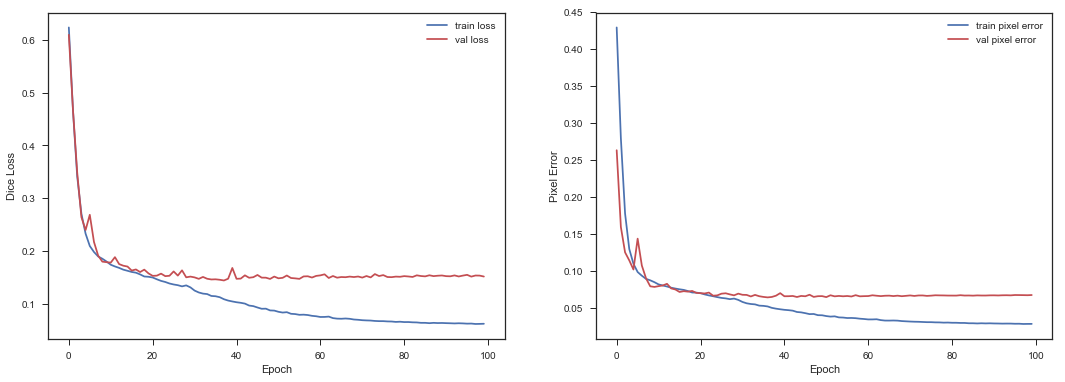

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
ax[0].plot(results.epoch, [x + 1 for x in results.history['ofuse_loss']], 'b-', label='train loss')
ax[0].plot(results.epoch, [x + 1 for x in results.history['val_ofuse_loss']], 'r-', label='val loss')
ax[0].legend(loc='upper right')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Dice Loss')
ax[1].plot(results.epoch, results.history['ofuse_pixel_error'], 'b-', label='train pixel error')
ax[1].plot(results.epoch, results.history['val_ofuse_pixel_error'], 'r-', label='val pixel error')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Pixel Error')
plt.show()

In [63]:
y_pred = model_unet_side_fuse.predict(X_test)
result_fuse = y_pred[-1].astype(np.float32)
result_fuse.shape

(30, 512, 512, 1)

In [65]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v3_dice_' + timestamp + '.tif', result_fuse, dtype=np.float32)
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v3_dice_' + timestamp + '.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

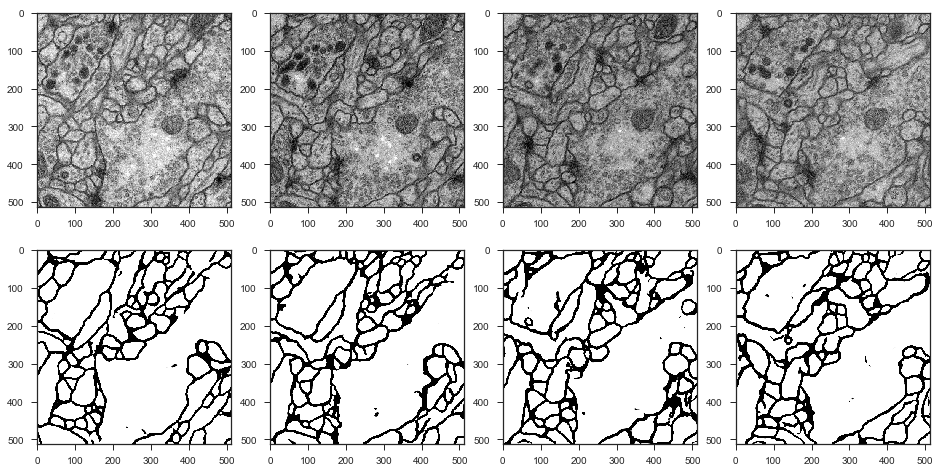

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='binary')

plt.show()

Test with only flipped aug

In [23]:
X_train = np.load(DATA_PATH + 'X_train_aug_flip.npy')
y_train = np.load(DATA_PATH + 'y_train_aug_flip.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((120, 512, 512, 1), (120, 512, 512, 1), (30, 512, 512, 1))

In [24]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((108, 512, 512, 1), (12, 512, 512, 1), (108, 512, 512, 1), (12, 512, 512, 1))

In [25]:
model_unet_fuse_v3 = u_net_fuse_v3(input_shape=(512, 512, 1))
model_unet_fuse_v3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 512, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 512, 512, 32) 832         lambda_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 512, 512, 32) 128         conv2d_51[0][0]                  
__________________________________________________________________________________________________
activation

In [26]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.8, patience=5, verbose=1, 
                             min_lr=1e-4)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, 
                               save_best_only=True, monitor='val_ofuse_pixel_error')
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v3', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_fuse_v3.compile(loss={'o1': cross_entropy_balanced,
                                'o2': cross_entropy_balanced,
                                'o3': cross_entropy_balanced,
                                'o4': cross_entropy_balanced,
                                'o5': cross_entropy_balanced,
                                'ofuse': cross_entropy_balanced,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error]},
                          optimizer=optimizer)

results = model_unet_fuse_v3.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=100, callbacks=callback_list, verbose=2)

Train on 108 samples, validate on 12 samples


Epoch 1/100


 - 10s - loss: 1.3283 - o1_loss: 0.2361 - o2_loss: 0.2364 - o3_loss: 0.2330 - o4_loss: 0.2384 - o5_loss: 0.1869 - ofuse_loss: 0.1976 - ofuse_dice_coef: 0.3799 - ofuse_jaccard_coef: 0.2344 - ofuse_pixel_error: 0.3326 - val_loss: 1.3338 - val_o1_loss: 0.2569 - val_o2_loss: 0.2333 - val_o3_loss: 0.2290 - val_o4_loss: 0.2365 - val_o5_loss: 0.2009 - val_ofuse_loss: 0.1772 - val_ofuse_dice_coef: 0.5032 - val_ofuse_jaccard_coef: 0.3345 - val_ofuse_pixel_error: 0.2499



Epoch 00001: val_ofuse_pixel_error improved from inf to 0.24994, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/100


 - 7s - loss: 1.1704 - o1_loss: 0.2178 - o2_loss: 0.2149 - o3_loss: 0.2052 - o4_loss: 0.2309 - o5_loss: 0.1439 - ofuse_loss: 0.1577 - ofuse_dice_coef: 0.4652 - ofuse_jaccard_coef: 0.3020 - ofuse_pixel_error: 0.2182 - val_loss: 1.3110 - val_o1_loss: 0.2661 - val_o2_loss: 0.2822 - val_o3_loss: 0.2380 - val_o4_loss: 0.2240 - val_o5_loss: 0.1439 - val_ofuse_loss: 0.1568 - val_ofuse_dice_coef: 0.5220 - val_ofuse_jaccard_coef: 0.3518 - val_ofuse_pixel_error: 0.1642



Epoch 00002: val_ofuse_pixel_error improved from 0.24994 to 0.16418, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/100


 - 7s - loss: 1.0251 - o1_loss: 0.2011 - o2_loss: 0.1881 - o3_loss: 0.1702 - o4_loss: 0.2084 - o5_loss: 0.1208 - ofuse_loss: 0.1365 - ofuse_dice_coef: 0.5195 - ofuse_jaccard_coef: 0.3499 - ofuse_pixel_error: 0.1764 - val_loss: 1.3022 - val_o1_loss: 0.3212 - val_o2_loss: 0.2589 - val_o3_loss: 0.2123 - val_o4_loss: 0.1961 - val_o5_loss: 0.1323 - val_ofuse_loss: 0.1814 - val_ofuse_dice_coef: 0.5128 - val_ofuse_jaccard_coef: 0.3443 - val_ofuse_pixel_error: 0.1412



Epoch 00003: val_ofuse_pixel_error improved from 0.16418 to 0.14118, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 4/100


 - 7s - loss: 0.9220 - o1_loss: 0.1939 - o2_loss: 0.1710 - o3_loss: 0.1477 - o4_loss: 0.1777 - o5_loss: 0.1083 - ofuse_loss: 0.1235 - ofuse_dice_coef: 0.5592 - ofuse_jaccard_coef: 0.3871 - ofuse_pixel_error: 0.1556 - val_loss: 0.9852 - val_o1_loss: 0.2073 - val_o2_loss: 0.1882 - val_o3_loss: 0.1823 - val_o4_loss: 0.1637 - val_o5_loss: 0.1162 - val_ofuse_loss: 0.1275 - val_ofuse_dice_coef: 0.5951 - val_ofuse_jaccard_coef: 0.4226 - val_ofuse_pixel_error: 0.1145



Epoch 00004: val_ofuse_pixel_error improved from 0.14118 to 0.11448, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 5/100


 - 7s - loss: 0.8417 - o1_loss: 0.1898 - o2_loss: 0.1582 - o3_loss: 0.1319 - o4_loss: 0.1512 - o5_loss: 0.0986 - ofuse_loss: 0.1119 - ofuse_dice_coef: 0.5947 - ofuse_jaccard_coef: 0.4225 - ofuse_pixel_error: 0.1373 - val_loss: 0.8619 - val_o1_loss: 0.1972 - val_o2_loss: 0.1568 - val_o3_loss: 0.1501 - val_o4_loss: 0.1420 - val_o5_loss: 0.1057 - val_ofuse_loss: 0.1100 - val_ofuse_dice_coef: 0.6399 - val_ofuse_jaccard_coef: 0.4695 - val_ofuse_pixel_error: 0.1121



Epoch 00005: val_ofuse_pixel_error improved from 0.11448 to 0.11214, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 6/100


 - 7s - loss: 0.7897 - o1_loss: 0.1889 - o2_loss: 0.1518 - o3_loss: 0.1208 - o4_loss: 0.1318 - o5_loss: 0.0930 - ofuse_loss: 0.1034 - ofuse_dice_coef: 0.6237 - ofuse_jaccard_coef: 0.4521 - ofuse_pixel_error: 0.1263 - val_loss: 0.8648 - val_o1_loss: 0.2153 - val_o2_loss: 0.1726 - val_o3_loss: 0.1376 - val_o4_loss: 0.1245 - val_o5_loss: 0.0994 - val_ofuse_loss: 0.1155 - val_ofuse_dice_coef: 0.6340 - val_ofuse_jaccard_coef: 0.4629 - val_ofuse_pixel_error: 0.1089



Epoch 00006: val_ofuse_pixel_error improved from 0.11214 to 0.10891, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 7/100


 - 7s - loss: 0.7427 - o1_loss: 0.1872 - o2_loss: 0.1458 - o3_loss: 0.1105 - o4_loss: 0.1162 - o5_loss: 0.0876 - ofuse_loss: 0.0954 - ofuse_dice_coef: 0.6501 - ofuse_jaccard_coef: 0.4805 - ofuse_pixel_error: 0.1180 - val_loss: 0.7841 - val_o1_loss: 0.1907 - val_o2_loss: 0.1510 - val_o3_loss: 0.1302 - val_o4_loss: 0.1141 - val_o5_loss: 0.0964 - val_ofuse_loss: 0.1018 - val_ofuse_dice_coef: 0.6590 - val_ofuse_jaccard_coef: 0.4892 - val_ofuse_pixel_error: 0.1059



Epoch 00007: val_ofuse_pixel_error improved from 0.10891 to 0.10588, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 8/100


 - 7s - loss: 0.7067 - o1_loss: 0.1861 - o2_loss: 0.1429 - o3_loss: 0.1023 - o4_loss: 0.1042 - o5_loss: 0.0823 - ofuse_loss: 0.0890 - ofuse_dice_coef: 0.6723 - ofuse_jaccard_coef: 0.5053 - ofuse_pixel_error: 0.1123 - val_loss: 0.7128 - val_o1_loss: 0.1870 - val_o2_loss: 0.1443 - val_o3_loss: 0.1028 - val_o4_loss: 0.1007 - val_o5_loss: 0.0845 - val_ofuse_loss: 0.0935 - val_ofuse_dice_coef: 0.6580 - val_ofuse_jaccard_coef: 0.4881 - val_ofuse_pixel_error: 0.1186



Epoch 00008: val_ofuse_pixel_error did not improve
Epoch 9/100


 - 7s - loss: 0.6780 - o1_loss: 0.1850 - o2_loss: 0.1391 - o3_loss: 0.0963 - o4_loss: 0.0951 - o5_loss: 0.0787 - ofuse_loss: 0.0838 - ofuse_dice_coef: 0.6922 - ofuse_jaccard_coef: 0.5282 - ofuse_pixel_error: 0.1084 - val_loss: 0.7603 - val_o1_loss: 0.1929 - val_o2_loss: 0.1404 - val_o3_loss: 0.1134 - val_o4_loss: 0.1083 - val_o5_loss: 0.0988 - val_ofuse_loss: 0.1065 - val_ofuse_dice_coef: 0.6258 - val_ofuse_jaccard_coef: 0.4547 - val_ofuse_pixel_error: 0.1792



Epoch 00009: val_ofuse_pixel_error did not improve
Epoch 10/100


 - 7s - loss: 0.6555 - o1_loss: 0.1843 - o2_loss: 0.1365 - o3_loss: 0.0913 - o4_loss: 0.0879 - o5_loss: 0.0762 - ofuse_loss: 0.0792 - ofuse_dice_coef: 0.7077 - ofuse_jaccard_coef: 0.5465 - ofuse_pixel_error: 0.1069 - val_loss: 0.7635 - val_o1_loss: 0.1900 - val_o2_loss: 0.1417 - val_o3_loss: 0.1123 - val_o4_loss: 0.1088 - val_o5_loss: 0.1061 - val_ofuse_loss: 0.1046 - val_ofuse_dice_coef: 0.6289 - val_ofuse_jaccard_coef: 0.4573 - val_ofuse_pixel_error: 0.1757



Epoch 00010: val_ofuse_pixel_error did not improve
Epoch 11/100


 - 7s - loss: 0.6361 - o1_loss: 0.1833 - o2_loss: 0.1344 - o3_loss: 0.0878 - o4_loss: 0.0820 - o5_loss: 0.0728 - ofuse_loss: 0.0756 - ofuse_dice_coef: 0.7216 - ofuse_jaccard_coef: 0.5633 - ofuse_pixel_error: 0.1030 - val_loss: 0.6989 - val_o1_loss: 0.1865 - val_o2_loss: 0.1419 - val_o3_loss: 0.0973 - val_o4_loss: 0.0937 - val_o5_loss: 0.0885 - val_ofuse_loss: 0.0910 - val_ofuse_dice_coef: 0.6653 - val_ofuse_jaccard_coef: 0.4967 - val_ofuse_pixel_error: 0.1399



Epoch 00011: val_ofuse_pixel_error did not improve
Epoch 12/100


 - 7s - loss: 0.6262 - o1_loss: 0.1833 - o2_loss: 0.1332 - o3_loss: 0.0857 - o4_loss: 0.0783 - o5_loss: 0.0717 - ofuse_loss: 0.0739 - ofuse_dice_coef: 0.7287 - ofuse_jaccard_coef: 0.5722 - ofuse_pixel_error: 0.1025 - val_loss: 0.6977 - val_o1_loss: 0.1865 - val_o2_loss: 0.1474 - val_o3_loss: 0.1050 - val_o4_loss: 0.0890 - val_o5_loss: 0.0842 - val_ofuse_loss: 0.0855 - val_ofuse_dice_coef: 0.7072 - val_ofuse_jaccard_coef: 0.5456 - val_ofuse_pixel_error: 0.1164



Epoch 00012: val_ofuse_pixel_error did not improve
Epoch 13/100


 - 7s - loss: 0.6097 - o1_loss: 0.1825 - o2_loss: 0.1311 - o3_loss: 0.0824 - o4_loss: 0.0740 - o5_loss: 0.0691 - ofuse_loss: 0.0706 - ofuse_dice_coef: 0.7407 - ofuse_jaccard_coef: 0.5870 - ofuse_pixel_error: 0.0985 - val_loss: 0.6827 - val_o1_loss: 0.1865 - val_o2_loss: 0.1386 - val_o3_loss: 0.0994 - val_o4_loss: 0.0865 - val_o5_loss: 0.0848 - val_ofuse_loss: 0.0869 - val_ofuse_dice_coef: 0.6980 - val_ofuse_jaccard_coef: 0.5342 - val_ofuse_pixel_error: 0.1247



Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.000800000037998.

Epoch 00013: val_ofuse_pixel_error did not improve
Epoch 14/100


 - 7s - loss: 0.6014 - o1_loss: 0.1820 - o2_loss: 0.1302 - o3_loss: 0.0807 - o4_loss: 0.0717 - o5_loss: 0.0677 - ofuse_loss: 0.0690 - ofuse_dice_coef: 0.7466 - ofuse_jaccard_coef: 0.5946 - ofuse_pixel_error: 0.0975 - val_loss: 0.6747 - val_o1_loss: 0.1859 - val_o2_loss: 0.1395 - val_o3_loss: 0.0990 - val_o4_loss: 0.0855 - val_o5_loss: 0.0794 - val_ofuse_loss: 0.0854 - val_ofuse_dice_coef: 0.7043 - val_ofuse_jaccard_coef: 0.5423 - val_ofuse_pixel_error: 0.1307



Epoch 00014: val_ofuse_pixel_error did not improve
Epoch 15/100


 - 7s - loss: 0.5889 - o1_loss: 0.1811 - o2_loss: 0.1285 - o3_loss: 0.0787 - o4_loss: 0.0689 - o5_loss: 0.0652 - ofuse_loss: 0.0665 - ofuse_dice_coef: 0.7547 - ofuse_jaccard_coef: 0.6048 - ofuse_pixel_error: 0.0952 - val_loss: 0.6437 - val_o1_loss: 0.1840 - val_o2_loss: 0.1345 - val_o3_loss: 0.0913 - val_o4_loss: 0.0797 - val_o5_loss: 0.0757 - val_ofuse_loss: 0.0786 - val_ofuse_dice_coef: 0.7186 - val_ofuse_jaccard_coef: 0.5589 - val_ofuse_pixel_error: 0.1128



Epoch 00015: val_ofuse_pixel_error did not improve
Epoch 16/100


 - 7s - loss: 0.5781 - o1_loss: 0.1803 - o2_loss: 0.1263 - o3_loss: 0.0762 - o4_loss: 0.0667 - o5_loss: 0.0638 - ofuse_loss: 0.0647 - ofuse_dice_coef: 0.7605 - ofuse_jaccard_coef: 0.6123 - ofuse_pixel_error: 0.0932 - val_loss: 0.6439 - val_o1_loss: 0.1838 - val_o2_loss: 0.1360 - val_o3_loss: 0.0912 - val_o4_loss: 0.0781 - val_o5_loss: 0.0766 - val_ofuse_loss: 0.0783 - val_ofuse_dice_coef: 0.7227 - val_ofuse_jaccard_coef: 0.5644 - val_ofuse_pixel_error: 0.1143



Epoch 00016: val_ofuse_pixel_error did not improve
Epoch 17/100


 - 7s - loss: 0.5767 - o1_loss: 0.1806 - o2_loss: 0.1265 - o3_loss: 0.0761 - o4_loss: 0.0659 - o5_loss: 0.0634 - ofuse_loss: 0.0642 - ofuse_dice_coef: 0.7649 - ofuse_jaccard_coef: 0.6183 - ofuse_pixel_error: 0.0914 - val_loss: 0.6616 - val_o1_loss: 0.1850 - val_o2_loss: 0.1367 - val_o3_loss: 0.0997 - val_o4_loss: 0.0800 - val_o5_loss: 0.0795 - val_ofuse_loss: 0.0807 - val_ofuse_dice_coef: 0.7411 - val_ofuse_jaccard_coef: 0.5876 - val_ofuse_pixel_error: 0.1069



Epoch 00017: val_ofuse_pixel_error did not improve
Epoch 18/100


 - 7s - loss: 0.5689 - o1_loss: 0.1800 - o2_loss: 0.1253 - o3_loss: 0.0749 - o4_loss: 0.0641 - o5_loss: 0.0618 - ofuse_loss: 0.0627 - ofuse_dice_coef: 0.7695 - ofuse_jaccard_coef: 0.6240 - ofuse_pixel_error: 0.0909 - val_loss: 0.6387 - val_o1_loss: 0.1841 - val_o2_loss: 0.1344 - val_o3_loss: 0.0896 - val_o4_loss: 0.0775 - val_o5_loss: 0.0759 - val_ofuse_loss: 0.0773 - val_ofuse_dice_coef: 0.7402 - val_ofuse_jaccard_coef: 0.5866 - val_ofuse_pixel_error: 0.1020



Epoch 00018: val_ofuse_pixel_error improved from 0.10588 to 0.10198, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 19/100


 - 7s - loss: 0.5627 - o1_loss: 0.1798 - o2_loss: 0.1243 - o3_loss: 0.0733 - o4_loss: 0.0631 - o5_loss: 0.0607 - ofuse_loss: 0.0615 - ofuse_dice_coef: 0.7740 - ofuse_jaccard_coef: 0.6303 - ofuse_pixel_error: 0.0886 - val_loss: 0.6383 - val_o1_loss: 0.1844 - val_o2_loss: 0.1337 - val_o3_loss: 0.0904 - val_o4_loss: 0.0774 - val_o5_loss: 0.0756 - val_ofuse_loss: 0.0768 - val_ofuse_dice_coef: 0.7420 - val_ofuse_jaccard_coef: 0.5890 - val_ofuse_pixel_error: 0.1067



Epoch 00019: val_ofuse_pixel_error did not improve
Epoch 20/100


 - 7s - loss: 0.5537 - o1_loss: 0.1792 - o2_loss: 0.1232 - o3_loss: 0.0716 - o4_loss: 0.0611 - o5_loss: 0.0591 - ofuse_loss: 0.0595 - ofuse_dice_coef: 0.7809 - ofuse_jaccard_coef: 0.6393 - ofuse_pixel_error: 0.0866 - val_loss: 0.6297 - val_o1_loss: 0.1834 - val_o2_loss: 0.1327 - val_o3_loss: 0.0884 - val_o4_loss: 0.0755 - val_o5_loss: 0.0743 - val_ofuse_loss: 0.0753 - val_ofuse_dice_coef: 0.7475 - val_ofuse_jaccard_coef: 0.5959 - val_ofuse_pixel_error: 0.1033



Epoch 00020: val_ofuse_pixel_error did not improve
Epoch 21/100


 - 7s - loss: 0.5494 - o1_loss: 0.1789 - o2_loss: 0.1226 - o3_loss: 0.0709 - o4_loss: 0.0601 - o5_loss: 0.0582 - ofuse_loss: 0.0588 - ofuse_dice_coef: 0.7845 - ofuse_jaccard_coef: 0.6441 - ofuse_pixel_error: 0.0851 - val_loss: 0.6330 - val_o1_loss: 0.1841 - val_o2_loss: 0.1330 - val_o3_loss: 0.0882 - val_o4_loss: 0.0771 - val_o5_loss: 0.0751 - val_ofuse_loss: 0.0755 - val_ofuse_dice_coef: 0.7466 - val_ofuse_jaccard_coef: 0.5947 - val_ofuse_pixel_error: 0.1005



Epoch 00021: val_ofuse_pixel_error improved from 0.10198 to 0.10046, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 22/100


 - 7s - loss: 0.5452 - o1_loss: 0.1788 - o2_loss: 0.1219 - o3_loss: 0.0699 - o4_loss: 0.0592 - o5_loss: 0.0574 - ofuse_loss: 0.0579 - ofuse_dice_coef: 0.7878 - ofuse_jaccard_coef: 0.6487 - ofuse_pixel_error: 0.0835 - val_loss: 0.6500 - val_o1_loss: 0.1842 - val_o2_loss: 0.1374 - val_o3_loss: 0.0938 - val_o4_loss: 0.0786 - val_o5_loss: 0.0786 - val_ofuse_loss: 0.0775 - val_ofuse_dice_coef: 0.7502 - val_ofuse_jaccard_coef: 0.5997 - val_ofuse_pixel_error: 0.0993



Epoch 00022: val_ofuse_pixel_error improved from 0.10046 to 0.09934, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 23/100


 - 8s - loss: 0.5426 - o1_loss: 0.1788 - o2_loss: 0.1217 - o3_loss: 0.0695 - o4_loss: 0.0585 - o5_loss: 0.0569 - ofuse_loss: 0.0572 - ofuse_dice_coef: 0.7912 - ofuse_jaccard_coef: 0.6535 - ofuse_pixel_error: 0.0831 - val_loss: 0.6332 - val_o1_loss: 0.1832 - val_o2_loss: 0.1338 - val_o3_loss: 0.0892 - val_o4_loss: 0.0763 - val_o5_loss: 0.0748 - val_ofuse_loss: 0.0758 - val_ofuse_dice_coef: 0.7522 - val_ofuse_jaccard_coef: 0.6017 - val_ofuse_pixel_error: 0.1045



Epoch 00023: val_ofuse_pixel_error did not improve
Epoch 24/100


 - 8s - loss: 0.5374 - o1_loss: 0.1787 - o2_loss: 0.1211 - o3_loss: 0.0685 - o4_loss: 0.0573 - o5_loss: 0.0556 - ofuse_loss: 0.0562 - ofuse_dice_coef: 0.7937 - ofuse_jaccard_coef: 0.6570 - ofuse_pixel_error: 0.0818 - val_loss: 0.6462 - val_o1_loss: 0.1834 - val_o2_loss: 0.1324 - val_o3_loss: 0.0927 - val_o4_loss: 0.0798 - val_o5_loss: 0.0801 - val_ofuse_loss: 0.0779 - val_ofuse_dice_coef: 0.7550 - val_ofuse_jaccard_coef: 0.6055 - val_ofuse_pixel_error: 0.1002



Epoch 00024: val_ofuse_pixel_error did not improve
Epoch 25/100


 - 7s - loss: 0.5325 - o1_loss: 0.1782 - o2_loss: 0.1203 - o3_loss: 0.0676 - o4_loss: 0.0565 - o5_loss: 0.0548 - ofuse_loss: 0.0551 - ofuse_dice_coef: 0.7984 - ofuse_jaccard_coef: 0.6635 - ofuse_pixel_error: 0.0802 - val_loss: 0.6373 - val_o1_loss: 0.1837 - val_o2_loss: 0.1333 - val_o3_loss: 0.0905 - val_o4_loss: 0.0771 - val_o5_loss: 0.0768 - val_ofuse_loss: 0.0759 - val_ofuse_dice_coef: 0.7562 - val_ofuse_jaccard_coef: 0.6072 - val_ofuse_pixel_error: 0.1003



Epoch 00025: val_ofuse_pixel_error did not improve
Epoch 26/100


 - 8s - loss: 0.5263 - o1_loss: 0.1780 - o2_loss: 0.1196 - o3_loss: 0.0665 - o4_loss: 0.0550 - o5_loss: 0.0534 - ofuse_loss: 0.0538 - ofuse_dice_coef: 0.8023 - ofuse_jaccard_coef: 0.6688 - ofuse_pixel_error: 0.0780 - val_loss: 0.6368 - val_o1_loss: 0.1832 - val_o2_loss: 0.1328 - val_o3_loss: 0.0899 - val_o4_loss: 0.0771 - val_o5_loss: 0.0773 - val_ofuse_loss: 0.0765 - val_ofuse_dice_coef: 0.7565 - val_ofuse_jaccard_coef: 0.6077 - val_ofuse_pixel_error: 0.1003



Epoch 00026: val_ofuse_pixel_error did not improve
Epoch 27/100


 - 8s - loss: 0.5199 - o1_loss: 0.1778 - o2_loss: 0.1190 - o3_loss: 0.0649 - o4_loss: 0.0536 - o5_loss: 0.0522 - ofuse_loss: 0.0524 - ofuse_dice_coef: 0.8081 - ofuse_jaccard_coef: 0.6769 - ofuse_pixel_error: 0.0754 - val_loss: 0.6514 - val_o1_loss: 0.1829 - val_o2_loss: 0.1336 - val_o3_loss: 0.0946 - val_o4_loss: 0.0802 - val_o5_loss: 0.0806 - val_ofuse_loss: 0.0794 - val_ofuse_dice_coef: 0.7660 - val_ofuse_jaccard_coef: 0.6199 - val_ofuse_pixel_error: 0.0974



Epoch 00027: val_ofuse_pixel_error improved from 0.09934 to 0.09743, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 28/100


 - 7s - loss: 0.5157 - o1_loss: 0.1776 - o2_loss: 0.1184 - o3_loss: 0.0642 - o4_loss: 0.0527 - o5_loss: 0.0513 - ofuse_loss: 0.0515 - ofuse_dice_coef: 0.8117 - ofuse_jaccard_coef: 0.6816 - ofuse_pixel_error: 0.0747 - val_loss: 0.6585 - val_o1_loss: 0.1830 - val_o2_loss: 0.1332 - val_o3_loss: 0.0958 - val_o4_loss: 0.0821 - val_o5_loss: 0.0829 - val_ofuse_loss: 0.0816 - val_ofuse_dice_coef: 0.7573 - val_ofuse_jaccard_coef: 0.6088 - val_ofuse_pixel_error: 0.1034



Epoch 00028: val_ofuse_pixel_error did not improve
Epoch 29/100


 - 7s - loss: 0.5148 - o1_loss: 0.1774 - o2_loss: 0.1181 - o3_loss: 0.0642 - o4_loss: 0.0526 - o5_loss: 0.0511 - ofuse_loss: 0.0514 - ofuse_dice_coef: 0.8124 - ofuse_jaccard_coef: 0.6832 - ofuse_pixel_error: 0.0744 - val_loss: 0.6529 - val_o1_loss: 0.1827 - val_o2_loss: 0.1328 - val_o3_loss: 0.0936 - val_o4_loss: 0.0813 - val_o5_loss: 0.0820 - val_ofuse_loss: 0.0806 - val_ofuse_dice_coef: 0.7625 - val_ofuse_jaccard_coef: 0.6155 - val_ofuse_pixel_error: 0.1027



Epoch 00029: val_ofuse_pixel_error did not improve
Epoch 30/100


 - 7s - loss: 0.5080 - o1_loss: 0.1774 - o2_loss: 0.1177 - o3_loss: 0.0627 - o4_loss: 0.0509 - o5_loss: 0.0495 - ofuse_loss: 0.0498 - ofuse_dice_coef: 0.8171 - ofuse_jaccard_coef: 0.6896 - ofuse_pixel_error: 0.0720 - val_loss: 0.6551 - val_o1_loss: 0.1831 - val_o2_loss: 0.1329 - val_o3_loss: 0.0945 - val_o4_loss: 0.0817 - val_o5_loss: 0.0818 - val_ofuse_loss: 0.0811 - val_ofuse_dice_coef: 0.7715 - val_ofuse_jaccard_coef: 0.6275 - val_ofuse_pixel_error: 0.0991



Epoch 00030: val_ofuse_pixel_error did not improve
Epoch 31/100


 - 7s - loss: 0.5005 - o1_loss: 0.1771 - o2_loss: 0.1170 - o3_loss: 0.0612 - o4_loss: 0.0492 - o5_loss: 0.0479 - ofuse_loss: 0.0481 - ofuse_dice_coef: 0.8235 - ofuse_jaccard_coef: 0.6988 - ofuse_pixel_error: 0.0695 - val_loss: 0.6551 - val_o1_loss: 0.1838 - val_o2_loss: 0.1319 - val_o3_loss: 0.0939 - val_o4_loss: 0.0815 - val_o5_loss: 0.0823 - val_ofuse_loss: 0.0817 - val_ofuse_dice_coef: 0.7713 - val_ofuse_jaccard_coef: 0.6268 - val_ofuse_pixel_error: 0.1064



Epoch 00031: val_ofuse_pixel_error did not improve
Epoch 32/100


 - 7s - loss: 0.4990 - o1_loss: 0.1771 - o2_loss: 0.1167 - o3_loss: 0.0611 - o4_loss: 0.0489 - o5_loss: 0.0475 - ofuse_loss: 0.0477 - ofuse_dice_coef: 0.8255 - ofuse_jaccard_coef: 0.7019 - ofuse_pixel_error: 0.0688 - val_loss: 0.6555 - val_o1_loss: 0.1833 - val_o2_loss: 0.1324 - val_o3_loss: 0.0942 - val_o4_loss: 0.0821 - val_o5_loss: 0.0821 - val_ofuse_loss: 0.0814 - val_ofuse_dice_coef: 0.7753 - val_ofuse_jaccard_coef: 0.6318 - val_ofuse_pixel_error: 0.1019



Epoch 00032: val_ofuse_pixel_error did not improve
Epoch 33/100


 - 7s - loss: 0.4955 - o1_loss: 0.1769 - o2_loss: 0.1165 - o3_loss: 0.0604 - o4_loss: 0.0481 - o5_loss: 0.0467 - ofuse_loss: 0.0469 - ofuse_dice_coef: 0.8274 - ofuse_jaccard_coef: 0.7046 - ofuse_pixel_error: 0.0681 - val_loss: 0.6663 - val_o1_loss: 0.1824 - val_o2_loss: 0.1327 - val_o3_loss: 0.0974 - val_o4_loss: 0.0844 - val_o5_loss: 0.0860 - val_ofuse_loss: 0.0833 - val_ofuse_dice_coef: 0.7812 - val_ofuse_jaccard_coef: 0.6399 - val_ofuse_pixel_error: 0.0950



Epoch 00033: val_ofuse_pixel_error improved from 0.09743 to 0.09496, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 34/100


 - 7s - loss: 0.4897 - o1_loss: 0.1768 - o2_loss: 0.1162 - o3_loss: 0.0592 - o4_loss: 0.0467 - o5_loss: 0.0453 - ofuse_loss: 0.0455 - ofuse_dice_coef: 0.8331 - ofuse_jaccard_coef: 0.7127 - ofuse_pixel_error: 0.0652 - val_loss: 0.6714 - val_o1_loss: 0.1825 - val_o2_loss: 0.1343 - val_o3_loss: 0.0980 - val_o4_loss: 0.0858 - val_o5_loss: 0.0860 - val_ofuse_loss: 0.0848 - val_ofuse_dice_coef: 0.7831 - val_ofuse_jaccard_coef: 0.6426 - val_ofuse_pixel_error: 0.0958



Epoch 00034: val_ofuse_pixel_error did not improve
Epoch 35/100


 - 7s - loss: 0.4879 - o1_loss: 0.1766 - o2_loss: 0.1158 - o3_loss: 0.0589 - o4_loss: 0.0463 - o5_loss: 0.0450 - ofuse_loss: 0.0451 - ofuse_dice_coef: 0.8349 - ofuse_jaccard_coef: 0.7156 - ofuse_pixel_error: 0.0648 - val_loss: 0.6708 - val_o1_loss: 0.1821 - val_o2_loss: 0.1320 - val_o3_loss: 0.0967 - val_o4_loss: 0.0864 - val_o5_loss: 0.0884 - val_ofuse_loss: 0.0852 - val_ofuse_dice_coef: 0.7825 - val_ofuse_jaccard_coef: 0.6418 - val_ofuse_pixel_error: 0.0919



Epoch 00035: val_ofuse_pixel_error improved from 0.09496 to 0.09186, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 36/100


 - 7s - loss: 0.4885 - o1_loss: 0.1766 - o2_loss: 0.1158 - o3_loss: 0.0593 - o4_loss: 0.0465 - o5_loss: 0.0451 - ofuse_loss: 0.0453 - ofuse_dice_coef: 0.8344 - ofuse_jaccard_coef: 0.7148 - ofuse_pixel_error: 0.0654 - val_loss: 0.6861 - val_o1_loss: 0.1823 - val_o2_loss: 0.1353 - val_o3_loss: 0.1004 - val_o4_loss: 0.0889 - val_o5_loss: 0.0905 - val_ofuse_loss: 0.0887 - val_ofuse_dice_coef: 0.7801 - val_ofuse_jaccard_coef: 0.6390 - val_ofuse_pixel_error: 0.0974



Epoch 00036: val_ofuse_pixel_error did not improve
Epoch 37/100


 - 8s - loss: 0.4799 - o1_loss: 0.1764 - o2_loss: 0.1151 - o3_loss: 0.0576 - o4_loss: 0.0445 - o5_loss: 0.0431 - ofuse_loss: 0.0433 - ofuse_dice_coef: 0.8403 - ofuse_jaccard_coef: 0.7235 - ofuse_pixel_error: 0.0623 - val_loss: 0.6751 - val_o1_loss: 0.1822 - val_o2_loss: 0.1323 - val_o3_loss: 0.0988 - val_o4_loss: 0.0868 - val_o5_loss: 0.0884 - val_ofuse_loss: 0.0866 - val_ofuse_dice_coef: 0.7881 - val_ofuse_jaccard_coef: 0.6494 - val_ofuse_pixel_error: 0.0921



Epoch 00037: val_ofuse_pixel_error did not improve
Epoch 38/100


 - 8s - loss: 0.4727 - o1_loss: 0.1762 - o2_loss: 0.1147 - o3_loss: 0.0562 - o4_loss: 0.0427 - o5_loss: 0.0414 - ofuse_loss: 0.0416 - ofuse_dice_coef: 0.8464 - ofuse_jaccard_coef: 0.7327 - ofuse_pixel_error: 0.0595 - val_loss: 0.6756 - val_o1_loss: 0.1821 - val_o2_loss: 0.1317 - val_o3_loss: 0.0980 - val_o4_loss: 0.0879 - val_o5_loss: 0.0891 - val_ofuse_loss: 0.0868 - val_ofuse_dice_coef: 0.7879 - val_ofuse_jaccard_coef: 0.6489 - val_ofuse_pixel_error: 0.0941



Epoch 00038: val_ofuse_pixel_error did not improve
Epoch 39/100


 - 7s - loss: 0.4683 - o1_loss: 0.1759 - o2_loss: 0.1143 - o3_loss: 0.0555 - o4_loss: 0.0417 - o5_loss: 0.0403 - ofuse_loss: 0.0405 - ofuse_dice_coef: 0.8506 - ofuse_jaccard_coef: 0.7391 - ofuse_pixel_error: 0.0577 - val_loss: 0.7081 - val_o1_loss: 0.1823 - val_o2_loss: 0.1335 - val_o3_loss: 0.1022 - val_o4_loss: 0.0953 - val_o5_loss: 0.0994 - val_ofuse_loss: 0.0955 - val_ofuse_dice_coef: 0.7855 - val_ofuse_jaccard_coef: 0.6464 - val_ofuse_pixel_error: 0.0946



Epoch 00039: val_ofuse_pixel_error did not improve
Epoch 40/100


 - 7s - loss: 0.4695 - o1_loss: 0.1759 - o2_loss: 0.1143 - o3_loss: 0.0557 - o4_loss: 0.0420 - o5_loss: 0.0407 - ofuse_loss: 0.0408 - ofuse_dice_coef: 0.8502 - ofuse_jaccard_coef: 0.7385 - ofuse_pixel_error: 0.0584 - val_loss: 0.6862 - val_o1_loss: 0.1821 - val_o2_loss: 0.1330 - val_o3_loss: 0.0996 - val_o4_loss: 0.0888 - val_o5_loss: 0.0924 - val_ofuse_loss: 0.0904 - val_ofuse_dice_coef: 0.7910 - val_ofuse_jaccard_coef: 0.6533 - val_ofuse_pixel_error: 0.0922



Epoch 00040: val_ofuse_pixel_error did not improve
Epoch 41/100


 - 7s - loss: 0.4667 - o1_loss: 0.1759 - o2_loss: 0.1141 - o3_loss: 0.0553 - o4_loss: 0.0414 - o5_loss: 0.0400 - ofuse_loss: 0.0401 - ofuse_dice_coef: 0.8523 - ofuse_jaccard_coef: 0.7417 - ofuse_pixel_error: 0.0573 - val_loss: 0.6980 - val_o1_loss: 0.1826 - val_o2_loss: 0.1327 - val_o3_loss: 0.1017 - val_o4_loss: 0.0931 - val_o5_loss: 0.0951 - val_ofuse_loss: 0.0927 - val_ofuse_dice_coef: 0.7932 - val_ofuse_jaccard_coef: 0.6566 - val_ofuse_pixel_error: 0.0914



Epoch 00041: val_ofuse_pixel_error improved from 0.09186 to 0.09141, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 42/100


 - 7s - loss: 0.4611 - o1_loss: 0.1757 - o2_loss: 0.1138 - o3_loss: 0.0544 - o4_loss: 0.0400 - o5_loss: 0.0385 - ofuse_loss: 0.0387 - ofuse_dice_coef: 0.8566 - ofuse_jaccard_coef: 0.7483 - ofuse_pixel_error: 0.0551 - val_loss: 0.6964 - val_o1_loss: 0.1818 - val_o2_loss: 0.1327 - val_o3_loss: 0.1005 - val_o4_loss: 0.0928 - val_o5_loss: 0.0956 - val_ofuse_loss: 0.0930 - val_ofuse_dice_coef: 0.7888 - val_ofuse_jaccard_coef: 0.6501 - val_ofuse_pixel_error: 0.0968



Epoch 00042: val_ofuse_pixel_error did not improve
Epoch 43/100


 - 7s - loss: 0.4567 - o1_loss: 0.1757 - o2_loss: 0.1134 - o3_loss: 0.0536 - o4_loss: 0.0389 - o5_loss: 0.0375 - ofuse_loss: 0.0376 - ofuse_dice_coef: 0.8605 - ofuse_jaccard_coef: 0.7542 - ofuse_pixel_error: 0.0537 - val_loss: 0.7006 - val_o1_loss: 0.1820 - val_o2_loss: 0.1321 - val_o3_loss: 0.1015 - val_o4_loss: 0.0939 - val_o5_loss: 0.0965 - val_ofuse_loss: 0.0947 - val_ofuse_dice_coef: 0.7941 - val_ofuse_jaccard_coef: 0.6576 - val_ofuse_pixel_error: 0.0930



Epoch 00043: val_ofuse_pixel_error did not improve
Epoch 44/100


 - 7s - loss: 0.4531 - o1_loss: 0.1755 - o2_loss: 0.1131 - o3_loss: 0.0529 - o4_loss: 0.0380 - o5_loss: 0.0367 - ofuse_loss: 0.0368 - ofuse_dice_coef: 0.8637 - ofuse_jaccard_coef: 0.7592 - ofuse_pixel_error: 0.0525 - val_loss: 0.7294 - val_o1_loss: 0.1820 - val_o2_loss: 0.1336 - val_o3_loss: 0.1070 - val_o4_loss: 0.1006 - val_o5_loss: 0.1048 - val_ofuse_loss: 0.1013 - val_ofuse_dice_coef: 0.7969 - val_ofuse_jaccard_coef: 0.6617 - val_ofuse_pixel_error: 0.0879



Epoch 00044: val_ofuse_pixel_error improved from 0.09141 to 0.08785, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 45/100


 - 7s - loss: 0.4487 - o1_loss: 0.1754 - o2_loss: 0.1128 - o3_loss: 0.0521 - o4_loss: 0.0370 - o5_loss: 0.0356 - ofuse_loss: 0.0358 - ofuse_dice_coef: 0.8666 - ofuse_jaccard_coef: 0.7638 - ofuse_pixel_error: 0.0511 - val_loss: 0.7393 - val_o1_loss: 0.1820 - val_o2_loss: 0.1328 - val_o3_loss: 0.1065 - val_o4_loss: 0.1056 - val_o5_loss: 0.1093 - val_ofuse_loss: 0.1032 - val_ofuse_dice_coef: 0.7990 - val_ofuse_jaccard_coef: 0.6647 - val_ofuse_pixel_error: 0.0873



Epoch 00045: val_ofuse_pixel_error improved from 0.08785 to 0.08734, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 46/100


 - 7s - loss: 0.4480 - o1_loss: 0.1753 - o2_loss: 0.1128 - o3_loss: 0.0520 - o4_loss: 0.0369 - o5_loss: 0.0354 - ofuse_loss: 0.0355 - ofuse_dice_coef: 0.8681 - ofuse_jaccard_coef: 0.7660 - ofuse_pixel_error: 0.0507 - val_loss: 0.7354 - val_o1_loss: 0.1818 - val_o2_loss: 0.1334 - val_o3_loss: 0.1090 - val_o4_loss: 0.1016 - val_o5_loss: 0.1064 - val_ofuse_loss: 0.1031 - val_ofuse_dice_coef: 0.8004 - val_ofuse_jaccard_coef: 0.6665 - val_ofuse_pixel_error: 0.0856



Epoch 00046: val_ofuse_pixel_error improved from 0.08734 to 0.08557, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 47/100


 - 8s - loss: 0.4441 - o1_loss: 0.1752 - o2_loss: 0.1124 - o3_loss: 0.0516 - o4_loss: 0.0359 - o5_loss: 0.0345 - ofuse_loss: 0.0346 - ofuse_dice_coef: 0.8719 - ofuse_jaccard_coef: 0.7721 - ofuse_pixel_error: 0.0487 - val_loss: 0.7455 - val_o1_loss: 0.1819 - val_o2_loss: 0.1343 - val_o3_loss: 0.1089 - val_o4_loss: 0.1050 - val_o5_loss: 0.1094 - val_ofuse_loss: 0.1061 - val_ofuse_dice_coef: 0.7969 - val_ofuse_jaccard_coef: 0.6616 - val_ofuse_pixel_error: 0.0910



Epoch 00047: val_ofuse_pixel_error did not improve
Epoch 48/100


 - 8s - loss: 0.4441 - o1_loss: 0.1753 - o2_loss: 0.1125 - o3_loss: 0.0513 - o4_loss: 0.0359 - o5_loss: 0.0345 - ofuse_loss: 0.0346 - ofuse_dice_coef: 0.8725 - ofuse_jaccard_coef: 0.7729 - ofuse_pixel_error: 0.0487 - val_loss: 0.7621 - val_o1_loss: 0.1822 - val_o2_loss: 0.1352 - val_o3_loss: 0.1096 - val_o4_loss: 0.1078 - val_o5_loss: 0.1162 - val_ofuse_loss: 0.1111 - val_ofuse_dice_coef: 0.7975 - val_ofuse_jaccard_coef: 0.6626 - val_ofuse_pixel_error: 0.0856



Epoch 00048: val_ofuse_pixel_error improved from 0.08557 to 0.08557, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 49/100


 - 7s - loss: 0.4434 - o1_loss: 0.1751 - o2_loss: 0.1125 - o3_loss: 0.0513 - o4_loss: 0.0357 - o5_loss: 0.0344 - ofuse_loss: 0.0345 - ofuse_dice_coef: 0.8724 - ofuse_jaccard_coef: 0.7727 - ofuse_pixel_error: 0.0490 - val_loss: 0.7229 - val_o1_loss: 0.1819 - val_o2_loss: 0.1322 - val_o3_loss: 0.1027 - val_o4_loss: 0.0998 - val_o5_loss: 0.1048 - val_ofuse_loss: 0.1014 - val_ofuse_dice_coef: 0.7965 - val_ofuse_jaccard_coef: 0.6608 - val_ofuse_pixel_error: 0.0911



Epoch 00049: val_ofuse_pixel_error did not improve
Epoch 50/100


 - 7s - loss: 0.4395 - o1_loss: 0.1751 - o2_loss: 0.1123 - o3_loss: 0.0507 - o4_loss: 0.0347 - o5_loss: 0.0333 - ofuse_loss: 0.0335 - ofuse_dice_coef: 0.8754 - ofuse_jaccard_coef: 0.7774 - ofuse_pixel_error: 0.0475 - val_loss: 0.7339 - val_o1_loss: 0.1823 - val_o2_loss: 0.1333 - val_o3_loss: 0.1042 - val_o4_loss: 0.1023 - val_o5_loss: 0.1081 - val_ofuse_loss: 0.1037 - val_ofuse_dice_coef: 0.7988 - val_ofuse_jaccard_coef: 0.6641 - val_ofuse_pixel_error: 0.0902



Epoch 00050: val_ofuse_pixel_error did not improve
Epoch 51/100


 - 7s - loss: 0.4359 - o1_loss: 0.1749 - o2_loss: 0.1119 - o3_loss: 0.0500 - o4_loss: 0.0339 - o5_loss: 0.0325 - ofuse_loss: 0.0326 - ofuse_dice_coef: 0.8788 - ofuse_jaccard_coef: 0.7828 - ofuse_pixel_error: 0.0461 - val_loss: 0.7807 - val_o1_loss: 0.1821 - val_o2_loss: 0.1335 - val_o3_loss: 0.1134 - val_o4_loss: 0.1154 - val_o5_loss: 0.1207 - val_ofuse_loss: 0.1157 - val_ofuse_dice_coef: 0.7991 - val_ofuse_jaccard_coef: 0.6647 - val_ofuse_pixel_error: 0.0860



Epoch 00051: val_ofuse_pixel_error did not improve
Epoch 52/100


 - 7s - loss: 0.4331 - o1_loss: 0.1747 - o2_loss: 0.1116 - o3_loss: 0.0496 - o4_loss: 0.0333 - o5_loss: 0.0319 - ofuse_loss: 0.0320 - ofuse_dice_coef: 0.8811 - ofuse_jaccard_coef: 0.7865 - ofuse_pixel_error: 0.0449 - val_loss: 0.7537 - val_o1_loss: 0.1823 - val_o2_loss: 0.1347 - val_o3_loss: 0.1071 - val_o4_loss: 0.1071 - val_o5_loss: 0.1132 - val_ofuse_loss: 0.1093 - val_ofuse_dice_coef: 0.8045 - val_ofuse_jaccard_coef: 0.6722 - val_ofuse_pixel_error: 0.0852



Epoch 00052: val_ofuse_pixel_error improved from 0.08557 to 0.08516, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 53/100


 - 7s - loss: 0.4319 - o1_loss: 0.1747 - o2_loss: 0.1115 - o3_loss: 0.0493 - o4_loss: 0.0330 - o5_loss: 0.0317 - ofuse_loss: 0.0317 - ofuse_dice_coef: 0.8827 - ofuse_jaccard_coef: 0.7891 - ofuse_pixel_error: 0.0445 - val_loss: 0.7551 - val_o1_loss: 0.1822 - val_o2_loss: 0.1350 - val_o3_loss: 0.1082 - val_o4_loss: 0.1073 - val_o5_loss: 0.1124 - val_ofuse_loss: 0.1100 - val_ofuse_dice_coef: 0.8009 - val_ofuse_jaccard_coef: 0.6671 - val_ofuse_pixel_error: 0.0896



Epoch 00053: val_ofuse_pixel_error did not improve
Epoch 54/100


 - 7s - loss: 0.4354 - o1_loss: 0.1748 - o2_loss: 0.1118 - o3_loss: 0.0500 - o4_loss: 0.0338 - o5_loss: 0.0324 - ofuse_loss: 0.0325 - ofuse_dice_coef: 0.8797 - ofuse_jaccard_coef: 0.7841 - ofuse_pixel_error: 0.0461 - val_loss: 0.7557 - val_o1_loss: 0.1823 - val_o2_loss: 0.1337 - val_o3_loss: 0.1061 - val_o4_loss: 0.1078 - val_o5_loss: 0.1152 - val_ofuse_loss: 0.1106 - val_ofuse_dice_coef: 0.7983 - val_ofuse_jaccard_coef: 0.6639 - val_ofuse_pixel_error: 0.0891



Epoch 00054: val_ofuse_pixel_error did not improve
Epoch 55/100


 - 7s - loss: 0.4343 - o1_loss: 0.1747 - o2_loss: 0.1117 - o3_loss: 0.0497 - o4_loss: 0.0336 - o5_loss: 0.0323 - ofuse_loss: 0.0323 - ofuse_dice_coef: 0.8809 - ofuse_jaccard_coef: 0.7863 - ofuse_pixel_error: 0.0453 - val_loss: 0.7676 - val_o1_loss: 0.1819 - val_o2_loss: 0.1337 - val_o3_loss: 0.1090 - val_o4_loss: 0.1107 - val_o5_loss: 0.1182 - val_ofuse_loss: 0.1141 - val_ofuse_dice_coef: 0.7990 - val_ofuse_jaccard_coef: 0.6647 - val_ofuse_pixel_error: 0.0860



Epoch 00055: val_ofuse_pixel_error did not improve
Epoch 56/100


 - 8s - loss: 0.4318 - o1_loss: 0.1746 - o2_loss: 0.1115 - o3_loss: 0.0493 - o4_loss: 0.0330 - o5_loss: 0.0317 - ofuse_loss: 0.0317 - ofuse_dice_coef: 0.8829 - ofuse_jaccard_coef: 0.7892 - ofuse_pixel_error: 0.0443 - val_loss: 0.7683 - val_o1_loss: 0.1824 - val_o2_loss: 0.1333 - val_o3_loss: 0.1082 - val_o4_loss: 0.1121 - val_o5_loss: 0.1188 - val_ofuse_loss: 0.1136 - val_ofuse_dice_coef: 0.8008 - val_ofuse_jaccard_coef: 0.6675 - val_ofuse_pixel_error: 0.0866



Epoch 00056: val_ofuse_pixel_error did not improve
Epoch 57/100


 - 7s - loss: 0.4268 - o1_loss: 0.1746 - o2_loss: 0.1112 - o3_loss: 0.0485 - o4_loss: 0.0317 - o5_loss: 0.0304 - ofuse_loss: 0.0305 - ofuse_dice_coef: 0.8855 - ofuse_jaccard_coef: 0.7937 - ofuse_pixel_error: 0.0432 - val_loss: 0.7909 - val_o1_loss: 0.1819 - val_o2_loss: 0.1345 - val_o3_loss: 0.1152 - val_o4_loss: 0.1163 - val_o5_loss: 0.1226 - val_ofuse_loss: 0.1203 - val_ofuse_dice_coef: 0.8023 - val_ofuse_jaccard_coef: 0.6692 - val_ofuse_pixel_error: 0.0857



Epoch 00057: val_ofuse_pixel_error did not improve
Epoch 58/100


 - 7s - loss: 0.4245 - o1_loss: 0.1744 - o2_loss: 0.1109 - o3_loss: 0.0482 - o4_loss: 0.0312 - o5_loss: 0.0299 - ofuse_loss: 0.0299 - ofuse_dice_coef: 0.8889 - ofuse_jaccard_coef: 0.7992 - ofuse_pixel_error: 0.0417 - val_loss: 0.7732 - val_o1_loss: 0.1817 - val_o2_loss: 0.1340 - val_o3_loss: 0.1106 - val_o4_loss: 0.1125 - val_o5_loss: 0.1185 - val_ofuse_loss: 0.1160 - val_ofuse_dice_coef: 0.8041 - val_ofuse_jaccard_coef: 0.6717 - val_ofuse_pixel_error: 0.0859



Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.000640000030398.

Epoch 00058: val_ofuse_pixel_error did not improve
Epoch 59/100


 - 7s - loss: 0.4214 - o1_loss: 0.1743 - o2_loss: 0.1108 - o3_loss: 0.0476 - o4_loss: 0.0305 - o5_loss: 0.0291 - ofuse_loss: 0.0291 - ofuse_dice_coef: 0.8909 - ofuse_jaccard_coef: 0.8024 - ofuse_pixel_error: 0.0409 - val_loss: 0.8059 - val_o1_loss: 0.1820 - val_o2_loss: 0.1348 - val_o3_loss: 0.1154 - val_o4_loss: 0.1220 - val_o5_loss: 0.1274 - val_ofuse_loss: 0.1244 - val_ofuse_dice_coef: 0.8046 - val_ofuse_jaccard_coef: 0.6726 - val_ofuse_pixel_error: 0.0846



Epoch 00059: val_ofuse_pixel_error improved from 0.08516 to 0.08457, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 60/100


 - 7s - loss: 0.4175 - o1_loss: 0.1742 - o2_loss: 0.1105 - o3_loss: 0.0470 - o4_loss: 0.0296 - o5_loss: 0.0281 - ofuse_loss: 0.0282 - ofuse_dice_coef: 0.8945 - ofuse_jaccard_coef: 0.8081 - ofuse_pixel_error: 0.0394 - val_loss: 0.8044 - val_o1_loss: 0.1818 - val_o2_loss: 0.1346 - val_o3_loss: 0.1170 - val_o4_loss: 0.1199 - val_o5_loss: 0.1263 - val_ofuse_loss: 0.1248 - val_ofuse_dice_coef: 0.8042 - val_ofuse_jaccard_coef: 0.6718 - val_ofuse_pixel_error: 0.0857



Epoch 00060: val_ofuse_pixel_error did not improve
Epoch 61/100


 - 7s - loss: 0.4173 - o1_loss: 0.1742 - o2_loss: 0.1104 - o3_loss: 0.0471 - o4_loss: 0.0295 - o5_loss: 0.0280 - ofuse_loss: 0.0281 - ofuse_dice_coef: 0.8952 - ofuse_jaccard_coef: 0.8096 - ofuse_pixel_error: 0.0391 - val_loss: 0.7843 - val_o1_loss: 0.1817 - val_o2_loss: 0.1333 - val_o3_loss: 0.1119 - val_o4_loss: 0.1163 - val_o5_loss: 0.1217 - val_ofuse_loss: 0.1193 - val_ofuse_dice_coef: 0.8035 - val_ofuse_jaccard_coef: 0.6708 - val_ofuse_pixel_error: 0.0880



Epoch 00061: val_ofuse_pixel_error did not improve
Epoch 62/100


 - 7s - loss: 0.4152 - o1_loss: 0.1741 - o2_loss: 0.1103 - o3_loss: 0.0468 - o4_loss: 0.0290 - o5_loss: 0.0275 - ofuse_loss: 0.0276 - ofuse_dice_coef: 0.8967 - ofuse_jaccard_coef: 0.8121 - ofuse_pixel_error: 0.0385 - val_loss: 0.7707 - val_o1_loss: 0.1817 - val_o2_loss: 0.1330 - val_o3_loss: 0.1099 - val_o4_loss: 0.1122 - val_o5_loss: 0.1176 - val_ofuse_loss: 0.1163 - val_ofuse_dice_coef: 0.8027 - val_ofuse_jaccard_coef: 0.6696 - val_ofuse_pixel_error: 0.0901



Epoch 00062: val_ofuse_pixel_error did not improve
Epoch 63/100


 - 7s - loss: 0.4135 - o1_loss: 0.1740 - o2_loss: 0.1101 - o3_loss: 0.0465 - o4_loss: 0.0286 - o5_loss: 0.0271 - ofuse_loss: 0.0271 - ofuse_dice_coef: 0.8984 - ofuse_jaccard_coef: 0.8147 - ofuse_pixel_error: 0.0377 - val_loss: 0.7874 - val_o1_loss: 0.1813 - val_o2_loss: 0.1334 - val_o3_loss: 0.1114 - val_o4_loss: 0.1174 - val_o5_loss: 0.1230 - val_ofuse_loss: 0.1209 - val_ofuse_dice_coef: 0.8069 - val_ofuse_jaccard_coef: 0.6756 - val_ofuse_pixel_error: 0.0868



Epoch 00063: val_ofuse_pixel_error did not improve
Epoch 64/100


 - 7s - loss: 0.4139 - o1_loss: 0.1740 - o2_loss: 0.1100 - o3_loss: 0.0465 - o4_loss: 0.0287 - o5_loss: 0.0274 - ofuse_loss: 0.0273 - ofuse_dice_coef: 0.8983 - ofuse_jaccard_coef: 0.8146 - ofuse_pixel_error: 0.0380 - val_loss: 0.7978 - val_o1_loss: 0.1817 - val_o2_loss: 0.1351 - val_o3_loss: 0.1135 - val_o4_loss: 0.1196 - val_o5_loss: 0.1248 - val_ofuse_loss: 0.1231 - val_ofuse_dice_coef: 0.8034 - val_ofuse_jaccard_coef: 0.6710 - val_ofuse_pixel_error: 0.0889



Epoch 00064: val_ofuse_pixel_error did not improve
Epoch 65/100


 - 7s - loss: 0.4118 - o1_loss: 0.1739 - o2_loss: 0.1100 - o3_loss: 0.0463 - o4_loss: 0.0282 - o5_loss: 0.0267 - ofuse_loss: 0.0268 - ofuse_dice_coef: 0.8995 - ofuse_jaccard_coef: 0.8166 - ofuse_pixel_error: 0.0375 - val_loss: 0.8048 - val_o1_loss: 0.1816 - val_o2_loss: 0.1355 - val_o3_loss: 0.1152 - val_o4_loss: 0.1210 - val_o5_loss: 0.1264 - val_ofuse_loss: 0.1251 - val_ofuse_dice_coef: 0.8063 - val_ofuse_jaccard_coef: 0.6748 - val_ofuse_pixel_error: 0.0867



Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.000512000033632.

Epoch 00065: val_ofuse_pixel_error did not improve
Epoch 66/100


 - 8s - loss: 0.4106 - o1_loss: 0.1739 - o2_loss: 0.1099 - o3_loss: 0.0460 - o4_loss: 0.0279 - o5_loss: 0.0265 - ofuse_loss: 0.0265 - ofuse_dice_coef: 0.9007 - ofuse_jaccard_coef: 0.8186 - ofuse_pixel_error: 0.0369 - val_loss: 0.8045 - val_o1_loss: 0.1818 - val_o2_loss: 0.1372 - val_o3_loss: 0.1151 - val_o4_loss: 0.1202 - val_o5_loss: 0.1255 - val_ofuse_loss: 0.1248 - val_ofuse_dice_coef: 0.8066 - val_ofuse_jaccard_coef: 0.6752 - val_ofuse_pixel_error: 0.0869



Epoch 00066: val_ofuse_pixel_error did not improve
Epoch 67/100


 - 8s - loss: 0.4098 - o1_loss: 0.1739 - o2_loss: 0.1098 - o3_loss: 0.0458 - o4_loss: 0.0276 - o5_loss: 0.0263 - ofuse_loss: 0.0263 - ofuse_dice_coef: 0.9013 - ofuse_jaccard_coef: 0.8195 - ofuse_pixel_error: 0.0366 - val_loss: 0.8243 - val_o1_loss: 0.1819 - val_o2_loss: 0.1366 - val_o3_loss: 0.1182 - val_o4_loss: 0.1256 - val_o5_loss: 0.1315 - val_ofuse_loss: 0.1305 - val_ofuse_dice_coef: 0.8066 - val_ofuse_jaccard_coef: 0.6753 - val_ofuse_pixel_error: 0.0850



Epoch 00067: val_ofuse_pixel_error did not improve
Epoch 68/100


 - 8s - loss: 0.4060 - o1_loss: 0.1737 - o2_loss: 0.1096 - o3_loss: 0.0453 - o4_loss: 0.0268 - o5_loss: 0.0253 - ofuse_loss: 0.0253 - ofuse_dice_coef: 0.9043 - ofuse_jaccard_coef: 0.8246 - ofuse_pixel_error: 0.0353 - val_loss: 0.8359 - val_o1_loss: 0.1818 - val_o2_loss: 0.1367 - val_o3_loss: 0.1206 - val_o4_loss: 0.1279 - val_o5_loss: 0.1348 - val_ofuse_loss: 0.1341 - val_ofuse_dice_coef: 0.8077 - val_ofuse_jaccard_coef: 0.6768 - val_ofuse_pixel_error: 0.0846



Epoch 00068: val_ofuse_pixel_error did not improve
Epoch 69/100


 - 8s - loss: 0.4053 - o1_loss: 0.1737 - o2_loss: 0.1095 - o3_loss: 0.0453 - o4_loss: 0.0266 - o5_loss: 0.0251 - ofuse_loss: 0.0251 - ofuse_dice_coef: 0.9059 - ofuse_jaccard_coef: 0.8273 - ofuse_pixel_error: 0.0348 - val_loss: 0.8404 - val_o1_loss: 0.1818 - val_o2_loss: 0.1374 - val_o3_loss: 0.1193 - val_o4_loss: 0.1294 - val_o5_loss: 0.1368 - val_ofuse_loss: 0.1356 - val_ofuse_dice_coef: 0.8079 - val_ofuse_jaccard_coef: 0.6773 - val_ofuse_pixel_error: 0.0840



Epoch 00069: val_ofuse_pixel_error improved from 0.08457 to 0.08404, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 70/100


 - 8s - loss: 0.4055 - o1_loss: 0.1738 - o2_loss: 0.1095 - o3_loss: 0.0452 - o4_loss: 0.0267 - o5_loss: 0.0252 - ofuse_loss: 0.0252 - ofuse_dice_coef: 0.9053 - ofuse_jaccard_coef: 0.8262 - ofuse_pixel_error: 0.0350 - val_loss: 0.8522 - val_o1_loss: 0.1819 - val_o2_loss: 0.1386 - val_o3_loss: 0.1230 - val_o4_loss: 0.1321 - val_o5_loss: 0.1385 - val_ofuse_loss: 0.1381 - val_ofuse_dice_coef: 0.8074 - val_ofuse_jaccard_coef: 0.6767 - val_ofuse_pixel_error: 0.0845



Epoch 00070: val_ofuse_pixel_error did not improve
Epoch 71/100


 - 7s - loss: 0.4030 - o1_loss: 0.1736 - o2_loss: 0.1093 - o3_loss: 0.0449 - o4_loss: 0.0260 - o5_loss: 0.0246 - ofuse_loss: 0.0246 - ofuse_dice_coef: 0.9075 - ofuse_jaccard_coef: 0.8299 - ofuse_pixel_error: 0.0341 - val_loss: 0.8493 - val_o1_loss: 0.1822 - val_o2_loss: 0.1374 - val_o3_loss: 0.1215 - val_o4_loss: 0.1312 - val_o5_loss: 0.1387 - val_ofuse_loss: 0.1383 - val_ofuse_dice_coef: 0.8095 - val_ofuse_jaccard_coef: 0.6794 - val_ofuse_pixel_error: 0.0838



Epoch 00071: val_ofuse_pixel_error improved from 0.08404 to 0.08378, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 72/100


 - 7s - loss: 0.4027 - o1_loss: 0.1736 - o2_loss: 0.1093 - o3_loss: 0.0449 - o4_loss: 0.0260 - o5_loss: 0.0245 - ofuse_loss: 0.0245 - ofuse_dice_coef: 0.9082 - ofuse_jaccard_coef: 0.8310 - ofuse_pixel_error: 0.0340 - val_loss: 0.8572 - val_o1_loss: 0.1820 - val_o2_loss: 0.1386 - val_o3_loss: 0.1230 - val_o4_loss: 0.1334 - val_o5_loss: 0.1402 - val_ofuse_loss: 0.1400 - val_ofuse_dice_coef: 0.8078 - val_ofuse_jaccard_coef: 0.6772 - val_ofuse_pixel_error: 0.0844



Epoch 00072: val_ofuse_pixel_error did not improve
Epoch 73/100


 - 7s - loss: 0.4021 - o1_loss: 0.1735 - o2_loss: 0.1092 - o3_loss: 0.0448 - o4_loss: 0.0259 - o5_loss: 0.0244 - ofuse_loss: 0.0244 - ofuse_dice_coef: 0.9089 - ofuse_jaccard_coef: 0.8322 - ofuse_pixel_error: 0.0336 - val_loss: 0.8652 - val_o1_loss: 0.1821 - val_o2_loss: 0.1366 - val_o3_loss: 0.1230 - val_o4_loss: 0.1365 - val_o5_loss: 0.1440 - val_ofuse_loss: 0.1429 - val_ofuse_dice_coef: 0.8081 - val_ofuse_jaccard_coef: 0.6778 - val_ofuse_pixel_error: 0.0841



Epoch 00073: val_ofuse_pixel_error did not improve
Epoch 74/100


 - 7s - loss: 0.4017 - o1_loss: 0.1736 - o2_loss: 0.1092 - o3_loss: 0.0447 - o4_loss: 0.0257 - o5_loss: 0.0242 - ofuse_loss: 0.0242 - ofuse_dice_coef: 0.9086 - ofuse_jaccard_coef: 0.8319 - ofuse_pixel_error: 0.0339 - val_loss: 0.8577 - val_o1_loss: 0.1821 - val_o2_loss: 0.1371 - val_o3_loss: 0.1227 - val_o4_loss: 0.1337 - val_o5_loss: 0.1413 - val_ofuse_loss: 0.1410 - val_ofuse_dice_coef: 0.8081 - val_ofuse_jaccard_coef: 0.6778 - val_ofuse_pixel_error: 0.0843



Epoch 00074: val_ofuse_pixel_error did not improve
Epoch 75/100


 - 7s - loss: 0.4009 - o1_loss: 0.1735 - o2_loss: 0.1091 - o3_loss: 0.0447 - o4_loss: 0.0256 - o5_loss: 0.0241 - ofuse_loss: 0.0240 - ofuse_dice_coef: 0.9104 - ofuse_jaccard_coef: 0.8349 - ofuse_pixel_error: 0.0329 - val_loss: 0.8514 - val_o1_loss: 0.1823 - val_o2_loss: 0.1391 - val_o3_loss: 0.1222 - val_o4_loss: 0.1314 - val_o5_loss: 0.1380 - val_ofuse_loss: 0.1385 - val_ofuse_dice_coef: 0.8077 - val_ofuse_jaccard_coef: 0.6771 - val_ofuse_pixel_error: 0.0855



Epoch 00075: val_ofuse_pixel_error did not improve
Epoch 76/100


 - 7s - loss: 0.4007 - o1_loss: 0.1735 - o2_loss: 0.1091 - o3_loss: 0.0447 - o4_loss: 0.0255 - o5_loss: 0.0240 - ofuse_loss: 0.0240 - ofuse_dice_coef: 0.9103 - ofuse_jaccard_coef: 0.8347 - ofuse_pixel_error: 0.0330 - val_loss: 0.8355 - val_o1_loss: 0.1820 - val_o2_loss: 0.1364 - val_o3_loss: 0.1182 - val_o4_loss: 0.1287 - val_o5_loss: 0.1348 - val_ofuse_loss: 0.1352 - val_ofuse_dice_coef: 0.8067 - val_ofuse_jaccard_coef: 0.6754 - val_ofuse_pixel_error: 0.0873



Epoch 00076: val_ofuse_pixel_error did not improve
Epoch 77/100


 - 7s - loss: 0.3995 - o1_loss: 0.1734 - o2_loss: 0.1090 - o3_loss: 0.0444 - o4_loss: 0.0252 - o5_loss: 0.0237 - ofuse_loss: 0.0237 - ofuse_dice_coef: 0.9107 - ofuse_jaccard_coef: 0.8354 - ofuse_pixel_error: 0.0330 - val_loss: 0.8862 - val_o1_loss: 0.1824 - val_o2_loss: 0.1384 - val_o3_loss: 0.1265 - val_o4_loss: 0.1420 - val_o5_loss: 0.1484 - val_ofuse_loss: 0.1485 - val_ofuse_dice_coef: 0.8071 - val_ofuse_jaccard_coef: 0.6763 - val_ofuse_pixel_error: 0.0838



Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.000409600045532.

Epoch 00077: val_ofuse_pixel_error improved from 0.08378 to 0.08377, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 78/100


 - 7s - loss: 0.3987 - o1_loss: 0.1733 - o2_loss: 0.1089 - o3_loss: 0.0443 - o4_loss: 0.0251 - o5_loss: 0.0236 - ofuse_loss: 0.0235 - ofuse_dice_coef: 0.9119 - ofuse_jaccard_coef: 0.8374 - ofuse_pixel_error: 0.0322 - val_loss: 0.8690 - val_o1_loss: 0.1818 - val_o2_loss: 0.1378 - val_o3_loss: 0.1232 - val_o4_loss: 0.1371 - val_o5_loss: 0.1446 - val_ofuse_loss: 0.1445 - val_ofuse_dice_coef: 0.8075 - val_ofuse_jaccard_coef: 0.6769 - val_ofuse_pixel_error: 0.0840



Epoch 00078: val_ofuse_pixel_error did not improve
Epoch 79/100


 - 8s - loss: 0.3958 - o1_loss: 0.1733 - o2_loss: 0.1087 - o3_loss: 0.0439 - o4_loss: 0.0243 - o5_loss: 0.0227 - ofuse_loss: 0.0228 - ofuse_dice_coef: 0.9136 - ofuse_jaccard_coef: 0.8402 - ofuse_pixel_error: 0.0316 - val_loss: 0.8597 - val_o1_loss: 0.1820 - val_o2_loss: 0.1379 - val_o3_loss: 0.1212 - val_o4_loss: 0.1346 - val_o5_loss: 0.1420 - val_ofuse_loss: 0.1420 - val_ofuse_dice_coef: 0.8091 - val_ofuse_jaccard_coef: 0.6791 - val_ofuse_pixel_error: 0.0838



Epoch 00079: val_ofuse_pixel_error did not improve
Epoch 80/100


 - 7s - loss: 0.3961 - o1_loss: 0.1734 - o2_loss: 0.1088 - o3_loss: 0.0439 - o4_loss: 0.0243 - o5_loss: 0.0228 - ofuse_loss: 0.0228 - ofuse_dice_coef: 0.9145 - ofuse_jaccard_coef: 0.8418 - ofuse_pixel_error: 0.0312 - val_loss: 0.8738 - val_o1_loss: 0.1827 - val_o2_loss: 0.1408 - val_o3_loss: 0.1255 - val_o4_loss: 0.1363 - val_o5_loss: 0.1433 - val_ofuse_loss: 0.1450 - val_ofuse_dice_coef: 0.8085 - val_ofuse_jaccard_coef: 0.6782 - val_ofuse_pixel_error: 0.0850



Epoch 00080: val_ofuse_pixel_error did not improve
Epoch 81/100


 - 7s - loss: 0.3967 - o1_loss: 0.1733 - o2_loss: 0.1087 - o3_loss: 0.0442 - o4_loss: 0.0245 - o5_loss: 0.0230 - ofuse_loss: 0.0230 - ofuse_dice_coef: 0.9139 - ofuse_jaccard_coef: 0.8407 - ofuse_pixel_error: 0.0316 - val_loss: 0.8370 - val_o1_loss: 0.1821 - val_o2_loss: 0.1374 - val_o3_loss: 0.1185 - val_o4_loss: 0.1288 - val_o5_loss: 0.1347 - val_ofuse_loss: 0.1356 - val_ofuse_dice_coef: 0.8071 - val_ofuse_jaccard_coef: 0.6760 - val_ofuse_pixel_error: 0.0878



Epoch 00081: val_ofuse_pixel_error did not improve
Epoch 82/100


 - 7s - loss: 0.3943 - o1_loss: 0.1732 - o2_loss: 0.1087 - o3_loss: 0.0437 - o4_loss: 0.0239 - o5_loss: 0.0224 - ofuse_loss: 0.0224 - ofuse_dice_coef: 0.9153 - ofuse_jaccard_coef: 0.8431 - ofuse_pixel_error: 0.0309 - val_loss: 0.8901 - val_o1_loss: 0.1820 - val_o2_loss: 0.1395 - val_o3_loss: 0.1265 - val_o4_loss: 0.1409 - val_o5_loss: 0.1501 - val_ofuse_loss: 0.1511 - val_ofuse_dice_coef: 0.8083 - val_ofuse_jaccard_coef: 0.6780 - val_ofuse_pixel_error: 0.0839



Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.000327680027112.

Epoch 00082: val_ofuse_pixel_error did not improve
Epoch 83/100


 - 7s - loss: 0.3931 - o1_loss: 0.1732 - o2_loss: 0.1085 - o3_loss: 0.0435 - o4_loss: 0.0237 - o5_loss: 0.0221 - ofuse_loss: 0.0221 - ofuse_dice_coef: 0.9158 - ofuse_jaccard_coef: 0.8442 - ofuse_pixel_error: 0.0307 - val_loss: 0.9021 - val_o1_loss: 0.1823 - val_o2_loss: 0.1387 - val_o3_loss: 0.1283 - val_o4_loss: 0.1449 - val_o5_loss: 0.1535 - val_ofuse_loss: 0.1544 - val_ofuse_dice_coef: 0.8086 - val_ofuse_jaccard_coef: 0.6784 - val_ofuse_pixel_error: 0.0831



Epoch 00083: val_ofuse_pixel_error improved from 0.08377 to 0.08308, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 84/100


 - 7s - loss: 0.3922 - o1_loss: 0.1732 - o2_loss: 0.1084 - o3_loss: 0.0434 - o4_loss: 0.0235 - o5_loss: 0.0219 - ofuse_loss: 0.0219 - ofuse_dice_coef: 0.9178 - ofuse_jaccard_coef: 0.8473 - ofuse_pixel_error: 0.0298 - val_loss: 0.8789 - val_o1_loss: 0.1820 - val_o2_loss: 0.1381 - val_o3_loss: 0.1235 - val_o4_loss: 0.1391 - val_o5_loss: 0.1478 - val_ofuse_loss: 0.1485 - val_ofuse_dice_coef: 0.8087 - val_ofuse_jaccard_coef: 0.6785 - val_ofuse_pixel_error: 0.0845



Epoch 00084: val_ofuse_pixel_error did not improve
Epoch 85/100


 - 7s - loss: 0.3916 - o1_loss: 0.1731 - o2_loss: 0.1084 - o3_loss: 0.0433 - o4_loss: 0.0233 - o5_loss: 0.0217 - ofuse_loss: 0.0217 - ofuse_dice_coef: 0.9175 - ofuse_jaccard_coef: 0.8469 - ofuse_pixel_error: 0.0301 - val_loss: 0.9080 - val_o1_loss: 0.1818 - val_o2_loss: 0.1381 - val_o3_loss: 0.1276 - val_o4_loss: 0.1469 - val_o5_loss: 0.1566 - val_ofuse_loss: 0.1570 - val_ofuse_dice_coef: 0.8083 - val_ofuse_jaccard_coef: 0.6779 - val_ofuse_pixel_error: 0.0833



Epoch 00085: val_ofuse_pixel_error did not improve
Epoch 86/100


 - 7s - loss: 0.3908 - o1_loss: 0.1731 - o2_loss: 0.1083 - o3_loss: 0.0433 - o4_loss: 0.0231 - o5_loss: 0.0215 - ofuse_loss: 0.0215 - ofuse_dice_coef: 0.9191 - ofuse_jaccard_coef: 0.8497 - ofuse_pixel_error: 0.0292 - val_loss: 0.8846 - val_o1_loss: 0.1824 - val_o2_loss: 0.1385 - val_o3_loss: 0.1230 - val_o4_loss: 0.1404 - val_o5_loss: 0.1499 - val_ofuse_loss: 0.1504 - val_ofuse_dice_coef: 0.8082 - val_ofuse_jaccard_coef: 0.6777 - val_ofuse_pixel_error: 0.0849



Epoch 00086: val_ofuse_pixel_error did not improve
Epoch 87/100


 - 7s - loss: 0.3906 - o1_loss: 0.1730 - o2_loss: 0.1083 - o3_loss: 0.0433 - o4_loss: 0.0231 - o5_loss: 0.0214 - ofuse_loss: 0.0215 - ofuse_dice_coef: 0.9191 - ofuse_jaccard_coef: 0.8495 - ofuse_pixel_error: 0.0295 - val_loss: 0.8944 - val_o1_loss: 0.1823 - val_o2_loss: 0.1407 - val_o3_loss: 0.1252 - val_o4_loss: 0.1424 - val_o5_loss: 0.1514 - val_ofuse_loss: 0.1524 - val_ofuse_dice_coef: 0.8091 - val_ofuse_jaccard_coef: 0.6790 - val_ofuse_pixel_error: 0.0842



Epoch 00087: val_ofuse_pixel_error did not improve
Epoch 88/100


 - 7s - loss: 0.3899 - o1_loss: 0.1731 - o2_loss: 0.1083 - o3_loss: 0.0431 - o4_loss: 0.0229 - o5_loss: 0.0213 - ofuse_loss: 0.0212 - ofuse_dice_coef: 0.9201 - ofuse_jaccard_coef: 0.8515 - ofuse_pixel_error: 0.0290 - val_loss: 0.8949 - val_o1_loss: 0.1819 - val_o2_loss: 0.1393 - val_o3_loss: 0.1264 - val_o4_loss: 0.1424 - val_o5_loss: 0.1517 - val_ofuse_loss: 0.1532 - val_ofuse_dice_coef: 0.8080 - val_ofuse_jaccard_coef: 0.6775 - val_ofuse_pixel_error: 0.0851



Epoch 00088: val_ofuse_pixel_error did not improve
Epoch 89/100


 - 7s - loss: 0.3898 - o1_loss: 0.1730 - o2_loss: 0.1082 - o3_loss: 0.0432 - o4_loss: 0.0229 - o5_loss: 0.0212 - ofuse_loss: 0.0213 - ofuse_dice_coef: 0.9197 - ofuse_jaccard_coef: 0.8506 - ofuse_pixel_error: 0.0294 - val_loss: 0.9114 - val_o1_loss: 0.1820 - val_o2_loss: 0.1403 - val_o3_loss: 0.1271 - val_o4_loss: 0.1468 - val_o5_loss: 0.1571 - val_ofuse_loss: 0.1581 - val_ofuse_dice_coef: 0.8080 - val_ofuse_jaccard_coef: 0.6776 - val_ofuse_pixel_error: 0.0839



Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.00026214402169.

Epoch 00089: val_ofuse_pixel_error did not improve
Epoch 90/100


 - 7s - loss: 0.3889 - o1_loss: 0.1731 - o2_loss: 0.1082 - o3_loss: 0.0430 - o4_loss: 0.0226 - o5_loss: 0.0210 - ofuse_loss: 0.0210 - ofuse_dice_coef: 0.9208 - ofuse_jaccard_coef: 0.8526 - ofuse_pixel_error: 0.0288 - val_loss: 0.9149 - val_o1_loss: 0.1823 - val_o2_loss: 0.1404 - val_o3_loss: 0.1285 - val_o4_loss: 0.1478 - val_o5_loss: 0.1572 - val_ofuse_loss: 0.1586 - val_ofuse_dice_coef: 0.8087 - val_ofuse_jaccard_coef: 0.6785 - val_ofuse_pixel_error: 0.0839



Epoch 00090: val_ofuse_pixel_error did not improve
Epoch 91/100


 - 7s - loss: 0.3887 - o1_loss: 0.1730 - o2_loss: 0.1081 - o3_loss: 0.0429 - o4_loss: 0.0226 - o5_loss: 0.0211 - ofuse_loss: 0.0210 - ofuse_dice_coef: 0.9213 - ofuse_jaccard_coef: 0.8535 - ofuse_pixel_error: 0.0284 - val_loss: 0.9166 - val_o1_loss: 0.1828 - val_o2_loss: 0.1414 - val_o3_loss: 0.1299 - val_o4_loss: 0.1476 - val_o5_loss: 0.1563 - val_ofuse_loss: 0.1586 - val_ofuse_dice_coef: 0.8085 - val_ofuse_jaccard_coef: 0.6783 - val_ofuse_pixel_error: 0.0844



Epoch 00091: val_ofuse_pixel_error did not improve
Epoch 92/100


 - 7s - loss: 0.3877 - o1_loss: 0.1729 - o2_loss: 0.1080 - o3_loss: 0.0429 - o4_loss: 0.0224 - o5_loss: 0.0208 - ofuse_loss: 0.0208 - ofuse_dice_coef: 0.9213 - ofuse_jaccard_coef: 0.8535 - ofuse_pixel_error: 0.0287 - val_loss: 0.8936 - val_o1_loss: 0.1820 - val_o2_loss: 0.1378 - val_o3_loss: 0.1253 - val_o4_loss: 0.1427 - val_o5_loss: 0.1520 - val_ofuse_loss: 0.1537 - val_ofuse_dice_coef: 0.8087 - val_ofuse_jaccard_coef: 0.6785 - val_ofuse_pixel_error: 0.0847



Epoch 00092: val_ofuse_pixel_error did not improve
Epoch 93/100


 - 7s - loss: 0.3878 - o1_loss: 0.1731 - o2_loss: 0.1082 - o3_loss: 0.0429 - o4_loss: 0.0223 - o5_loss: 0.0207 - ofuse_loss: 0.0207 - ofuse_dice_coef: 0.9226 - ofuse_jaccard_coef: 0.8557 - ofuse_pixel_error: 0.0278 - val_loss: 0.9212 - val_o1_loss: 0.1826 - val_o2_loss: 0.1416 - val_o3_loss: 0.1307 - val_o4_loss: 0.1485 - val_o5_loss: 0.1576 - val_ofuse_loss: 0.1602 - val_ofuse_dice_coef: 0.8088 - val_ofuse_jaccard_coef: 0.6788 - val_ofuse_pixel_error: 0.0834



Epoch 00093: val_ofuse_pixel_error did not improve
Epoch 94/100


 - 7s - loss: 0.3877 - o1_loss: 0.1730 - o2_loss: 0.1082 - o3_loss: 0.0428 - o4_loss: 0.0223 - o5_loss: 0.0207 - ofuse_loss: 0.0207 - ofuse_dice_coef: 0.9217 - ofuse_jaccard_coef: 0.8540 - ofuse_pixel_error: 0.0285 - val_loss: 0.9112 - val_o1_loss: 0.1819 - val_o2_loss: 0.1390 - val_o3_loss: 0.1268 - val_o4_loss: 0.1471 - val_o5_loss: 0.1575 - val_ofuse_loss: 0.1590 - val_ofuse_dice_coef: 0.8080 - val_ofuse_jaccard_coef: 0.6775 - val_ofuse_pixel_error: 0.0843



Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.000209715217352.

Epoch 00094: val_ofuse_pixel_error did not improve
Epoch 95/100


 - 7s - loss: 0.3862 - o1_loss: 0.1728 - o2_loss: 0.1080 - o3_loss: 0.0427 - o4_loss: 0.0221 - o5_loss: 0.0203 - ofuse_loss: 0.0204 - ofuse_dice_coef: 0.9226 - ofuse_jaccard_coef: 0.8556 - ofuse_pixel_error: 0.0282 - val_loss: 0.9293 - val_o1_loss: 0.1824 - val_o2_loss: 0.1400 - val_o3_loss: 0.1298 - val_o4_loss: 0.1511 - val_o5_loss: 0.1621 - val_ofuse_loss: 0.1640 - val_ofuse_dice_coef: 0.8083 - val_ofuse_jaccard_coef: 0.6782 - val_ofuse_pixel_error: 0.0835



Epoch 00095: val_ofuse_pixel_error did not improve
Epoch 96/100


 - 7s - loss: 0.3855 - o1_loss: 0.1729 - o2_loss: 0.1079 - o3_loss: 0.0425 - o4_loss: 0.0219 - o5_loss: 0.0202 - ofuse_loss: 0.0202 - ofuse_dice_coef: 0.9238 - ofuse_jaccard_coef: 0.8575 - ofuse_pixel_error: 0.0274 - val_loss: 0.9090 - val_o1_loss: 0.1821 - val_o2_loss: 0.1388 - val_o3_loss: 0.1263 - val_o4_loss: 0.1465 - val_o5_loss: 0.1568 - val_ofuse_loss: 0.1585 - val_ofuse_dice_coef: 0.8083 - val_ofuse_jaccard_coef: 0.6780 - val_ofuse_pixel_error: 0.0845



Epoch 00096: val_ofuse_pixel_error did not improve
Epoch 97/100


 - 7s - loss: 0.3858 - o1_loss: 0.1729 - o2_loss: 0.1079 - o3_loss: 0.0426 - o4_loss: 0.0219 - o5_loss: 0.0203 - ofuse_loss: 0.0202 - ofuse_dice_coef: 0.9239 - ofuse_jaccard_coef: 0.8580 - ofuse_pixel_error: 0.0275 - val_loss: 0.9205 - val_o1_loss: 0.1825 - val_o2_loss: 0.1395 - val_o3_loss: 0.1277 - val_o4_loss: 0.1491 - val_o5_loss: 0.1599 - val_ofuse_loss: 0.1618 - val_ofuse_dice_coef: 0.8082 - val_ofuse_jaccard_coef: 0.6779 - val_ofuse_pixel_error: 0.0840



Epoch 00097: val_ofuse_pixel_error did not improve
Epoch 98/100


 - 7s - loss: 0.3851 - o1_loss: 0.1728 - o2_loss: 0.1079 - o3_loss: 0.0426 - o4_loss: 0.0217 - o5_loss: 0.0200 - ofuse_loss: 0.0200 - ofuse_dice_coef: 0.9241 - ofuse_jaccard_coef: 0.8583 - ofuse_pixel_error: 0.0275 - val_loss: 0.9227 - val_o1_loss: 0.1824 - val_o2_loss: 0.1397 - val_o3_loss: 0.1272 - val_o4_loss: 0.1496 - val_o5_loss: 0.1612 - val_ofuse_loss: 0.1627 - val_ofuse_dice_coef: 0.8076 - val_ofuse_jaccard_coef: 0.6771 - val_ofuse_pixel_error: 0.0842



Epoch 00098: val_ofuse_pixel_error did not improve
Epoch 99/100


 - 7s - loss: 0.3856 - o1_loss: 0.1729 - o2_loss: 0.1078 - o3_loss: 0.0425 - o4_loss: 0.0219 - o5_loss: 0.0203 - ofuse_loss: 0.0202 - ofuse_dice_coef: 0.9234 - ofuse_jaccard_coef: 0.8571 - ofuse_pixel_error: 0.0279 - val_loss: 0.9373 - val_o1_loss: 0.1824 - val_o2_loss: 0.1400 - val_o3_loss: 0.1301 - val_o4_loss: 0.1541 - val_o5_loss: 0.1644 - val_ofuse_loss: 0.1664 - val_ofuse_dice_coef: 0.8071 - val_ofuse_jaccard_coef: 0.6763 - val_ofuse_pixel_error: 0.0842



Epoch 00099: ReduceLROnPlateau reducing learning rate to 0.000167772173882.

Epoch 00099: val_ofuse_pixel_error did not improve
Epoch 100/100


 - 7s - loss: 0.3844 - o1_loss: 0.1728 - o2_loss: 0.1078 - o3_loss: 0.0424 - o4_loss: 0.0216 - o5_loss: 0.0199 - ofuse_loss: 0.0199 - ofuse_dice_coef: 0.9250 - ofuse_jaccard_coef: 0.8598 - ofuse_pixel_error: 0.0269 - val_loss: 0.9214 - val_o1_loss: 0.1825 - val_o2_loss: 0.1403 - val_o3_loss: 0.1282 - val_o4_loss: 0.1498 - val_o5_loss: 0.1592 - val_ofuse_loss: 0.1614 - val_ofuse_dice_coef: 0.8080 - val_ofuse_jaccard_coef: 0.6776 - val_ofuse_pixel_error: 0.0846



Epoch 00100: val_ofuse_pixel_error did not improve


In [29]:
model_unet_fuse_v3.save_weights(WEIGHT_PATH + 'UNET_fuse_v3.1_weight.h5')
model_unet_fuse_v3.save(MODEL_PATH + 'UNET_fuse_v3.1_model.h5')
model_json = model_unet_fuse_v3.to_json()
with open(MODEL_PATH + 'UNET_fuse_v3.1_model.json', "w") as json_file:
    json_file.write(model_json)

In [48]:
model_unet_fuse_v3 = u_net_fuse_v3(input_shape=(512, 512, 1))
model_unet_fuse_v3.load_weights(WEIGHT_PATH + 'UNET_fuse_v3.1_weight.h5')

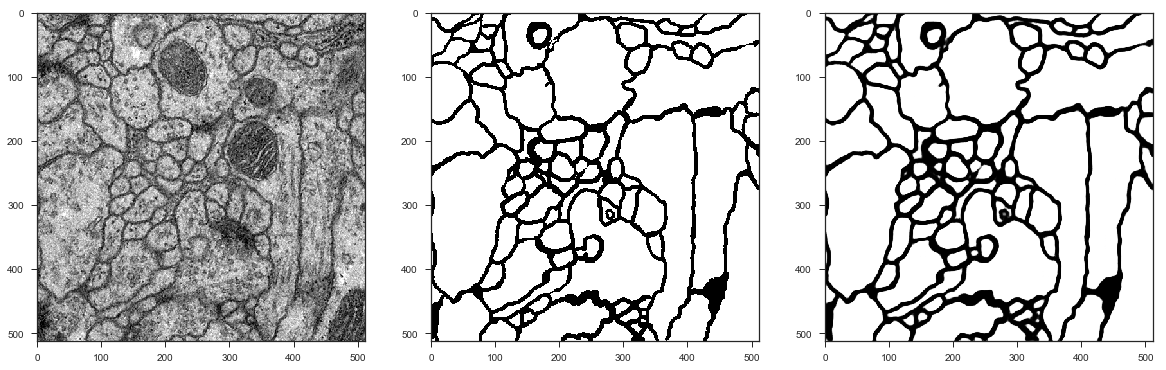

In [31]:
y_pred = model_unet_fuse_v3.predict(X_train[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(X_train[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_train[0].reshape((512, 512)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')

plt.show()

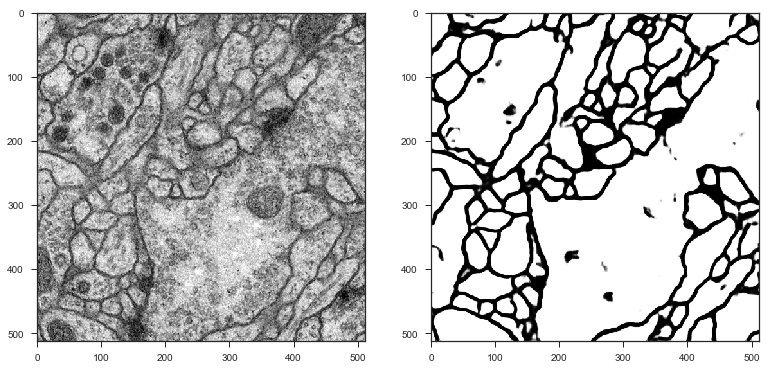

In [36]:
y_pred = model_unet_fuse_v3.predict(X_test[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_pred, cmap='binary')
plt.show()

In [50]:
y_pred = model_unet_fuse_v3.predict(X_test)
result_fuse = y_pred[-1].astype(np.float32)
result_02 = y_pred[-2].astype(np.float32)
result_fuse.shape, result_02.shape

((30, 512, 512, 1), (30, 512, 512, 1))

In [51]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v3.1_' + timestamp + '.tif', result_fuse, dtype=np.float32)

In [53]:
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v3.1_' + timestamp + '.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

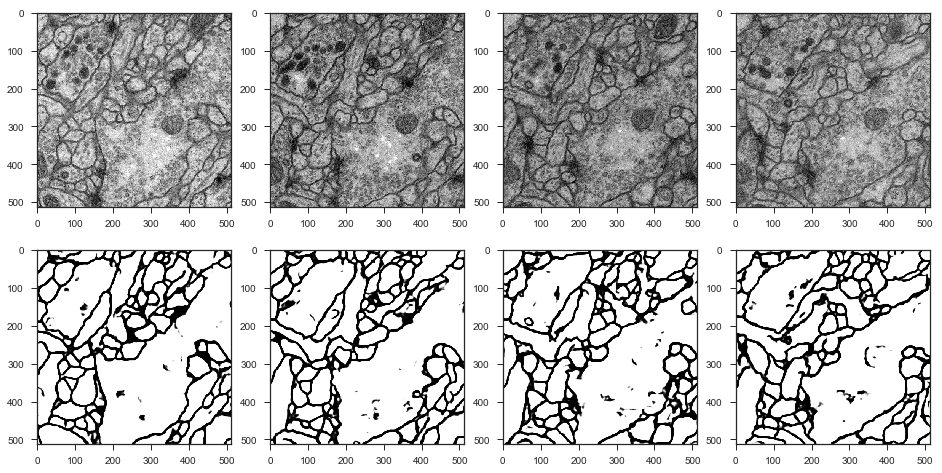

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='binary')

plt.show()